## Scripts to create and plot volume timeseries for clustered regions (for RGI regions!!!)

In [2]:
# updated script version for flattening gfdl-esm2m overshoot stabilisation scenarios from university of Bern 
from oggm import utils
import json
import oggm
import sys
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
# get the correct colors for the different scenarios
from analysis_func import color_scenario, label_scenario, d_reg_num_name, color_scenario_poster, scenario_ls
from sklearn.preprocessing import normalize
import sklearn
from sklearn.cluster import KMeans
import scipy
import glob
import matplotlib.pyplot as plt
from datetime import date
import geopandas as gpd
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
# for plots withinplots 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import matplotlib as mpl
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature


palette = sns.color_palette(color_scenario.values())
scenarios = color_scenario.keys()

just look at the common running glaciers:

In [3]:
bc = '_bc_1980_2019' # more glaciers/glacier area works for this bc option
pd_working_all = pd.read_csv(f'../data/working_rgis_for_oversh_stab_scenarios{bc}.csv', index_col='rgiid')[['area','all_running_rgis', 'rgi_reg']]

all_running_rgis = pd_working_all.dropna().index.values

# RGI region data 
frgi = utils.file_downloader('https://cluster.klima.uni-bremen.de/~oggm/rgi/rgi62_stats.h5')
#frgi = '/home/users/lschuster/glacierMIP/rgi62_stats.h5'
df_rgi6g = pd.read_hdf(frgi, index_col=0)
df_rgi6g = df_rgi6g.loc[df_rgi6g.Connect != 2]


# climate data 
pd_clim_all= pd.read_csv('../data/annual_glob_rgi_reg_basin_temp_precip_timeseries_oversh_stab.csv', 
                         index_col=['Unnamed: 0'])
pd_clim_all_rgi_reg = pd_clim_all

rgi_regions_fn = '../data/data_from_others/rgi60_regions_robinson-v2.shp'

# geodetic data for some additional stats 
pd_geodetic = utils.get_geodetic_mb_dataframe()[utils.get_geodetic_mb_dataframe().period=='2000-01-01_2020-01-01']

In [4]:
var = 'temp_21yr_avg'


In [5]:
### regional glacier mass and runoff projections
### common running glaciers merged in 2_volume_timeseries
_df_scenario_common_rgi_reg = xr.open_dataset(f'../data/common_running_sum_all_rgi_reg_oversh_stab_2000_2500{bc}.nc')
# we include here the rolling average .. 
df_scenario_common_rgi_reg = _df_scenario_common_rgi_reg.rolling(time=21, center=True).mean().dropna(dim='time', how='all')
#df_scenario_common_vol_rel = 100*df_scenario_common_rgi_reg.volume/df_scenario_common_rgi_reg.volume.sel(time=2020)
df_scenario_common_vol_rel = 100*df_scenario_common_rgi_reg.volume/_df_scenario_common_rgi_reg.volume.sel(time=2020)
df_scenario_common_runoff_rel = 100*df_scenario_common_rgi_reg.runoff/_df_scenario_common_rgi_reg.runoff.sel(time=2020)


In [6]:
df_scenario_common_runoff_rel

<xarray.DataArray 'runoff' (bias_correction: 1, rgi_reg: 19, scenario: 8,
                            gcm: 1, time: 481)>
array([[[[[ 81.24047 ,  81.98362 ,  82.05112 , ...,  70.71175 ,
            70.37649 ,  66.19754 ]],

         [[ 81.18894 ,  81.93205 ,  81.99979 , ...,  71.382065,
            70.955345,  67.6828  ]],

         [[ 81.20906 ,  81.95047 ,  82.013626, ...,  70.59268 ,
            70.30328 ,  67.252174]],

         ...,

         [[ 81.24168 ,  81.98484 ,  82.0523  , ...,  73.431274,
            73.3738  ,  69.73605 ]],

         [[ 81.1898  ,  81.93294 ,  82.00064 , ...,  77.694496,
            77.13118 ,  73.36795 ]],

         [[ 81.210236,  81.95168 ,  82.01483 , ...,  78.860344,
            78.40847 ,  74.99376 ]]],

...

        [[[112.08251 , 112.99474 , 114.370575, ..., 112.55045 ,
           113.02209 , 107.54483 ]],

         [[112.32123 , 113.2329  , 114.6193  , ..., 115.155266,
           114.624146, 109.56431 ]],

         [[111.735954, 112.67256 , 114.0666  , ..., 112.71298 ,
           112.51578 , 108.06878 ]],

         ...,

         [[112.08388 , 112.995964, 114.37187 , ..., 117.59442 ,
           118.5484  , 113.07621 ]],

         [[112.31387 , 113.22603 , 114.612724, ..., 126.20958 ,
           126.21765 , 119.45034 ]],

         [[111.73844 , 112.67488 , 114.0689  , ..., 121.56575 ,
           121.83324 , 115.360176]]]]], dtype=float32)
Coordinates:
  * time             (time) float64 2.01e+03 2.011e+03 ... 2.489e+03 2.49e+03
    hydro_month      (rgi_reg, time) int64 4 4 4 4 4 4 4 ... 10 10 10 10 10 10
    calendar_month   (time) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
  * gcm              (gcm) object 'GFDL-ESM2M'
  * scenario         (scenario) object 'oversh_T20OS15' ... 'stab_T30'
  * bias_correction  (bias_correction) object 'bc_1980_2019'
    OGGM_version     <U22 'OGGM_v161_gdirs_2023.3'
  * rgi_reg          (rgi_reg) object '01' '02' '03' '04' ... '17' '18' '19'

--> if we just merge 11 with 12, we have an issue, as 12 will create the signal for 11 as the volume of 12 is relatively large

**this is mostly for the maps and to get the temperature ...**

In [7]:
# save the glacier area beside the climate datasets for the stats later ... 
df_rgi6g_grouped_area = df_rgi6g.groupby('O1Region').sum()['Area']
for p in df_rgi6g.O1Region.dropna().unique():
    pp = f'RGI{p}_glacier'
    area = df_rgi6g_grouped_area.loc[p]
    pd_clim_all.loc[pd_clim_all.region==pp,'area'] = area

- if it does not work, need to set the random state to e.g. 42

In [8]:
#scenario_sel = [ 'stab_T12',
#       'stab_T15', 'oversh_T20OS15', 'oversh_T25OS15', 'oversh_T30OS15', 'stab_T30']
df_scenario_common_vol_rel_sel = df_scenario_common_vol_rel.sel(scenario=list(color_scenario_poster.keys()))
df_scenario_common_runoff_rel_sel = df_scenario_common_runoff_rel.sel(scenario=list(color_scenario_poster.keys()))


In [9]:
# final clustering approach volume differences of relative mass projections betwen stab_T15 and oversh_T30OS15
k = 4 
pd_vol_all_diff = (df_scenario_common_vol_rel_sel.sel(scenario='stab_T15') - df_scenario_common_vol_rel_sel.sel(scenario='oversh_T30OS15')).to_dataframe().reset_index()
pd_vol_all_diff = pd_vol_all_diff[['rgi_reg','time','volume']].pivot(index='time', columns='rgi_reg', values='volume')
pd_vol_all_diff = pd_vol_all_diff.T
data_all = pd_vol_all_diff.values
pregs = pd_vol_all_diff.index
        
kmeans = KMeans(n_clusters=k,  n_init=100, max_iter=1000)
labels = ['test']

kmeans.fit(data_all)

# Get the resulting centroids and labels
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

# Print the resulting centroids and labels
print("Centroids:")
print(centroids)
print("Labels:")
print(labels)

# before we had several clustering options, for this final version, not really necessary anymore, but well...
pd_clusters_all = pd.DataFrame(index=pregs)
wcss = {}
pd_clusters_all[f'kmeans_{k}clusters_diff_oversh'] = labels
wcss[f'kmeans_{k}clusters_diff_oversh'] = kmeans.inertia_

pd_clusters_all
print(wcss)

Centroids:
[[ 2.6800972e-03  4.5787268e-03  8.0773495e-03 ...  1.2040758e+00
   1.3801694e+00  1.5824199e+00]
 [ 1.0423278e-02  9.5062256e-03  8.6196903e-03 ...  1.3885092e+01
   1.3881865e+01  1.3881430e+01]
 [ 6.2179589e-04  1.1393230e-03  2.1438599e-03 ...  3.1608944e+00
   3.1815383e+00  3.2116079e+00]
 [ 0.0000000e+00 -4.8828120e-03 -1.3542174e-02 ... -6.0938110e+00
  -5.7642055e+00 -5.5216823e+00]]
Labels:
[1 2 2 2 1 2 1 2 1 0 0 3 0 0 0 0 2 0 1]
{'kmeans_4clusters_diff_oversh': 194734.359375}


In [10]:
# we manually say that the Caucasus/middle east region should be in the same cluster as New Zealand  
# at least for the diff clustering
pd_clusters_all.loc['12', ['kmeans_4clusters_diff_oversh']] = pd_clusters_all.loc['11',['kmeans_4clusters_diff_oversh']]
for b,c in zip(pd_clusters_all.index, pd_clusters_all[f'kmeans_{k}clusters_diff_oversh'].values):
    df_rgi6g.loc[df_rgi6g.O1Region==b,f'kmeans_{k}clusters_diff_oversh'] = c

## FIg. 3 (chosen variant With 8 subplots)

In [11]:
#plt.rc('font', size=14)
df_scenario_common = df_scenario_common_rgi_reg

In [12]:
# create a new clustering numbering to  make sure that always the same cluster "number" is used 
for c in np.arange(0,4):
    _r = pd_clusters_all.loc[pd_clusters_all[f'kmeans_{k}clusters_diff_oversh'] == c]
    if '19' in _r.index:
        new_c = 0
    elif '03' in _r.index:
        new_c = 1
    elif '11' in _r.index:
        new_c  = 2
    elif '12' in _r.index:
        new_c = 2
    pd_clusters_all.loc[pd_clusters_all[f'kmeans_{k}clusters_diff_oversh'] == c,'manual_chosen_3_clusters'] = new_c
    for b,new_c in zip(pd_clusters_all.index, pd_clusters_all['manual_chosen_3_clusters'].values):
        df_rgi6g.loc[df_rgi6g.O1Region==b,f'manual_chosen_3_clusters'] = new_c
    
# selected colors for the different clusters
cols = ['black', 'C5', 'C8']
cols = sns.color_palette(cols)

In [13]:
# estimate some statistics for the additional subplots 
### we want to get climate statistics from these regions ... 
regs = ['RGI01_glacier', 'RGI02_glacier',
       'RGI03_glacier', 'RGI04_glacier', 'RGI05_glacier', 'RGI06_glacier',
       'RGI07_glacier', 'RGI08_glacier', 'RGI09_glacier', 'RGI10_glacier',
       'RGI11_glacier', 'RGI12_glacier', 'RGI13_glacier', 'RGI14_glacier',
       'RGI15_glacier', 'RGI16_glacier', 'RGI17_glacier', 'RGI18_glacier',
       'RGI19_glacier']
#from sklearn.preprocessing import StandardScaler
# I think that does not work ... 
#pd_clim_all['temp_31yr_avg'] = pd_clim_all[['temp','year']].rolling(31, 31, center=True, on='year').mean()['temp'].dropna()

# volume difference of stabilisation vs overshoot  (rel. to 2020)
end_vol_rel_diff_stab_oversh = pd_vol_all_diff[2489].values  # for the end year (21-year rolling average)
max_vol_rel_diff_stab_oversh =pd_vol_all_diff.max(axis=1).values # and maximum difference 
# volume of overshoot scenario (rel. to 2020)
end_vol_oversh =df_scenario_common_vol_rel_sel.sel(scenario='oversh_T30OS15').sel(time=2489).values.squeeze()
end_vol_stabT15 =df_scenario_common_vol_rel_sel.sel(scenario='stab_T15').sel(time=2489).values.squeeze()

min_vol_oversh =df_scenario_common_vol_rel_sel.sel(scenario='oversh_T30OS15').min(dim='time').values.squeeze()
# temperature stuff ---> started to apply now a 101 yr rolling average
roll_avg = 101
_ds_clim_oversh = pd_clim_all.groupby(['region','year', 'scenario']).mean().to_xarray().sel(scenario='oversh_T30OS15')
_temp_ch_oversh = (_ds_clim_oversh.rolling(year=roll_avg, center=True).mean()['temp'].dropna(dim='year') - _ds_clim_oversh.rolling(year=21, center=True).mean()['temp'].sel(year=2010)).sel(region=regs)

_ds_clim_stab = pd_clim_all.groupby(['region','year', 'scenario']).mean().to_xarray().sel(scenario='stab_T15')
_temp_ch_stab = (_ds_clim_stab.rolling(year=roll_avg, center=True).mean()['temp'].dropna(dim='year') - _ds_clim_stab.rolling(year=21, center=True).mean()['temp'].sel(year=2010)).sel(region=regs)
temp_ch_oversh_max = (_temp_ch_oversh).max(dim='year').values
temp_ch_oversh_end = (_temp_ch_oversh).isel(year=-1).values

temp_ch_diff_oversh_stab_end = temp_ch_oversh_end-(_temp_ch_stab).isel(year=-1).values
temp_ch_diff_oversh_stab_max = (_temp_ch_oversh-_temp_ch_stab).max(dim='year').values


pd_rgi_reg_stats = pd.DataFrame(index=['All'] + list(df_scenario_common_vol_rel_sel.rgi_reg.values))
#pd_gmip3_stats = pd.read_csv('data_from_others/rgi_vs_2020_volume_hugonnet_estimatesJan29_2024.csv', index_col=[0])
regrowth_var = end_vol_oversh-min_vol_oversh
pd_rgi_reg_stats['regrowth_overshoot_study'] = np.concatenate([np.array([np.NaN]),(regrowth_var)])
pd_rgi_reg_stats['diff_yr_2500_overshoot_study']  = np.concatenate([np.array([np.NaN]),
                                                                  (-end_vol_rel_diff_stab_oversh)])
pd_rgi_reg_stats['maximum_difference_overshoot_study'] =  np.concatenate([np.array([np.NaN]),
                                                                        -max_vol_rel_diff_stab_oversh])


pd_rgi_reg_stats['end_vol_stabT15'] = np.concatenate([np.array([np.NaN]),
                                                                  (end_vol_stabT15)])



In [14]:
d_reg_num_name['19'] = 'Subantarctic &'
d_reg_num_name['20'] = '      Antarctic Islands'
text_reg_leg_d = {}
for j,r in enumerate(d_reg_num_name.keys()):
    if j == 0:
        jj = j
        text_reg_leg_d[j] = []
    elif j == 5:
        jj = j
        text_reg_leg_d[j] = []
    elif j== 10:
        jj = j
        text_reg_leg_d[j] = []
    elif j == 15:
        jj = j
        text_reg_leg_d[j] = []
    if j == 19:
        text_reg_leg_d[jj].append(f'{d_reg_num_name[r]}')
    else:
        text_reg_leg_d[jj].append(f'{r}: {d_reg_num_name[r]}')

In [15]:
       
# todo --> need to get the gmip3 code 
pd_gmip3_stats = pd.read_csv('../analysis_notebooks/schuster_el_al_phd_paper_2_overshoot_glaciers/data_from_others/glaciermip3_shift_summary_region_characteristics.csv',index_col=0)
# we only take this from gmip3 --> TODO (copy code from gmip3 to get to the slope to here!!!)
pd_rgi_reg_stats['slope_weighted_area_avg'] = pd_gmip3_stats.loc[pd_rgi_reg_stats.index, 'slope_weighted_area_avg']

pd_rgi_reg_stats['region'] = pd_rgi_reg_stats.index 

In [16]:
### for the map ... 
delta = 0
coordinates = [
    [0.0245, 0.25 + delta],
    [0.052, 0.762 + delta],
    [0.11, 0.628 + delta],
    [0.205, 0.88 + delta],
    [0.26, 0.635 + delta],
    [0.325, 0.90 + delta],
    [0.37, 0.67 + delta],
    [0.43, 0.91 + delta],
    [0.54, 0.912 + delta],
    [0.63, 0.89 + delta],
    [0.77, 0.817 + delta],
    [0.445, 0.597 + delta],
    [0.538, 0.56 + delta],
    [0.725, 0.645 + delta],
    [0.613, 0.527 + delta],
    [0.70, 0.497 + delta],
    [0.46, 0.438 + delta],
    [0.335, 0.331 + delta],
    [0.812, 0.385 + delta],
    [0.54, 0.225 + delta]
]



# go down from rgi7_scripts/workflow
data_dir = '/home/www/fmaussion/misc/rgi7_data/rgi7_final'

# from fabi's RGI6/rgi7 code  ... https://nbviewer.org/urls/cluster.klima.uni-bremen.de/~fmaussion/misc/rgi7_scripts/workflow/postprocessing/plots_for_doc/global_overview_maps.ipynb
df_reg_shp_rgi7 = gpd.read_file('zip://' + data_dir+'/RGI2000-v7.0-regions.zip/RGI2000-v7.0-o1regions.shp')
df_reg_shp_rgi7['min_x'] = [g.bounds[0] for g in df_reg_shp_rgi7.geometry]
df_reg_shp_rgi7['max_x'] = [g.bounds[2] for g in df_reg_shp_rgi7.geometry]
df_reg_shp_rgi7['min_y'] = [g.bounds[1] for g in df_reg_shp_rgi7.geometry]
df_reg_shp_rgi7['max_y'] = [g.bounds[3] for g in df_reg_shp_rgi7.geometry]
num_dict = {0:'a', 1:'b', 2:'c', 3:'d', 4: 'e',
            5:'f', 6:'g', 7:'h', 8:'i', 9:'j',
            10:'k', 11:'l', 12:'m'} 


clustering_opt = 'manual_chosen_3_clusters' # f'kmeans_{k}clusters_diff_oversh'

add_rgi_glaciers = True

pd_basin_num = gpd.read_file('/home/www/fmaussion/misc/magicc/basins_shape/glacier_basins.shp')

pd_basin_num['glaciated_vs_basin_area_RGI6_perc'] = 100*pd_basin_num['RGI_AREA']/pd_basin_num['AREA_CALC']
pd_basin_num_glac = pd_basin_num.loc[pd_basin_num.glaciated_vs_basin_area_RGI6_perc>0.1]
basin_glac = pd_basin_num_glac.MRBID.values.astype(str)
pd_working_all = pd_working_all.where(pd_working_all['all_running_rgis'].dropna())

In [18]:
# for the basins and runoff ... (figure that did not make it into manuscript) ... 
f = open('/home/www/fmaussion/misc/magicc/rgi_ids_per_basin.json')
rgi_ids_basin_idx = json.load(f)
for basin in rgi_ids_basin_idx.keys():
    intersect_rgi_ids = np.intersect1d(pd_working_all.index, rgi_ids_basin_idx[basin])
    pd_working_all.loc[intersect_rgi_ids, 'basin'] = basin



In [19]:
pd_working_all.loc[df_rgi6g[clustering_opt].index,'mass_cluster_fig3'] = df_rgi6g[clustering_opt].values
pd_working_all_basin_clus = pd_working_all.groupby(['basin','mass_cluster_fig3']).sum().reset_index()
#pd_working_all_basin_clus = pd_working_all_basin_clus.set_index('basin')
basin_glac_clus_dict = {}
for _b in basin_glac:
    clus = pd_working_all_basin_clus.loc[pd_working_all_basin_clus.basin == _b].sort_values(by='area', ascending = True)['mass_cluster_fig3'].iloc[-1]
    basin_glac_clus_dict[_b] = clus
# Save the dictionary as a JSON file
with open('../data/basin_glac_cluster_fig3_dictionary.json', 'w') as json_file:
    json.dump(basin_glac_clus_dict, json_file, indent=4)

0 ['01' '05' '07' '09' '19']
1 ['02' '03' '04' '06' '08' '17']
2 ['10' '11' '12' '13' '14' '15' '16' '18']
0 ['01' '05' '07' '09' '19']
65.8
volume Mass
1 ['02' '03' '04' '06' '08' '17']
29.6
2 ['10' '11' '12' '13' '14' '15' '16' '18']
4.7


posx and posy should be finite values


0 ['01' '05' '07' '09' '19']
1 ['02' '03' '04' '06' '08' '17']
2 ['10' '11' '12' '13' '14' '15' '16' '18']
0 ['01' '05' '07' '09' '19']
58.7
runoff Runoff
1 ['02' '03' '04' '06' '08' '17']
23.6
2 ['10' '11' '12' '13' '14' '15' '16' '18']
13.9


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


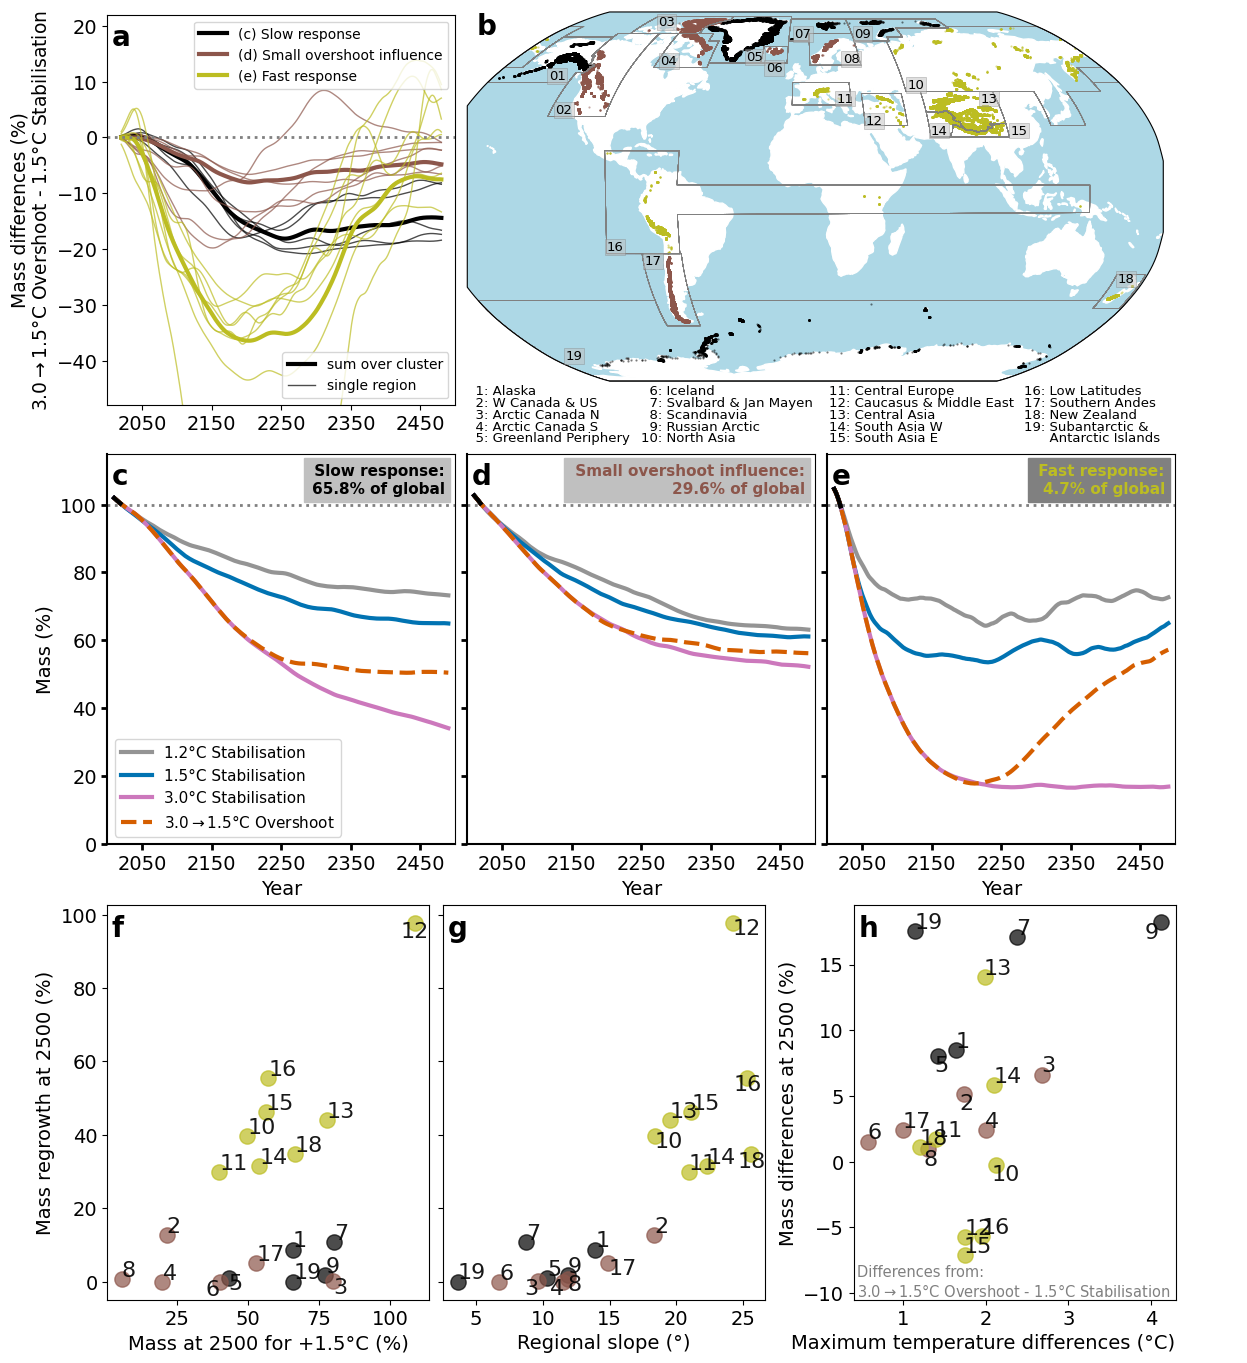

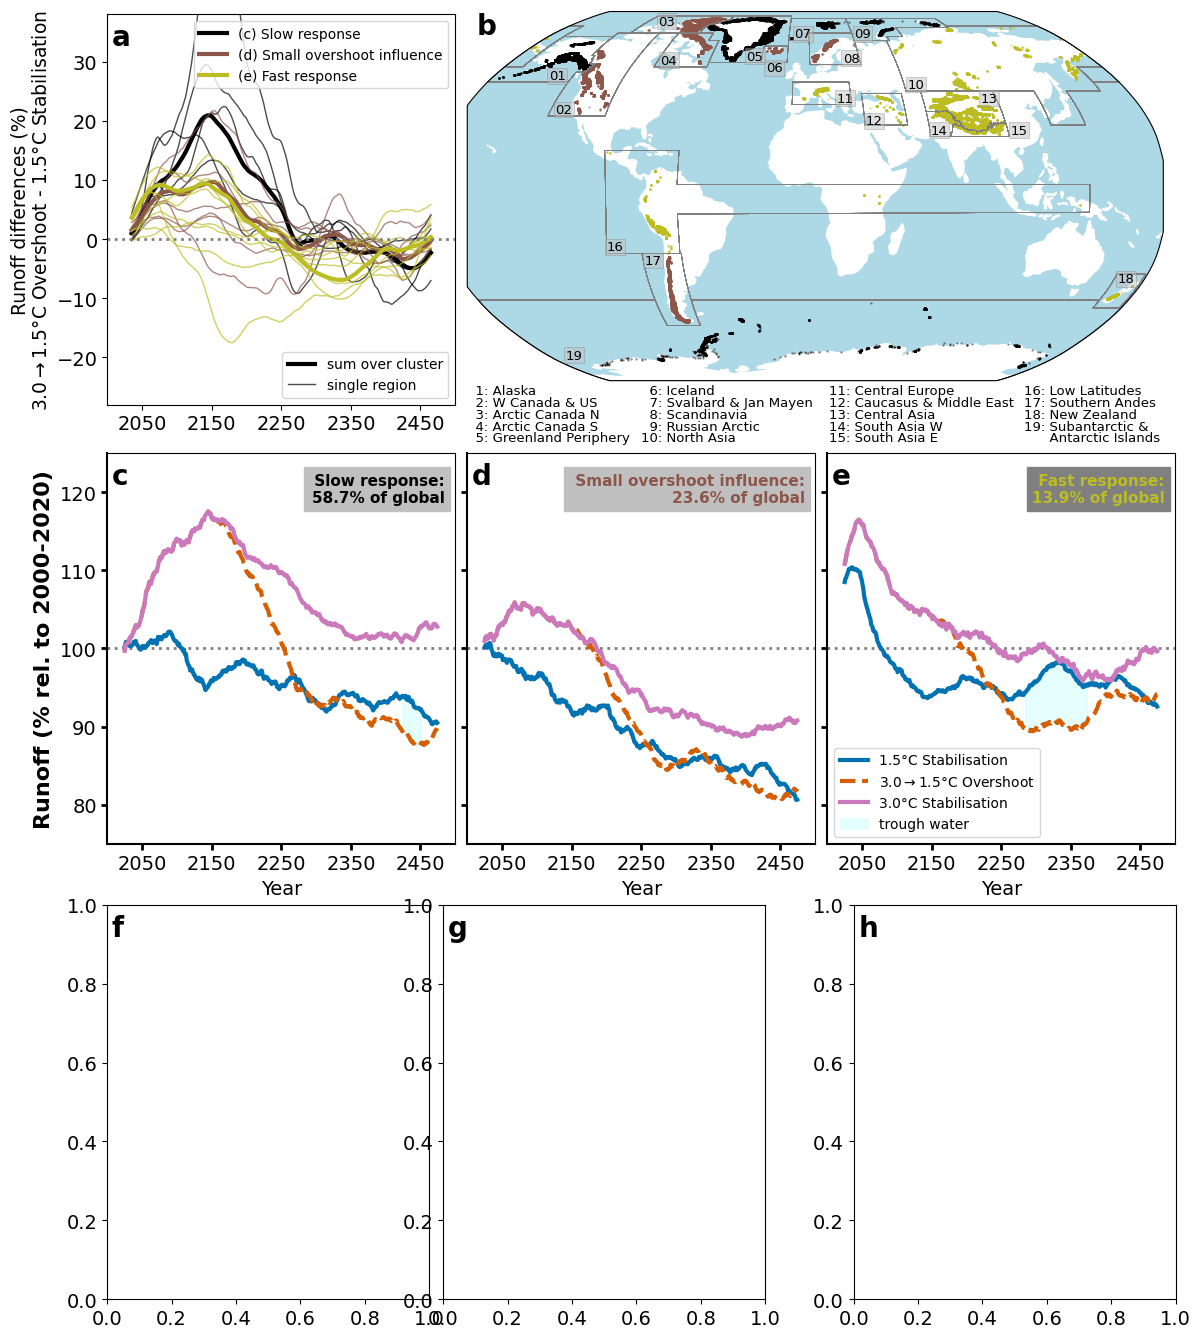

In [20]:
shift_x=0

texts = ['(c) Slow response','(d) Small overshoot influence','(e) Fast response']
fs_label = 14
fs_t = 16
## new figure approach
def remove_zero(l):
    if l[0] == '0':
        l = l[-1]
    return l

plt.rc('font', size=14)
for variable in ['volume', 'runoff']: #, 'runoff_basins']:  #  'runoff',
    clustering_opt = 'manual_chosen_3_clusters'
    if clustering_opt == 'manual_chosen_3_clusters': # f'kmeans_{k}clusters_diff_oversh':
        kk = k-1
    else:
        kk = k
    
    fig = plt.figure() #figsize=(20,8))
    reg_pie_sizes=[]
    for c in np.arange(0,kk,1):
        pie_size = 0.29
        reg_pie_sizes.append(pie_size)
    fac=1.535*0.65 # 
    fac_2 = fac*1.02
    d = 0.01
    axgb = fig.add_axes([0.07+d, 0.555+ fac_2/2 * reg_pie_sizes[1],
                         reg_pie_sizes[0], reg_pie_sizes[0]*fac], facecolor='white') # 0.01 
    # Add background image
    ax_background = fig.add_axes([0.37+d,0.54 + fac/2 * reg_pie_sizes[1]+d,
                                  0.58,0.5*0.65], projection=ccrs.Robinson())
    ax0b = fig.add_axes([0.07+d,0.555 - fac_2/2 * reg_pie_sizes[1]-0.04+d,
                         reg_pie_sizes[1],reg_pie_sizes[1]*fac], facecolor='white')
    ax1b = fig.add_axes([0.37+d,0.555 - fac_2/2 * reg_pie_sizes[1]-0.04+d,
                         reg_pie_sizes[1],reg_pie_sizes[1]*fac], facecolor='white')
    ax2b = fig.add_axes([0.67+d, #0.665,
                         0.555 - fac_2/2 * reg_pie_sizes[1]-0.04+d,
                         reg_pie_sizes[1],reg_pie_sizes[1]*fac], facecolor='white')  

    ax3b = fig.add_axes([0.07+d,0.04,#67,
                         reg_pie_sizes[1]*0.925,reg_pie_sizes[1]*fac*1.01], facecolor='white')
    ax4b = fig.add_axes([0.35+d, #0.37
                         0.04,#67,
                         reg_pie_sizes[1]*0.925,reg_pie_sizes[1]*fac*1.01], facecolor='white')
    ax5b = fig.add_axes([0.692+d,
                         0.04,#67,
                         reg_pie_sizes[1]*0.925,reg_pie_sizes[1]*fac*1.01], facecolor='white')  

    #### 
    if variable == 'runoff':
        variable_c = 'Runoff'
        variable2 = 'runoff'
        roll_avg = 51
    elif variable == 'runoff_basins':
        variable_c = 'Runoff'
        variable2 = 'runoff'
        roll_avg = 51
    else:
        variable_c  = 'Mass'
        variable2 = 'volume'
        roll_avg = 21

    show_temp = False    

    pie_scenario = 2

    # Add background image
    ax_background.patch.set_facecolor('lightblue')
    ax_background.get_yaxis().set_visible(False)
    ax_background.get_xaxis().set_visible(False)
#    ax_background.coastlines(color='white')
    ax_background.add_feature(cartopy.feature.LAND, color='white')

    # Add global boundary
    #ax_global_patch = fig.add_axes([0.005,0.52,0.425,0.48], facecolor='white')
    #ax_global_patch.get_yaxis().set_visible(False)
    #ax_global_patch.get_xaxis().set_visible(False)

    # Add RGI glacier outlines

    if add_rgi_glaciers:
        # if I do that here: somehow only the glaicers of one RGI region are visible**
        #shape_feature = ShapelyFeature(Reader(rgi_shp_fn).geometries(), ccrs.Robinson(),alpha=1,facecolor='indigo',linewidth=0.35,edgecolor='indigo')
        #ax_background.add_feature(shape_feature)
        # instead apply that here ... 
        for c in np.arange(0,3,1):
            df_rgi6g_sel = df_rgi6g.loc[df_rgi6g[clustering_opt]==c]
            ax_background.scatter(df_rgi6g_sel.CenLon.values, df_rgi6g_sel.CenLat.values,
                                  color=cols[c],
                                  #color='lightgrey',
                                  s=0.3, alpha =0.5,
                                  transform=ccrs.PlateCarree());
    if  variable != 'runoff_basins':
        for en,rgi_reg in enumerate(df_scenario_common.rgi_reg):
            coords = coordinates[en]
            shape_feature = ShapelyFeature(Reader(rgi_regions_fn).geometries(), ccrs.Robinson(),
                                           facecolor="None", edgecolor='grey', alpha = 1, lw=0.4)
                                           #alpha=1,facecolor='None',linewidth=0.35,edgecolor='k')
            ax_background.add_feature(shape_feature)


    ### copied from fabis RGI6/7 code ....
        did10 = False
        for i, r in df_reg_shp_rgi7.iterrows():
            tx = r.min_x + 4
            ty = r.min_y 
            fs = 16
            t = r.o1region

            if t == '01':
                tx = r.min_x + 35
            if t == '03':
                tx = r.min_x + 15
                ty = r.min_y + 3
            if t == '05':
                tx = r.min_x + 40
            if t == '06':
                ty = r.min_y - 5.5
            if t == '08':
                tx = r.min_x + 20
            if t == '09':
                tx = r.min_x 
            if t == '11':
                tx = r.min_x + 24
            if t == '10':
                tx = r.min_x + 1
                ty = r.min_y + 15
                if not did10:
                    did10 = True
                    continue
            if t == '13':
                ty = r.min_y + 12
                tx = r.min_x + 30
            if t in ['14', '12', '16', '17']:
                tx = r.min_x 
            if t == '15':
                tx = r.min_x + 30
            if t == '17':
                ty = r.min_y + 26
            if t == '18':
                ty = r.min_y + 10
            if t == '19':
                ty = r.min_y + 10
            if t == '20':
                continue

            ax_background.text(tx, ty, t, transform=ccrs.PlateCarree(), 
                    ha='left', va='bottom', fontsize=9.5,bbox=dict(facecolor='silver', edgecolor='grey',
                                                                   pad=1, lw=0.5, alpha=0.5)
                          )

        # Add the RGI glacier name annotations  as columns
        x_pos = 0  # initial x position
        for jjj,key in enumerate(sorted(text_reg_leg_d.keys())):
            y_pos = -0.045  # start at the top of the y-axis
            for text in text_reg_leg_d[key]:
                if text[0] == '0':
                    text = '  ' + text[1:]
                ax_background.text(x_pos, y_pos, text, transform=ax_background.transAxes,
                                   fontsize=9.5, verticalalignment='bottom')

                y_pos -= 0.032  # move down for each entry
            if jjj ==0:
                x_pos += 0.25 #37  # move to the next column
            elif jjj==1:
                x_pos += 0.27
            else:
                x_pos += 0.28 #37  # move to the next column

    ax = axgb

    if variable != 'runoff_basins':
        # just for the legend
        from matplotlib.lines import Line2D

        line1 = Line2D([0], [0], color='k',
                         label='sum over cluster',
                         lw=3, alpha = 1)  
        line2 = Line2D([0], [0], color='k',
                         label='single region',
                         lw=1, alpha = 0.7)  
        leg1 = ax.legend([line1,line2],['sum over cluster','single region'],
                   fontsize=10, ncol=1, loc='lower right')

        line_c1 = Line2D([0], [0], color=cols[0], #-1],
                         label='',
                         lw=3, alpha = 1)  
        line_c2 = Line2D([0], [0], color=cols[1], #0],
                         label='',
                         lw=3, alpha = 1)  
        line_c3 = Line2D([0], [0], color=cols[2], #],
                         label='',
                         lw=3, alpha = 1)  

        ax.legend([line_c1, line_c2, line_c3],
               texts,
               #title_fontsize=11,
               #title=r'3.0$\rightarrow$1.5 Overshoot - 1.5 Stabilisation',
               fontsize=10, loc='upper right')
        ax.add_artist(leg1)
    else:
        line2 = Line2D([0], [0], color='k',
                         label='glaciated basin (n=60)',
                         lw=1, alpha = 0.7)  
        ax.legend([line2],['glaciated basin (n=60)'],
                   fontsize=10, ncol=1, loc='upper right')


    ##############################
    if variable != 'runoff_basins':
        for c in np.arange(0,3,1): 
            #ax = axs[c]
            #plt.subplot(2,3,c+1)
                rgi_regs_sel = pd_clusters_all.loc[pd_clusters_all['manual_chosen_3_clusters']==c].index.values
                 # make sure to use the non-rolling average at year 2020 (i.e., use _df_scenario_common_rgi_reg instead of df_scenario_common_rgi_reg)
                init_sel_sum = _df_scenario_common_rgi_reg[variable].sel(time=2020).sel(rgi_reg = rgi_regs_sel).sum(dim='rgi_reg')
                _sel = df_scenario_common_rgi_reg[variable].sel(rgi_reg=rgi_regs_sel)
                print(c, _sel.rgi_reg.values)
                #ax.set_title([c, _sel.rgi_reg.values], fontsize=12)
                df_scenario_common_cluster = _sel.sum(dim='rgi_reg')
                df_scenario_common_cluster_rel = 100*df_scenario_common_cluster/init_sel_sum
                #äfor s in color_scenario_poster.keys(): 
                sel_diff_rel = df_scenario_common_cluster_rel.sel(scenario='oversh_T30OS15').squeeze()-df_scenario_common_cluster_rel.sel(scenario='stab_T15').squeeze()
                if str(_sel.rgi_reg.values) != "['12']":
                    ax.plot(df_scenario_common_cluster_rel.time,
                             sel_diff_rel.rolling(time=roll_avg,center=True).mean(),
                             color=cols[c], #color_scenario_poster[s],
                             lw=3)  

                if variable =='volume':
                    sel_diff = df_scenario_common_vol_rel.sel(rgi_reg=rgi_regs_sel).sel(scenario='oversh_T30OS15')-df_scenario_common_vol_rel.sel(rgi_reg=rgi_regs_sel).sel(scenario='stab_T15')
                else:
                    sel_diff = df_scenario_common_runoff_rel.sel(rgi_reg=rgi_regs_sel).sel(scenario='oversh_T30OS15')-df_scenario_common_runoff_rel.sel(rgi_reg=rgi_regs_sel).sel(scenario='stab_T15')

                for r in _sel.rgi_reg:
                    ax.plot(_sel.time,
                             sel_diff.sel(rgi_reg=r).squeeze().rolling(time=roll_avg, center=True).mean(), lw=1, color = cols[c], alpha = 0.7,
                            )

    if variable == 'runoff_basins':
        for _b in basin_glac:
            c = basin_glac_clus_dict[_b].astype(int)
            sel_diff_rel_b = sel_diff_runoff_basins_rel.sel(basin = _b)
            ax.plot(sel_diff_rel_b.time,
                    sel_diff_rel_b, # we do the rolling already before that ... (not sure if it is ag ood ideal .rolling(time=roll_avg,center=True).mean(),
                                           color=cols[c], #color_scenario_poster[s],
                                           lw=0.2, alpha = 0.3)#, zorder=10)  

        #plt.figure(figsize=(10,7))
        for c,j in enumerate([0,1,2]): #2,3]):
            c = cols[j]
            _pd_sel = sel_diff_runoff_basins_rel.sel(basin = clus_basin_glac_dict[j]).to_dataframe().reset_index()
            n = len(_pd_sel.basin.unique())
            sns.lineplot(ax=ax,data = _pd_sel, x='time', y= 'runoff', estimator='median',
                errorbar=('pi', 100), color = c, label=f'{n} basins', err_kws={'alpha':0.3})
        ax.legend(title = '60 glaciated basins\nmedian (total range)', ncol=3, fontsize=9, title_fontsize=9, loc='lower right')
        #plt.ylabel(f'Runoff differences\n(% rel. to 2000-2050)', fontsize=16,fontweight='bold')
        #plt.xlabel('Year')
        #plt.axhline(0,color='grey')

    ax.axhline(0, lw=2, color='grey',ls=':')
    if variable == 'volume':
        ax.set_ylim([-48, 22])
        ax.set_yticks([-40,-30,-20,-10,0,10,20])
    elif variable =='runoff_basins':
        ax.set_ylim([-35, 35])
        ax.set_yticks([-30,-20,-10,0,10,20,30])
    else:
        ax.set_ylim([-28, 38])
        ax.set_yticks([-20,-10,0,10,20,30])
    if variable != 'runoff_basins':
        ax.set_ylabel(f'{variable_c} differences (%)\n'+r'3.0$\rightarrow$1.5°C Overshoot - 1.5°C Stabilisation',
                      #r'3.0$\rightarrow$1.5 Overshoot - 1.5 Stabilisation',
                      fontsize=fs_label-0.5) #,fontweight='bold')
    else:
        ax.set_ylabel(f'{variable_c} differences\n(% rel. to 2000-2050)', fontsize=16,fontweight='bold')

    #ax.set_title('Clusters selected after mass differences:    \nOvershoot 3.0°C->1.5°C - Stabilisation 1.5°C    ', fontsize=14)
    #ax.set_xlabel('Year', fontsize=16) #,fontweight='bold')
    ax.set_xlim([2000,2500])
    ax.set_xticks([2050,2150,2250,2350,2450],[2050,2150,2250,2350,2450])

    ###### the three cluster plots in second row ... 
    if variable == 'runoff_basins':
        for _b in basin_glac:
            c = basin_glac_clus_dict[_b].astype(int)
            geo = pd_basin_num.loc[pd_basin_num.MRBID==int(_b),'geometry'].values
            #feature = ShapelyFeature([geom], ccrs.Robinson(), facecolor=(1, 0, 0, 0.3), edgecolor=(0.5, 0.5, 0.5, 1), linewidth=0.2)
            shape_feature = ShapelyFeature(geo, ccrs.PlateCarree(),facecolor=(cols[c][0], cols[c][1], cols[c][2],0.3), 
                                           #edgecolor=(cols[c][0], cols[c][1], cols[c][2],0.8), 
                                           edgecolor=(0.4, 0.4, 0.4,0.8), 
                                           #grey 
                                           lw=0.9, zorder=-1) # , alpha = 0.4)
            ax_background.add_feature(shape_feature)

        #for _c in np.arange(0,k,1):
        #    df_rgi6g_sel = df_rgi6g.loc[df_rgi6g[clustering_opt]==_c]
        #    ax_background.scatter(df_rgi6g_sel.CenLon.values, df_rgi6g_sel.CenLat.values,
        #                          color=cols[_c],
        #                          #color='lightgrey',
        #                          s=0.1, alpha =0.5,
        #                          transform=ccrs.PlateCarree());

    ################################## REGIONAL
             #  , 'fast response, large loss',
             # r'fast regrowth, highest $\Delta$T sensitivity',
         #r'fastest regrowth, medium loss', #high $\Delta$T sensitivity', 'slow response, medium loss',
         #    '..., large loss', r'fast regrowth, highest $\Delta$T sensitivity'
         #'no regional temp. overshoot'
    nums = ['c','d','e'] #,'(d)','(e)','(g)']
    #            nums = ['(b)','(d)','(f)','(a)','(e)','(c)']
    for cc,ax in enumerate([ax0b,ax1b,ax2b,
                            #ax3b,ax4b,ax5b
                           ][:kk]):
        ax.axhline(100, lw=2, color='grey',ls=':')

        c = pd_clusters_all[clustering_opt].unique()[cc].astype(int)
        # make sure to use the non-rolling average at year 2020 (i.e., use _df_scenario_common_rgi_reg instead of df_scenario_common_rgi_reg)
        # for the runoff, we clearly want to divide trough the rolling average !!!
        if variable == 'volume':
            init_sel_sum = _df_scenario_common_rgi_reg[variable2].sel(time=2020).sel(rgi_reg = pd_clusters_all.loc[pd_clusters_all[clustering_opt]==c].index.values).sum(dim='rgi_reg')
        else:
            # this is the 21 yr averaged  stuff
            init_sel_sum = df_scenario_common_rgi_reg[variable2].sel(time=2010).sel(rgi_reg = pd_clusters_all.loc[pd_clusters_all[clustering_opt]==c].index.values).sum(dim='rgi_reg')

        ##### now the rolling average for the other stuff ... 
        _sel = _df_scenario_common_rgi_reg[variable2].sel(rgi_reg=pd_clusters_all.loc[pd_clusters_all[clustering_opt]==c].index.values)
        if 'runoff' in variable2:
            _sel = _sel.isel(time=slice(0,-1))
        _sel = _sel.rolling(time=roll_avg, center=True).mean().dropna(dim='time')
        print(c, _sel.rgi_reg.values)
        #ax.set_title(c, color=f'C{c}')
        df_scenario_common_cluster = _sel.sum(dim='rgi_reg')
        df_scenario_common_cluster_rel = (100*df_scenario_common_cluster/init_sel_sum)

        if variable2 == 'volume':
            scenarios = ['stab_T12', 'stab_T15',  'stab_T30','oversh_T30OS15'] #color_scenario_poster.keys()
        else:
            scenarios = ['stab_T15', 'oversh_T30OS15', 'stab_T30']

        for s in scenarios: 
            ax.plot(df_scenario_common_cluster_rel.time, df_scenario_common_cluster_rel.sel(scenario=s).squeeze(),
                    color=color_scenario_poster[s],
                    lw=3, label=label_scenario[s], ls= scenario_ls[s]) 
            ax.plot(df_scenario_common_cluster_rel.sel(time=slice(2000,2019)).time,
                    df_scenario_common_cluster_rel.sel(scenario=s).sel(time=slice(2000,2019)).squeeze(),
                    color='black',
                    lw=3, ls= '-') 
        leg = ax.legend(loc='lower left', bbox_to_anchor=(0.9,1.15), fontsize=14, ncol=4)

        if cc == 1:
            ### add legends
            handles, labels = ax.get_legend_handles_labels()
            if show_temp: 
                handles_2, labels_2 = ax2.get_legend_handles_labels()
                leg2 = ax.legend([handles[0], handles_2[0]], [f'{variable_c} changes\n(left)',
                                                              'Temperature changes\n(right, 21-yr avg.)'],
                                 loc='lower left', ncol=2, fontsize=10, bbox_to_anchor=(-0.28,1.15))
                leg2.get_lines()[0].set_linewidth(2)
                leg2.get_lines()[1].set_linewidth(1)
                for l in leg2.get_lines():
                    l.set_color('black')
                ax.add_artist(leg)    
            else:
                leg.remove()
        else:
            leg.remove()

        # DR wants to have a legend in (a), so removed the titles, as otherwise the same occurs twice ... 
        #ax.set_title(texts[cc], color=cols[c], fontsize=12,fontweight='bold') #+' '+ texts[c], fontsize=11)
        delta=0
        tt = ''
        rgi_regs_temp=[]
        if  variable != 'runoff_basins':
            for p in _sel.rgi_reg.values:
                t = d_reg_num_name[p]
                if tt !='':
                    tt = tt + '\n' +t
                else:
                    tt=t

                #shape_feature = ShapelyFeature(geo, ccrs.PlateCarree(), facecolor="None", edgecolor=cols[c], lw=2)
                #ax_background.add_feature(shape_feature)

                shape_feature = ShapelyFeature(Reader(rgi_regions_fn).geometries(), ccrs.Robinson(),facecolor="None",
                                               edgecolor='grey', alpha = 1, lw=0.2)
                                               #alpha=1,facecolor='None',linewidth=0.35,edgecolor='k')
                ax_background.add_feature(shape_feature)
                label_rgi_reg = False
                if label_rgi_reg:
                    # TODO
                    geo = gdf.loc[gdf.provide_id == p]['geometry'].values
                    max_x = gdf.loc[gdf.provide_id == p]['max_x'].values[0]
                    max_y = gdf.loc[gdf.provide_id == p]['max_y'].values[0]
                    print(max_x,max_x)
                    if p in ['P13','P02','P01','P03', 'P05']:
                        ax_background.text(max_x-30,max_y-1, p, va='top', ha='right',
                           transform=ccrs.PlateCarree(),
                           fontsize=8, fontweight='bold') #, backgroundcolor=cols[c]) #, edgecolor=cols[c] )
                    elif p == 'P06':
                        ax_background.text(179,max_y-1, p, va='top', ha='right',
                           transform=ccrs.PlateCarree(),
                           fontsize=8, fontweight='bold')
                    else:
                        ax_background.text(max_x-3,max_y-1, p, va='top', ha='right',
                                           transform=ccrs.PlateCarree(),
                                           fontsize=8, fontweight='bold') #, backgroundcolor=cols[c]) #, edgecolor=cols[c] )

                rgi_regs_temp.append(f'RGI{p}_glacier')

        init = init_sel_sum.mean() #df_scenario_common_cluster.sel(time=2020).mean() # all 8 scenarios are anyways equal (as we use here the non-rolling average!!!)
        assert (init_sel_sum.std()/init).values <1e-2
        init_all = _df_scenario_common_rgi_reg[variable2].sel(time=2020).sum(dim='rgi_reg').mean()  # make sure to use here the non-rolling average
        #df_scenario_common.sel(time=2020).sum(dim='rgi_reg').volume.mean()
        perc_init = np.round(100*init/init_all,1).values
        print(perc_init)
        #tt = tt + f'\n{perc_init}% initially rel. to global' 
        tt = f'{texts[cc][3:]}:\n{perc_init}% of global' # % rel. to global (2020)

        if (cols[c] in [(0.5490196078431373, 0.33725490196078434, 0.29411764705882354), (0.0, 0.0, 0.0)]):
            bc = 'silver'
            #print(cols[c])
        else:
            bc='grey' #'silver'
        #if c in [10]:
        #    if c==4:
        #        fs=7
        #    else:
        #        fs=7
        #    ax.text(2015,5, tt , va='bottom', fontsize=fs, ha='left', color=cols[c], backgroundcolor=bc, fontweight='bold', zorder=0)
        #else:
        if variable2 =='volume':
            ax.text(2485,112, tt , va='top', fontsize=11, ha='right', color=cols[c], backgroundcolor=bc, fontweight='bold')
            ax.set_ylim([0,115])
        else:
            ax.text(2485,122.5, tt , va='top', fontsize=11, ha='right', color=cols[c], backgroundcolor=bc, fontweight='bold')
            ax.set_ylim([75,125])
        ax.set_xlim([2000,2500])
        ax.set_xticks([2050,2150,2250,2350,2450],[2050,2150,2250,2350,2450])
        for axis in 'left', 'bottom':
            ax.spines[axis].set_linewidth(1.5)
        ax.tick_params(axis='both', which='major', width=2, length=4)

        ### regional glacier-area weighted temp. change 
        if show_temp: 
            if len(rgi_regs_temp) == 1:
                pd_clim_all_r = pd_clim_all.loc[pd_clim_all.region == f'RGI{p}_glacier']
            else :
                condis = np.repeat(False, len(pd_clim_all.region))
                # should be in one of the basins 
                for r in rgi_regs_temp:
                    condis = condis | (pd_clim_all.region == r) 
                assert len(rgi_regs_temp)*len(pd_clim_all.scenario.unique())*len(pd_clim_all.year.unique()) == len(pd_clim_all[condis])
                pd_clim_all_r = pd_clim_all.loc[condis].groupby(['scenario', 'year'])[['temp_21yr_avg', 
                                                                                       'area']].apply(lambda x: np.average(x['temp_21yr_avg'], weights=x['area'])).dropna().reset_index()
                pd_clim_all_r['temp_21yr_avg'] = pd_clim_all_r[0].values

            ax2 = ax.twinx()  
            for scenario in color_scenario_poster.keys():
                pd_clim_scenario_g = pd_clim_all_r.loc[pd_clim_all_r.scenario==scenario]
                pd_clim_scenario_g.index = pd_clim_scenario_g.year
                # this is approximately correct .. 
                temp_ref_g = pd_clim_scenario_g.loc[2009][['temp_20yr_avg']].mean()
                var_g_to_ref = pd_clim_scenario_g[var] - temp_ref_g

                ax2.plot(pd_clim_scenario_g.year,
                         var_g_to_ref,
                         alpha = 0.6, 
                         ls = '--',
                         lw=1, color = color_scenario_poster[scenario], label=label_scenario[scenario])
            ax2.set_ylabel('')
            ax2.set_yticks(ticks=[0,1,2,3,4],
                           labels=[0,1,2,3,4], alpha=0.6)
            ax2.set_ylim([-0.99,4.2]);
            ax2.set_xlim([2000,2500])
            ax2.tick_params(axis='both', which='major', width=1, length=4, grid_alpha =0.6)
            if nums[cc] in ['e','f']:
                ax2.set_ylabel(r'$\Delta$T'+'(°C) rel. to 2000-2019\n(glacier-area weighted)',
                              alpha = 0.6, fontsize=16)
                plt.setp(ax.get_yticklabels(), visible=False, fontsize=1)
            elif nums[cc] == 'c':
                plt.setp(ax2.get_yticklabels(), visible=False, fontsize=1)

            else:
                plt.setp(ax2.get_yticklabels(), visible=False, fontsize=1)

        if nums[cc] in ['e','f']:
            plt.setp(ax.get_yticklabels(), visible=False, fontsize=1)
        elif nums[cc] == 'c':
            print(variable, variable_c)
            if variable == 'volume':
                ax.set_ylabel(f'{variable_c} (%)', #fontweight='bold', 
                              fontsize=fs_label)   
            elif variable == 'runoff_basins':
                ax.set_ylabel(f'{variable_c} (% rel. to 2000-2050)',fontweight='bold', fontsize=16)   
            else:
                ax.set_ylabel(f'{variable_c} (% rel. to 2000-2020)',fontweight='bold', fontsize=16)   
        else:
            plt.setp(ax.get_yticklabels(), visible=False, fontsize=1)
        ax.set_xlabel('Year', fontsize=fs_label) #,fontweight='bold')

        if 'runoff' in variable2:
            condi = df_scenario_common_cluster_rel.sel(scenario='stab_T15').squeeze() >= df_scenario_common_cluster_rel.sel(scenario='oversh_T30OS15').squeeze()*1.05
            if len(condi[condi]) >= 20:
                trough_water_sel = df_scenario_common_cluster_rel.sel(time=condi[condi].time.values)
                ax.fill_between(trough_water_sel.time, 
                                 trough_water_sel.sel(scenario='stab_T15').squeeze(),
                                 trough_water_sel.sel(scenario='oversh_T30OS15').squeeze(), alpha = 0.1, color='cyan', label = 'trough water')
            if nums[cc] == 'e':
                ax.legend(fontsize=10, loc = 'lower left')
        else:
            if nums[cc] == 'c':
                ax.legend(fontsize=11, loc = 'lower left')

                
    if 'runoff' not in variable2:        
        alpha = 0.7
        alpha_t = 0.9
        ms = 11
        def plotlabel(xvar, yvar, label, ax=None):
            label = remove_zero(label)
            ax.text(xvar-0.01, yvar+0.7, label, alpha=alpha_t, fontsize=fs_t)
        def plotlabel_b(xvar, yvar, label, ax=None):
            label = remove_zero(label)
            ax.text(xvar-0.01, yvar-3.2, label, alpha=alpha_t, fontsize=fs_t)
        def plotlabel_c(xvar, yvar, label, ax=None):
            label = remove_zero(label)
            ax.text(xvar-1.5, yvar-3.5, label, alpha=alpha_t, fontsize=fs_t)



        def plotlabel_d(xvar, yvar, label, ax=None):
            label = remove_zero(label)
            ax.text(xvar-0.01, yvar+0.2, label, alpha=alpha_t, fontsize=fs_t)
        def plotlabel_bd(xvar, yvar, label, ax=None):
            label = remove_zero(label)
            ax.text(xvar-0.01, yvar-1, label, alpha=alpha_t, fontsize=fs_t)
        def plotlabel_cd(xvar, yvar, label, ax=None):
            label = remove_zero(label)
            ax.text(xvar-1.5, yvar-1, label, alpha=alpha_t, fontsize=fs_t)

        # plt.rc('font', size=18)  

        #ax = axs[0] #ax3b


        ax= ax3b # s[0] #ax4b
        pd_t = pd.DataFrame([end_vol_stabT15,end_vol_oversh-min_vol_oversh]).T
        pd_t['region'] = df_scenario_common_vol_rel_sel.rgi_reg
        pd_t.index = pd_t.region

        for c in np.arange(0,k-1,1):
            rgi_regs_sel = pd_clusters_all.loc[pd_clusters_all['manual_chosen_3_clusters']==c].index.values
            pd_t_sel = pd_t.loc[rgi_regs_sel]
            ax.plot(pd_t_sel[0], pd_t_sel[1],'o', alpha = alpha,ms=ms, color=cols[c])
        #plt.plot(end_vol_stabT15, end_vol_oversh-min_vol_oversh,'o')

        drops = ['03','05','06','12']
        pd_t.drop(drops).apply(lambda x: plotlabel(x[0],x[1], x.region, ax=ax), axis=1)
        pd_t.loc[['03','05']].apply(lambda x: plotlabel_b(x[0],x[1], x.region, ax=ax), axis=1)
        def plotlabel_cc(xvar, yvar, label, ax=None):
            label = remove_zero(label)
            ax.text(xvar-5, yvar-3.8, label, alpha=alpha_t, fontsize=fs_t)
        pd_t.loc[['06','12']].apply(lambda x: plotlabel_cc(x[0],x[1], x.region, ax=ax), axis=1)
        #pd_gmip3_stats.loc[['03','04']].apply(lambda x: plotlabel_cc(x[xx],x[yy], x.region, ax=ax), axis=1)

        #ax.set_xlabel('Mass in 2500 for Stabilisation 1.5°C\n(% rel. to 2020)', fontsize=18)
        ax.set_xlabel('Mass at 2500 for +1.5°C (%)', fontsize=fs_label)
        ax.set_ylabel('Mass regrowth at 2500 (%)', fontsize=fs_label)

        #ax.set_ylabel('Mass difference (year 2500-minimum)\nfor Overshoot 3.0°C->1.5°C (% rel. to 2020)', fontsize=18)
        #ax.set_ylabel('Regrowth after Overshoot 3.0°C->1.5°C:\nyear 2500 - minimum (% rel. to 2020)', fontsize=18)


        #### some regional characteristics added 

        ax = ax4b
        xx = 'slope_weighted_area_avg'
        yy = 'regrowth_overshoot_study'

        def plotlabel_cc(xvar, yvar, label, ax=None):
            label = remove_zero(label)
            ax.text(xvar-1, yvar-3.5, label, alpha=alpha_t, fontsize=fs_t)

        for c in np.arange(0,k-1,1):
            rgi_regs_sel = pd_clusters_all.loc[pd_clusters_all['manual_chosen_3_clusters']==c].index.values
            pd_t_sel = pd_rgi_reg_stats.loc[rgi_regs_sel]
            ax.plot(pd_t_sel[xx], pd_t_sel[yy],'o', alpha = alpha, ms=ms, color=cols[c])
        drops = ['03','04','17','10','08','18','16','12']
        pd_rgi_reg_stats.drop(drops).apply(lambda x: plotlabel(x[xx],x[yy], x.region, ax=ax), axis=1)
        pd_rgi_reg_stats.loc[['17','10','08','12']].apply(lambda x: plotlabel_b(x[xx],x[yy], x.region, ax=ax), axis=1)
        pd_rgi_reg_stats.loc[['03','04','18','16']].apply(lambda x: plotlabel_cc(x[xx],x[yy], x.region, ax=ax), axis=1)

        #ax.set_ylabel('Mass difference (year 2500-minimum)\nfor Overshoot 3.0°C->1.5°C (% rel. to 2020)', fontsize=18)
        ax.set_ylabel('') #Mass regrowth at 2500 (%)', fontsize=fs_label)
        #ax.set_yticks()
        ax.set_yticklabels([])

        #ax.set_ylabel('Regrowth after Overshoot 3.0°C->1.5°C:\nyear 2500 - minimum (% rel. to 2020)', fontsize=18)
        # Glacier surface slope 
        ax.set_xlabel('Regional slope (°)', fontsize=fs_label)


        ax = ax5b

        pd_t = pd.DataFrame([temp_ch_diff_oversh_stab_max,
                             #-max_vol_rel_diff_stab_oversh, Maximum volume difference (%, rel. to 2020)
                             end_vol_rel_diff_stab_oversh, 
                             pd_clusters_all['manual_chosen_3_clusters']]).T
        pd_t['region'] = df_scenario_common_vol_rel_sel.rgi_reg
        def plotlabel(xvar, yvar, label, ax=None):
            label = remove_zero(label)
            ax.text(xvar-0.01, yvar+0.2, label, alpha=alpha_t, fontsize=fs_t)
        def plotlabel_b(xvar, yvar, label, ax=None):
            label = remove_zero(label)
            ax.text(xvar-0.05, yvar-1.2, label, alpha=alpha_t, fontsize=fs_t)
        #for j, temp_ch in enumerate(temp_ch_diff_oversh_stab_max): #p.arange(0,6,1):

        for c in np.arange(0,k-1,1):
            rgi_regs_sel = pd_t.loc[pd_t[2]==c].index.values
            pd_t_sel = pd_t.loc[rgi_regs_sel]
            ax.plot(pd_t_sel[0], pd_t_sel[1],'o', alpha = alpha,ms=ms, color=cols[c])
            #ax.plot(temp_ch, pd_t[1][j],'o', ms =15,
            #        color=cmap(scaler.transform(temp_ch.reshape(-1,1))).flatten())
        pd_t.index = pd_t.region  
        drop_rgis = ['08','02','09',
                     '10','05']
        pd_t.drop(drop_rgis).apply(lambda x: plotlabel(x[0],x[1], x.region, ax=ax), axis=1)
        pd_t.loc[['08','02','10','05']].apply(lambda x: plotlabel_b(x[0],x[1], x.region, ax=ax), axis=1)
        def plotlabel_bb(xvar, yvar, label, ax=None):
            label = remove_zero(label)
            ax.text(xvar-0.2, yvar-1.3, label, alpha=alpha_t, fontsize=fs_t)
        pd_t.loc[['09']].apply(lambda x: plotlabel_bb(x[0],x[1], x.region, ax=ax), axis=1)

        ax.set_xlabel('Maximum temperature differences (°C)          ', fontsize=fs_label) 
        #):   \nStabilisation 1.5°C - Overshoot 3.0°C->1.5°C   ', fontsize=18)
        #ax.set_xlabel('Maximum regional temperature difference (°C):   \nStabilisation 1.5°C - Overshoot 3.0°C->1.5°C   ', fontsize=18)
        #Regrowth temperature chang
        #ax.set_ylabel('Maximum volume difference (%, rel. to 2020):\nStabilisation 1.5°C - Overshoot 3.0°C->1.5°C', fontsize=18)
        #ax.set_ylabel('Mass difference in 2500 (% rel. to 2020):\nStabilisation 1.5°C - Overshoot 3.0°C->1.5°C', fontsize=18)
        ax.set_ylabel('Mass differences at 2500 (%)', fontsize=fs_label) #  rel. to 2020):\nStabilisation 1.5°C - Overshoot 3.0°C->1.5°C', fontsize=18)
        ax.text(0.01,0, 'Differences from:\n'+r'$3.0\rightarrow1.5$°C Overshoot - 1.5°C Stabilisation', va = 'bottom',
                color='grey',transform=ax.transAxes, fontsize=10.5)
        ylim_h = ax.get_ylim()
        ax.set_ylim([ylim_h[0]*1.25, ylim_h[1]])

        #num_text_x = 0.01
        #for j,axi in enumerate([ax3b,ax4b,ax5b]):
        #    num_text_y = 0.935
        #    j = j+5
        #    axi.text(num_text_x, num_text_y,
        #             num_dict[j], fontsize=28, weight='bold', 
        #             transform=axi.transAxes)
    
    ##################################
    num_text_x = 0.014
    for j,axi in enumerate([axgb, ax_background,ax0b,ax1b,ax2b,ax3b,ax4b,ax5b]):
        num_text_y = 0.94
        shift = 0
        if j>=2 or j==0:
            shift = -0.02

        axi.text(num_text_x+shift_x, num_text_y+shift,
                 num_dict[j], weight='bold', fontsize=20, transform=axi.transAxes)

    #plt.savefig('2x_worldmap_cluster_volume_v0.png')
    #plt.savefig('figures/2x_worldmap_cluster_volume_v0.png')
    fig.set_size_inches(12, 9*3/2)
    if 'diff_oversh' in clustering_opt:
        clustering_opt_add = f'{clustering_opt}_12_merged_to_11_cluster'
    else:
        clustering_opt_add = clustering_opt
    if variable == 'runoff':
        fig.savefig(f'../figures/additional_figures/2x_suppl_worldmap_cluster_{variable}_rgi_reg_{clustering_opt}_show_temp{show_temp}_v_8plots.png', dpi=300)
    elif variable == 'runoff_basins':
        fig.savefig(f'../figures/2x_suppl_worldmap_cluster_{variable}_rgi_reg_{clustering_opt}_show_temp{show_temp}_v_8plots.png', dpi=300)
    else:
        fig.savefig(f'../figures/fig_3_worldmap_cluster_{variable}_rgi_reg_{clustering_opt}_show_temp{show_temp}_v_8plots.png', dpi=300)


**Some other scatterplots that did not make it into the manuscript**

Text(0, 0.5, 'Maximum glacier mass difference (% rel. to 2020)\n(Overshoot 3.0°C->1.5°C - Stabilisation 1.5°C)')

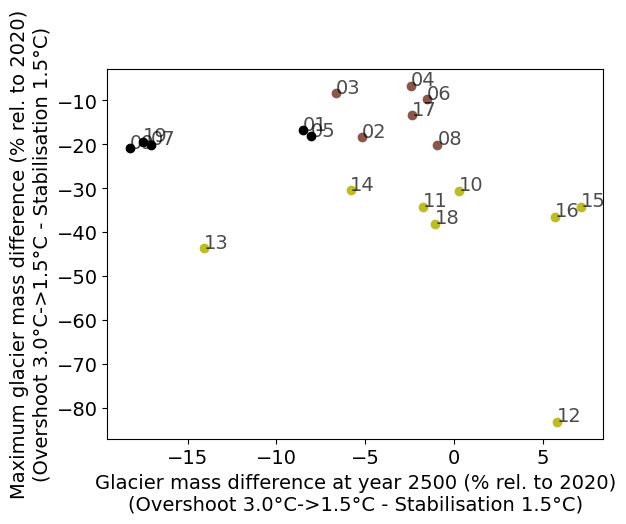

In [21]:

pd_t = pd.DataFrame([-end_vol_rel_diff_stab_oversh, -max_vol_rel_diff_stab_oversh]).T
pd_t['region'] = df_scenario_common_vol_rel_sel.rgi_reg
pd_t.index = pd_t.region
def plotlabel(xvar, yvar, label, ax=None):
    ax = plt.gca()
    ax.text(xvar-0.01, yvar+0.05, label, alpha=0.7, fontsize=14)

for c in np.arange(0,3,1):
    rgi_regs_sel = pd_clusters_all.loc[pd_clusters_all['manual_chosen_3_clusters']==c].index.values
    pd_t_sel = pd_t.loc[rgi_regs_sel]
    plt.plot(pd_t_sel[0], pd_t_sel[1],'o', color=cols[c])
pd_t.apply(lambda x: plotlabel(x[0],x[1], x.region, ax=ax), axis=1)
plt.xlabel('Glacier mass difference at year 2500 (% rel. to 2020)\n(Overshoot 3.0°C->1.5°C - Stabilisation 1.5°C)')
plt.ylabel('Maximum glacier mass difference (% rel. to 2020)\n(Overshoot 3.0°C->1.5°C - Stabilisation 1.5°C)')

Text(0, 0.5, 'Stabilisation vs Overshoot glacier mass differences\n(maximum - year 2500 difference, % rel. to 2020)')

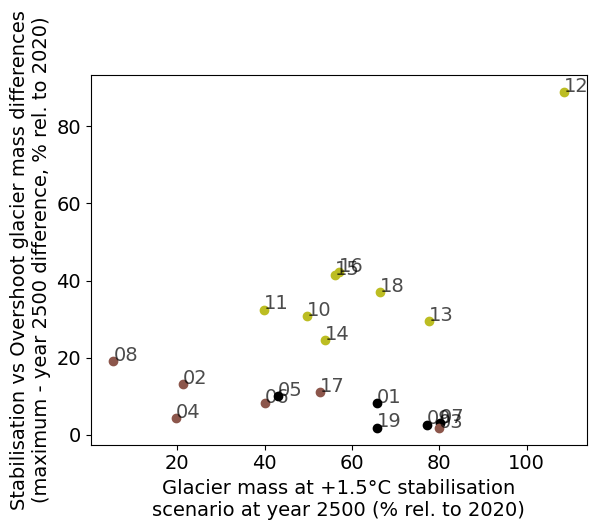

In [22]:
pd_t = pd.DataFrame([end_vol_stabT15, max_vol_rel_diff_stab_oversh-end_vol_rel_diff_stab_oversh]).T
pd_t['region'] = df_scenario_common_vol_rel_sel.rgi_reg
pd_t.index = pd_t.region
def plotlabel(xvar, yvar, label, ax=None):
    ax = plt.gca()
    ax.text(xvar-0.01, yvar+0.05, label, alpha=0.7, fontsize=14)

for c in np.arange(0,3,1):
    rgi_regs_sel = pd_clusters_all.loc[pd_clusters_all['manual_chosen_3_clusters']==c].index.values
    pd_t_sel = pd_t.loc[rgi_regs_sel]
    plt.plot(pd_t_sel[0], pd_t_sel[1],'o', color=cols[c])

pd_t.apply(lambda x: plotlabel(x[0],x[1], x.region, ax=ax), axis=1)
plt.xlabel('Glacier mass at +1.5°C stabilisation\nscenario at year 2500 (% rel. to 2020)')
plt.ylabel('Stabilisation vs Overshoot glacier mass differences\n(maximum - year 2500 difference, % rel. to 2020)')

**cluster map individually for each cluster (just for talks)**

In [36]:
cols

[(0.0, 0.0, 0.0),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333)]

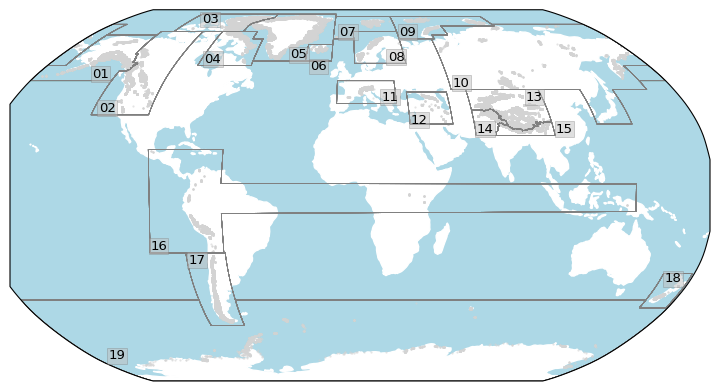

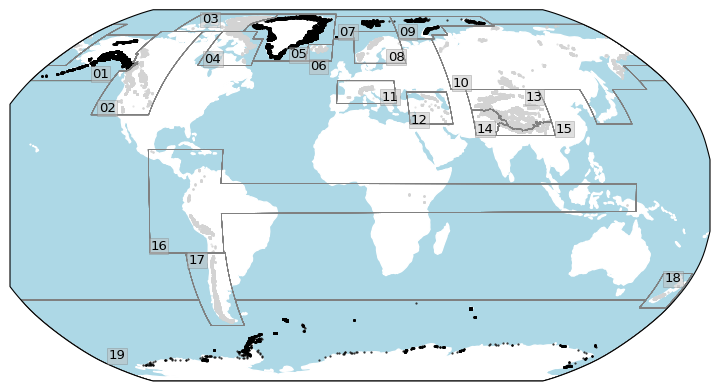

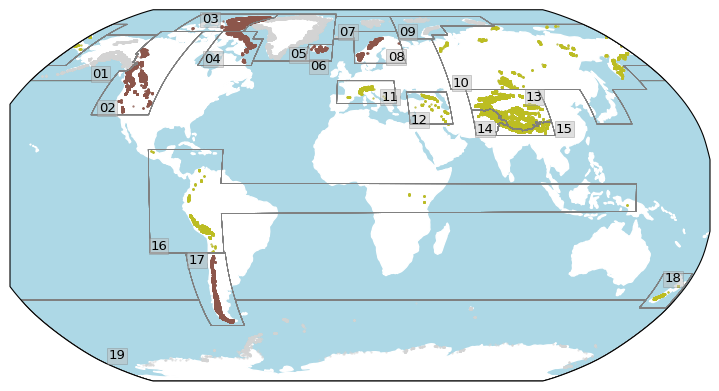

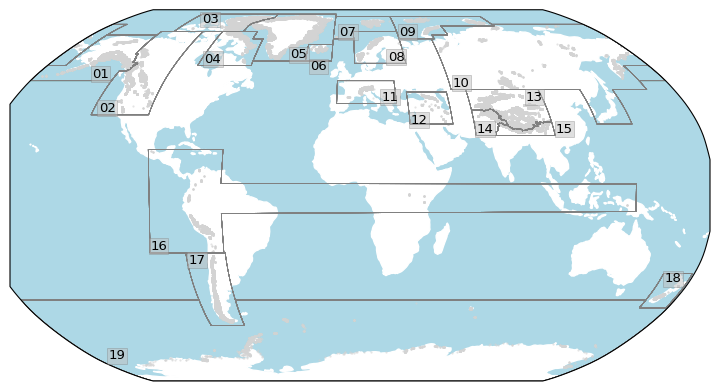

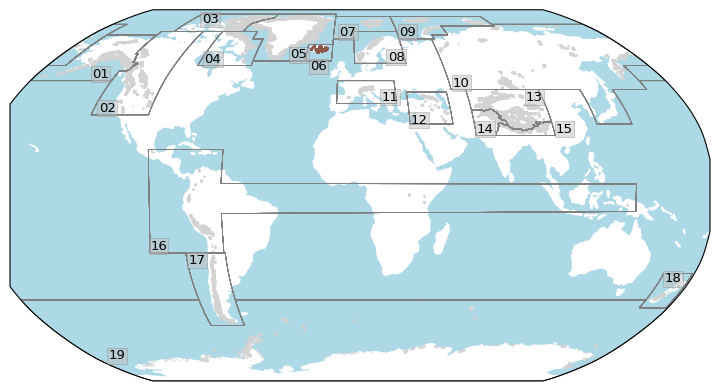

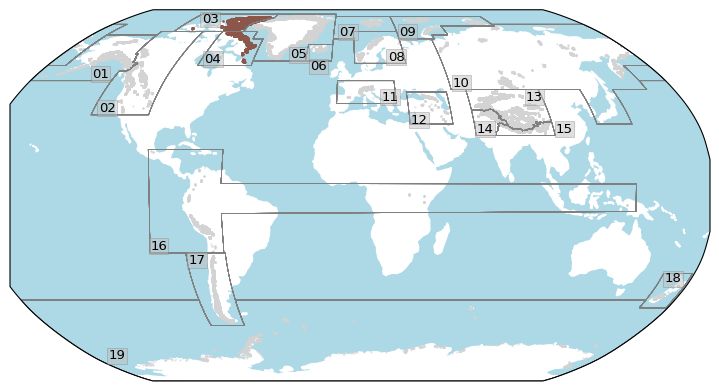

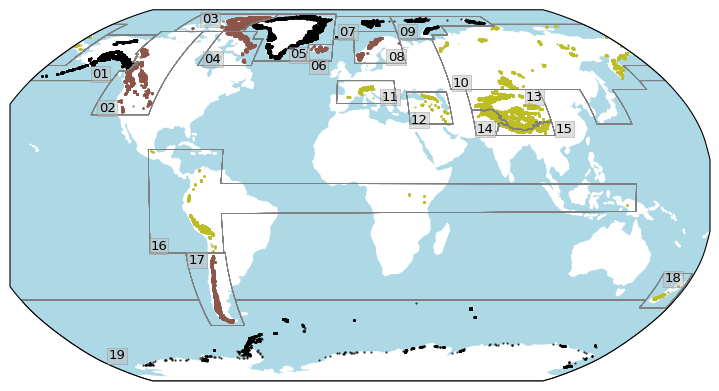

In [37]:
plt.rc('font', size=14)
k = 4

for cc in [-1,0,1,3,4, 5, 'all']:
    show_temp = False
    pie_scenarios = 2

    fig = plt.figure() #figsize=(20,8))
    # Add background image
    ax_background = fig.add_axes([0,0,1,1], projection=ccrs.Robinson())
    ax_background.patch.set_facecolor('lightblue')
    ax_background.get_yaxis().set_visible(False)
    ax_background.get_xaxis().set_visible(False)
    #    ax_background.coastlines(color='white')
    ax_background.add_feature(cartopy.feature.LAND, color='white')


    # Add RGI glacier outlines

    if add_rgi_glaciers:
        # if I do that here: 
        # **somehow only the glaicers of one RGI region are visible**
        #shape_feature = ShapelyFeature(Reader(rgi_shp_fn).geometries(), ccrs.Robinson(),alpha=1,facecolor='indigo',linewidth=0.35,edgecolor='indigo')
        #ax_background.add_feature(shape_feature)
        # instead aplly that here ... 
        for c in np.arange(0,3,1):
            df_rgi6g_sel = df_rgi6g.loc[df_rgi6g[clustering_opt]==c]
            ax_background.scatter(df_rgi6g_sel.CenLon.values, df_rgi6g_sel.CenLat.values,
                                  #color=cols[c],
                                  color='lightgrey',
                                  s=0.3, alpha =0.6,
                                  transform=ccrs.PlateCarree());
            if cc ==c or (cc==1 and c==2):
                df_rgi6g_sel = df_rgi6g.loc[df_rgi6g[clustering_opt]==c]
                ax_background.scatter(df_rgi6g_sel.CenLon.values, df_rgi6g_sel.CenLat.values,
                                      color=cols[c],
                                      #color='lightgrey',
                                      s=0.3, alpha =0.8,
                                      transform=ccrs.PlateCarree());
            elif cc==4: # iceland
                df_rgi6g_sel = df_rgi6g.loc[df_rgi6g.O1Region == '06']
                ax_background.scatter(df_rgi6g_sel.CenLon.values, df_rgi6g_sel.CenLat.values,
                                      color=cols[1],
                                      #color='lightgrey',
                                      s=0.3, alpha =0.8,
                                      transform=ccrs.PlateCarree());
            elif cc == 5: # Arctic Canada North and South
                df_rgi6g_sel = df_rgi6g.loc[(df_rgi6g.O1Region == '03') | (df_rgi6g.O1Region == '04')]
                ax_background.scatter(df_rgi6g_sel.CenLon.values, df_rgi6g_sel.CenLat.values,
                                      color=cols[1],
                                      #color='lightgrey',
                                      s=0.3, alpha =0.8,
                                      transform=ccrs.PlateCarree());
            elif cc == 'all':
                ax_background.scatter(df_rgi6g_sel.CenLon.values, df_rgi6g_sel.CenLat.values,
                      color=cols[c],
                      #color='lightgrey',
                      s=0.3, alpha =0.8,
                      transform=ccrs.PlateCarree());
    for en,rgi_reg in enumerate(df_scenario_common.rgi_reg):
        coords = coordinates[en]
        shape_feature = ShapelyFeature(Reader(rgi_regions_fn).geometries(), ccrs.Robinson(),facecolor="None", edgecolor='grey', alpha = 1, lw=0.4)
                                       #alpha=1,facecolor='None',linewidth=0.35,edgecolor='k')
        ax_background.add_feature(shape_feature)


    ### copied from fabis RGI6/7 code ....
    did10 = False
    for i, r in df_reg_shp_rgi7.iterrows():
        tx = r.min_x + 4
        ty = r.min_y 
        fs = 16
        t = r.o1region

        if t == '01':
            tx = r.min_x + 35
        if t == '03':
            tx = r.min_x + 15
            ty = r.min_y + 3
        if t == '05':
            tx = r.min_x + 40
        if t == '06':
            ty = r.min_y - 5.5
        if t == '08':
            tx = r.min_x + 20
        if t == '09':
            tx = r.min_x 
        if t == '11':
            tx = r.min_x + 24
        if t == '10':
            tx = r.min_x + 1
            ty = r.min_y + 15
            if not did10:
                did10 = True
                continue
        if t == '13':
            ty = r.min_y + 12
            tx = r.min_x + 30
        if t in ['14', '12', '16', '17']:
            tx = r.min_x 
        if t == '15':
            tx = r.min_x + 30
        if t == '17':
            ty = r.min_y + 26
        if t == '18':
            ty = r.min_y + 10
        if t == '19':
            ty = r.min_y + 10
        if t == '20':
            continue

        ax_background.text(tx, ty, t, transform=ccrs.PlateCarree(), 
                ha='left', va='bottom', fontsize=9.5,bbox=dict(facecolor='silver', edgecolor='grey',
                                                               pad=1, lw=0.5, alpha=0.5)
                          )


    #plt.savefig('2x_worldmap_cluster_volume_v0.png')
    #plt.savefig('figures/2x_worldmap_cluster_volume_v0.png')
    fig.set_size_inches(7, 4)

    fig.savefig(f'../figures/talk_figures/fig_3_only_worldmap_cluster_{cc}.png', dpi=300)


**other potential subplots**

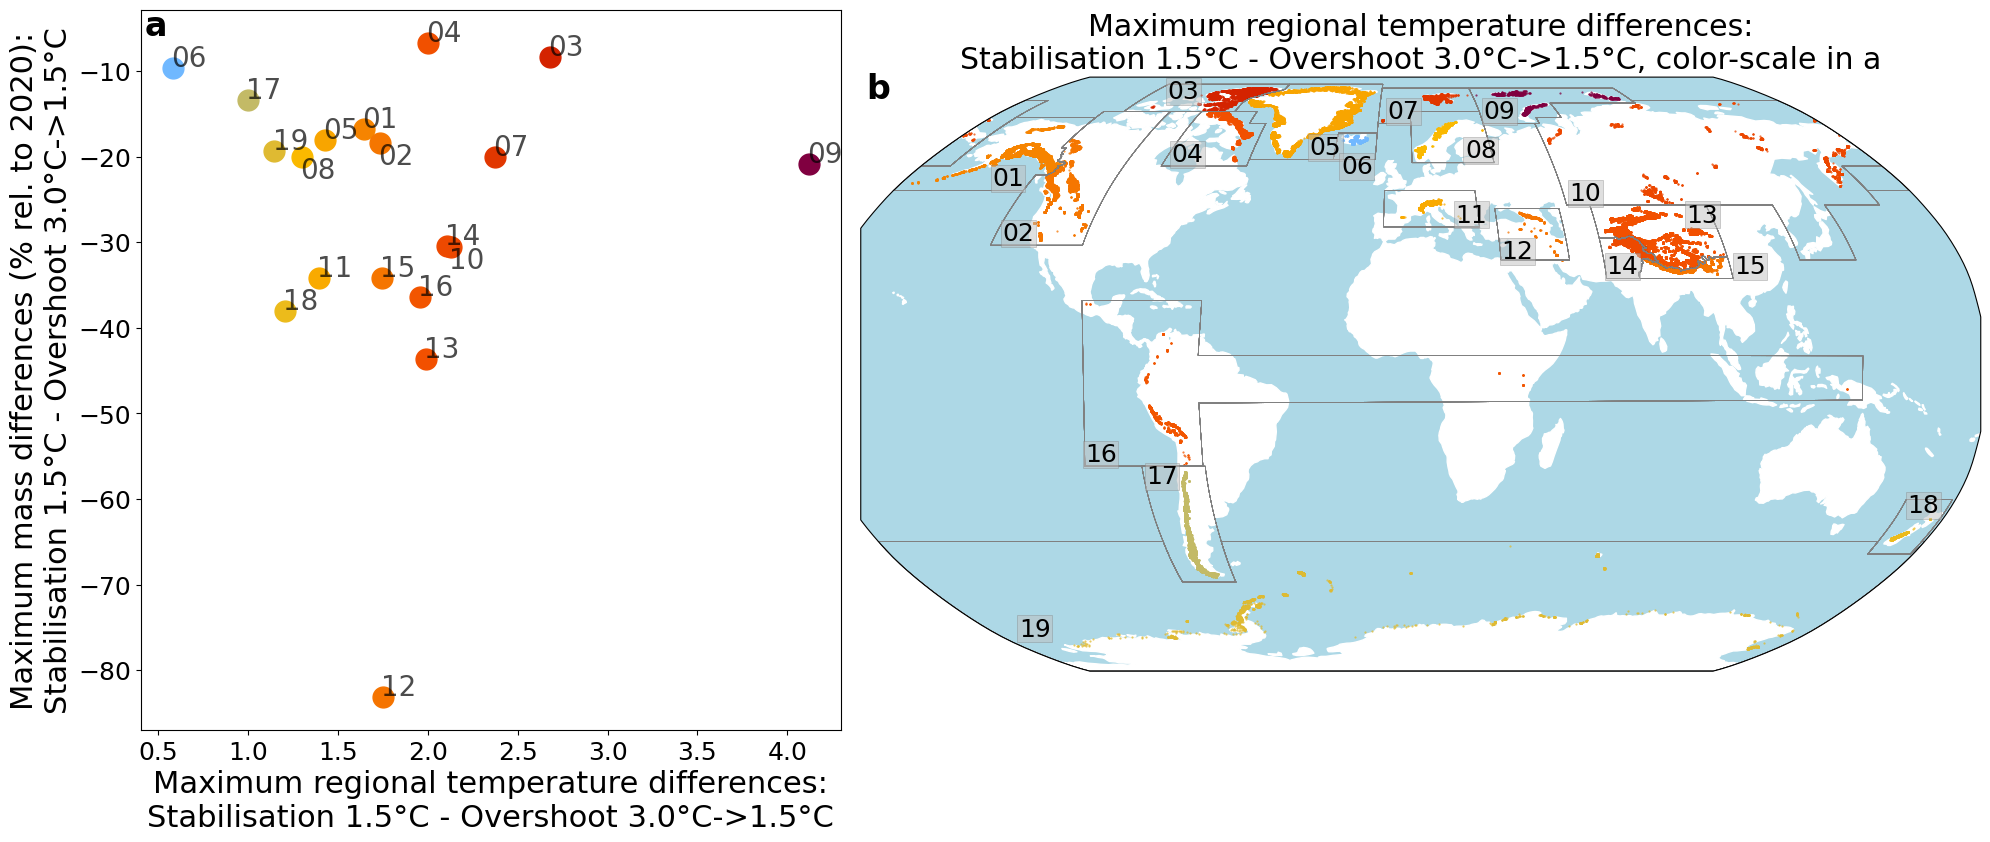

In [38]:
plt.rc('font', size=18)  

from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import MinMaxScaler
colors_icci_l3 = ['#70B8FF', '#FABB00', '#F25100', '#D42300', '#B3001E', '#800040']#, '#550066']#, '#2B084D'] #,
cmap_icci_3 = LinearSegmentedColormap.from_list('bins_100', colors_icci_l3, N=1000)
# IDEA --> Let's scale from 1.2 onwards
scaler = MinMaxScaler()
temp_ch_sel = np.arange(temp_ch_diff_oversh_stab_max.min(),temp_ch_diff_oversh_stab_max.max(),0.25)
scaler.fit(temp_ch_sel.reshape(-1,1))
cmap = cmap_icci_3

fig = plt.figure(figsize=(20,8))
# Add background image
ax_background = fig.add_axes([0.44,0.05,0.56,0.95], projection=ccrs.Robinson())
ax_background.patch.set_facecolor('lightblue')
ax_background.get_yaxis().set_visible(False)
ax_background.get_xaxis().set_visible(False)
#    ax_background.coastlines(color='white')
ax_background.add_feature(cartopy.feature.LAND, color='white')

# Add global boundary
#ax_global_patch = fig.add_axes([0.01,0.52,0.42,0.48], facecolor='white')
#ax_global_patch.get_yaxis().set_visible(False)
#ax_global_patch.get_xaxis().set_visible(False)

# Add RGI glacier outlines

if add_rgi_glaciers:
    # if I do that here: 
    # **somehow only the glaicers of one RGI region are visible**
    #shape_feature = ShapelyFeature(Reader(rgi_shp_fn).geometries(), ccrs.Robinson(),alpha=1,facecolor='indigo',linewidth=0.35,edgecolor='indigo')
    #ax_background.add_feature(shape_feature)
    # instead aplly that here ... 
    for reg, temp_ch in zip(df_rgi6g['O1Region'].unique(),temp_ch_diff_oversh_stab_max): #p.arange(0,6,1):
        #df_rgi6g_sel = df_rgi6g.loc[df_rgi6g[clustering_opt]==c]
        df_rgi6g_sel = df_rgi6g.loc[df_rgi6g['O1Region'] ==reg]
        ax_background.scatter(df_rgi6g_sel.CenLon.values, df_rgi6g_sel.CenLat.values,
                              color=cmap(scaler.transform(temp_ch.reshape(-1,1))),
                              #color='lightgrey',
                              s=0.3, alpha =0.8,
                              transform=ccrs.PlateCarree());
for en,rgi_reg in enumerate(df_scenario_common.rgi_reg):
    coords = coordinates[en]
    shape_feature = ShapelyFeature(Reader(rgi_regions_fn).geometries(), ccrs.Robinson(),facecolor="None", edgecolor='grey', alpha = 1, lw=0.4)
                                   #alpha=1,facecolor='None',linewidth=0.35,edgecolor='k')
    ax_background.add_feature(shape_feature)


### copied from fabis RGI6/7 code ....
did10 = False
for i, r in df_reg_shp_rgi7.iterrows():
    tx = r.min_x + 4
    ty = r.min_y 
    fs = 16
    t = r.o1region

    if t == '01':
        tx = r.min_x + 35
    if t == '03':
        tx = r.min_x + 15
        ty = r.min_y + 3
    if t == '05':
        tx = r.min_x + 40
    if t == '06':
        ty = r.min_y - 5.5
    if t == '08':
        tx = r.min_x + 20
    if t == '09':
        tx = r.min_x 
    if t == '11':
        tx = r.min_x + 24
    if t == '10':
        tx = r.min_x + 1
        ty = r.min_y + 15
        if not did10:
            did10 = True
            continue
    if t == '13':
        ty = r.min_y + 12
        tx = r.min_x + 30
    if t in ['14', '12', '16', '17']:
        tx = r.min_x 
    if t == '15':
        tx = r.min_x + 30
    if t == '17':
        ty = r.min_y + 26
    if t == '18':
        ty = r.min_y + 10
    if t == '19':
        ty = r.min_y + 10
    if t == '20':
        continue

    ax_background.text(tx, ty, t, transform=ccrs.PlateCarree(), 
            ha='left', va='bottom', fontsize=18,bbox=dict(facecolor='silver', edgecolor='grey',
                                                           pad=1, lw=0.5, alpha=0.5)
                      )
ax_background.set_title('Maximum regional temperature differences:\nStabilisation 1.5°C - Overshoot 3.0°C->1.5°C, color-scale in a')
#################

reg_pie_sizes=[]
for c in np.arange(0,kk,1):
    pie_size = 0.27
    reg_pie_sizes.append(pie_size)
fac=1.25
ax = fig.add_axes([0.08,0.08,0.35,0.9], facecolor='white') # 0.01 

pd_t = pd.DataFrame([temp_ch_diff_oversh_stab_max,-max_vol_rel_diff_stab_oversh]).T
pd_t['region'] = df_scenario_common_vol_rel_sel.rgi_reg
def plotlabel(xvar, yvar, label, ax=None):
    ax.text(xvar-0.01, yvar+0.2, label, alpha=0.7, fontsize=20)
def plotlabel_b(xvar, yvar, label, ax=None):
    ax.text(xvar-0.01, yvar-2.5, label, alpha=0.7, fontsize=20)
for j, temp_ch in enumerate(temp_ch_diff_oversh_stab_max): #p.arange(0,6,1):
    ax.plot(temp_ch, pd_t[1][j],'o', ms =15,
            color=cmap(scaler.transform(temp_ch.reshape(-1,1))).flatten())
pd_t.index = pd_t.region  
drop_rgis = ['08','02',#'19',
             '10']
pd_t.drop(drop_rgis).apply(lambda x: plotlabel(x[0],x[1], x.region, ax=ax), axis=1)
pd_t.loc[drop_rgis].apply(lambda x: plotlabel_b(x[0],x[1], x.region, ax=ax), axis=1)

ax.set_xlabel('Maximum regional temperature differences:\nStabilisation 1.5°C - Overshoot 3.0°C->1.5°C', fontsize=22)
ax.set_ylabel('Maximum mass differences (% rel. to 2020):\nStabilisation 1.5°C - Overshoot 3.0°C->1.5°C', fontsize=22)
num_text_x = 0.005
for j,axi in enumerate([ax, ax_background]):
    num_text_y = 0.965
    axi.text(num_text_x, num_text_y,
             num_dict[j], fontsize=24, weight='bold', 
             transform=axi.transAxes)


In [39]:
k = 4
import scipy
# linear regression over all regions
print(scipy.stats.linregress(pd_t[0],pd_t[1]))
# **linear regression just on those with regrowth --> yellow cluster iii)**
pd_t_3 = pd_t.loc[pd_clusters_all[f'kmeans_{k}clusters_diff_oversh'] == 1]
print(scipy.stats.linregress(pd_t_3[0],pd_t_3[1]))

LinregressResult(slope=-0.15027704010474127, intercept=-26.182410169373483, rvalue=-0.006523189431923796, pvalue=0.978855603293578, stderr=5.587260766338937, intercept_stderr=10.8851910651697)
LinregressResult(slope=5.109310345742935, intercept=-50.45732207827929, rvalue=0.09778287661606436, pvalue=0.8178224416394895, stderr=21.229394493616805, intercept_stderr=38.442164967473204)


**both not significant!!!**

### Here we use some additional regional characteristics that got estimated by the GMIP3 study (in preparation) 

In [40]:
for column in  ['regrowth_overshoot_study','diff_yr_2500_overshoot_study','maximum_difference_overshoot_study', 'end_vol_stabT15']:
    pd_gmip3_stats[column] = pd_rgi_reg_stats[column].values

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


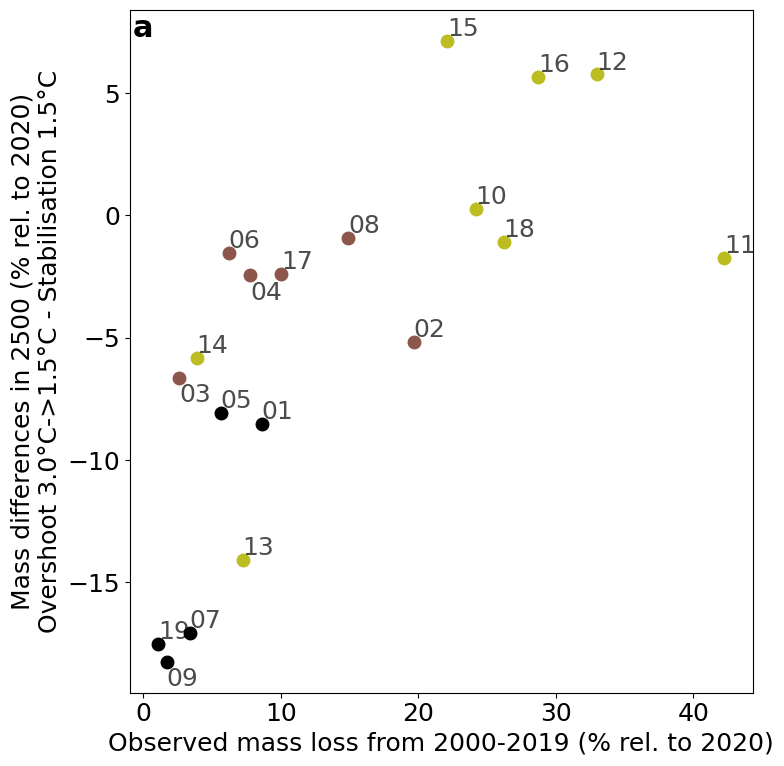

In [41]:

    
def plotlabel_d(xvar, yvar, label, ax=None):
    ax.text(xvar-0.01, yvar+0.2, label, alpha=0.7, fontsize=18)
def plotlabel_bd(xvar, yvar, label, ax=None):
    ax.text(xvar-0.01, yvar-1, label, alpha=0.7, fontsize=18)

    
plt.figure(figsize=(8,8))

ax = plt.gca()

axs=[ax]
xx = '20yr_regional_dvol_dt_2000_2019_vs_2020_vol_%'
yy = 'diff_yr_2500_overshoot_study'

for c in np.arange(0,3,1):
    rgi_regs_sel = pd_clusters_all.loc[pd_clusters_all[f'manual_chosen_3_clusters']==c].index.values
    pd_t_sel = pd_gmip3_stats.loc[rgi_regs_sel]
    ax.plot(pd_t_sel[xx], pd_t_sel[yy],'o', ms=9, color=cols[c])
drops = ['03','04','09'] #,'10','08']
pd_gmip3_stats.drop(drops).apply(lambda x: plotlabel_d(x[xx],x[yy], x.region, ax=ax), axis=1)
pd_gmip3_stats.loc[drops].apply(lambda x: plotlabel_bd(x[xx],x[yy], x.region, ax=ax), axis=1)

ax.set_ylabel('Mass differences in 2500 (% rel. to 2020)\nOvershoot 3.0°C->1.5°C - Stabilisation 1.5°C', fontsize=18)
ax.set_xlabel('Observed mass loss from 2000-2019 (% rel. to 2020)')

num_text_x = 0.005
for j,axi in enumerate(axs):
    num_text_y = 0.96
    axi.text(num_text_x, num_text_y,
             num_dict[j], fontsize=22, weight='bold', 
             transform=axi.transAxes)

plt.tight_layout()

#plt.savefig('figures/2_worldmap_appendix_subplot_2024-02-08.png')

/home/users/lschuster/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


<AxesSubplot:title={'center':'spearman rank'}>

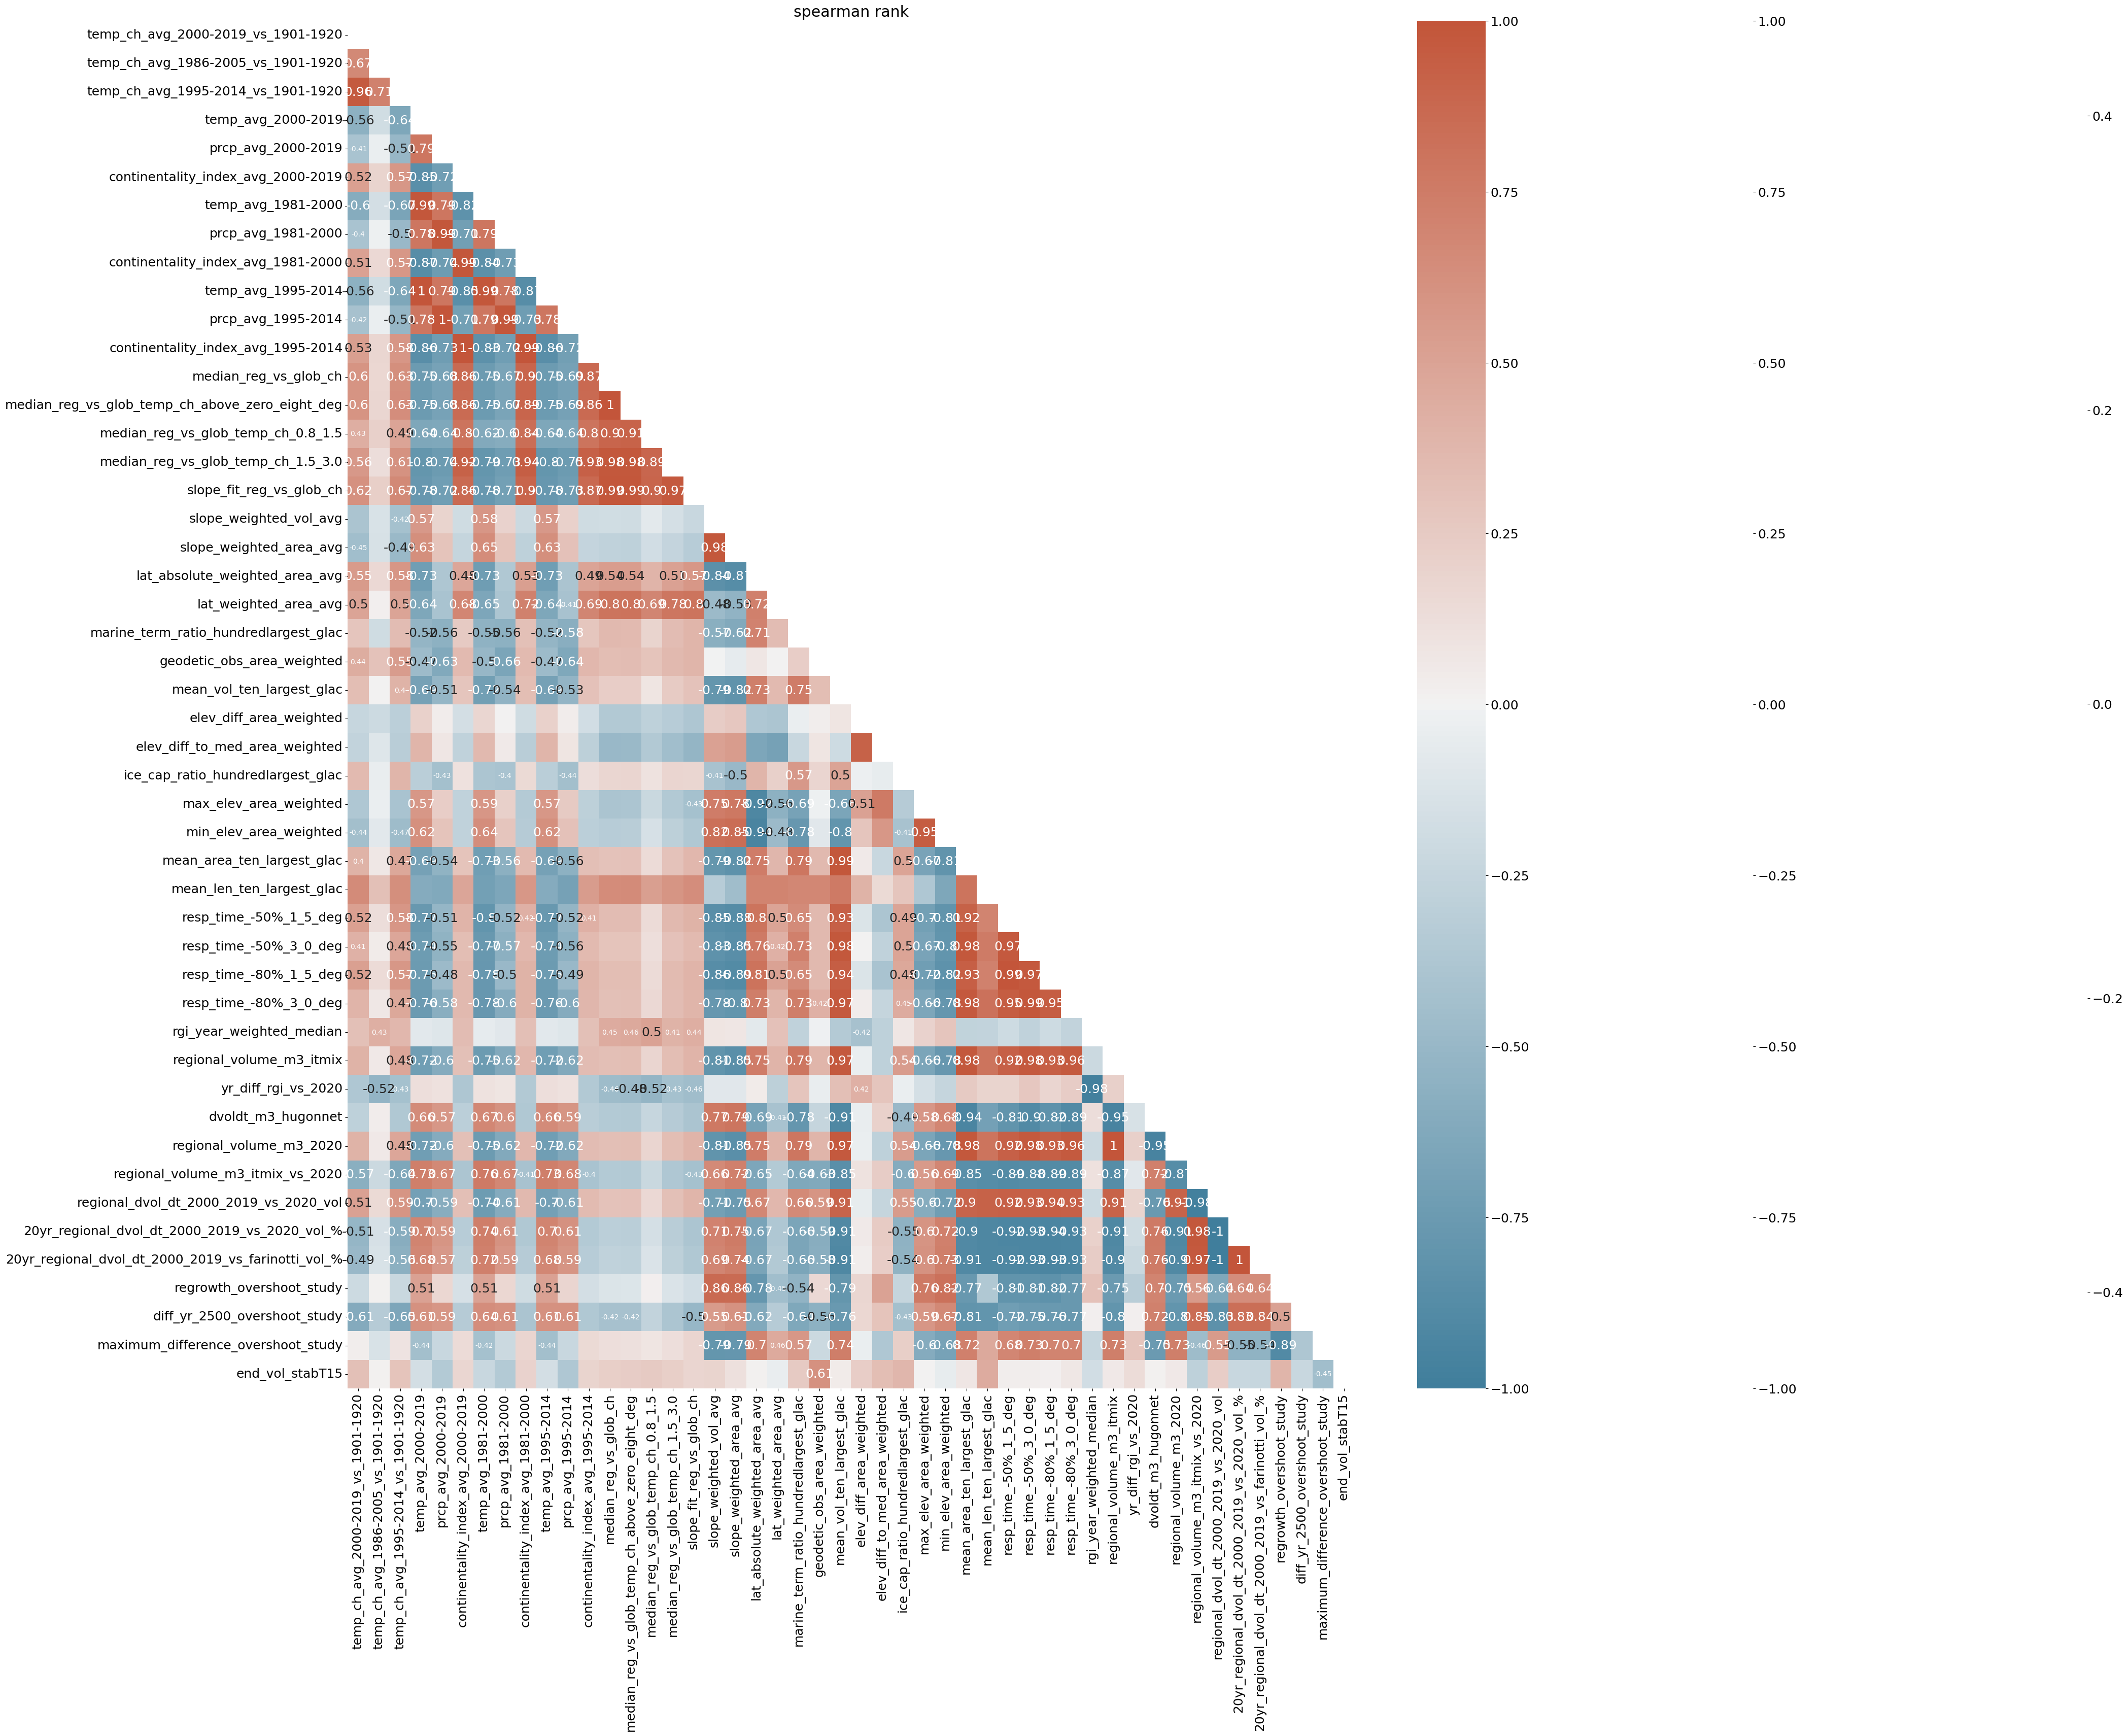

In [42]:
#Correlation between different variables
#
from scipy.stats import pearsonr, spearmanr

df_sel = pd_gmip3_stats.iloc[2:].reset_index(drop=True)#[columns_sel3]
corr = df_sel.corr(method='spearman') # df_sel.corr()
#
# Set up the matplotlib plot configuration
#
f, ax = plt.subplots(figsize=(50, 35))
#
plt.title('spearman rank')
# Generate a mask for upper traingle
#
mask = np.triu(np.ones_like(corr, dtype=bool))
#
# Configure a custom diverging colormap
#
cmap = sns.diverging_palette(230, 20, as_cmap=True)
#
# Draw the heatmap
#
# Create an empty matrix to store p-values
num_cols = len(df_sel.columns)
p_values = np.zeros((num_cols, num_cols))

# Calculate p-values for each pair of columns
for i, col1 in enumerate(df_sel.columns):
    for j, col2 in enumerate(df_sel.columns):
        corr_coef, p_value = spearmanr(df_sel[col1], df_sel[col2])
        p_values[i][j] = p_value

# Convert the matrix to a DataFrame for better visualization
p_values_df = pd.DataFrame(p_values, columns=df_sel.columns, index=df_sel.columns)

sns.heatmap(corr[(p_values_df<0.1)&(p_values_df>=0.05)],annot=True, mask = mask, cmap=cmap, annot_kws={'fontsize':10}, alpha =0)
sns.heatmap(corr[p_values_df<0.05],annot=True, mask = mask, cmap=cmap, annot_kws={'fontsize':18}, alpha =0)
sns.heatmap(corr, annot=False, mask = mask, cmap=cmap)


Text(0.5, 0, 'Years when 80% of change occurs (GlacierMIP3)')

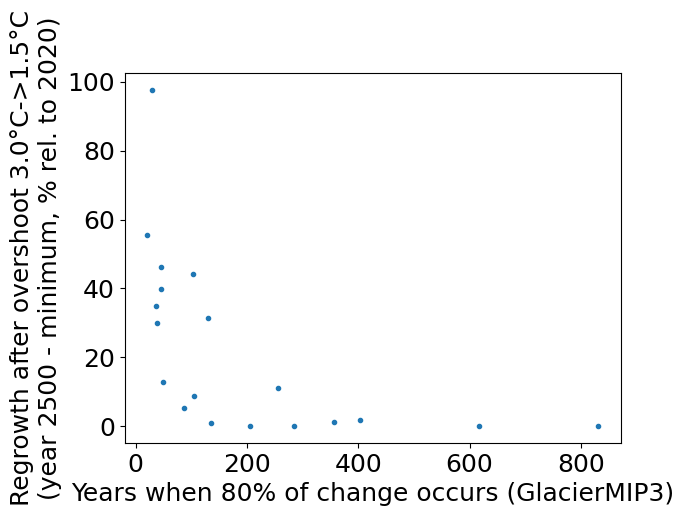

In [43]:
plt.plot(pd_gmip3_stats['resp_time_-80%_1_5_deg'],pd_gmip3_stats['regrowth_overshoot_study'], '.')
plt.ylabel('Regrowth after overshoot 3.0°C->1.5°C\n(year 2500 - minimum, % rel. to 2020)', fontsize=18)
plt.xlabel('Years when 80% of change occurs (GlacierMIP3)')


In [44]:
spearmanr(pd_gmip3_stats[['geodetic_obs_area_weighted','end_vol_stabT15']].dropna()['geodetic_obs_area_weighted'],
        pd_gmip3_stats[['geodetic_obs_area_weighted','end_vol_stabT15']].dropna()['end_vol_stabT15'])

SpearmanrResult(correlation=0.5543859649122806, pvalue=0.013768957045708036)

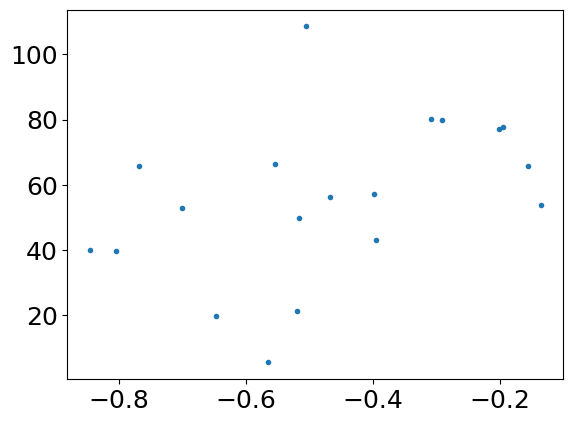

In [45]:
plt.plot(pd_gmip3_stats['geodetic_obs_area_weighted'],pd_gmip3_stats['end_vol_stabT15'], '.')


#### Additional analysis on what we cluster and on the amount of clusters ... 

In [46]:

# this is an other approach where we take all projections from all scenarios and normalize them and cluster after that 
# normalized approach using all scenarios (not the difference)
# at the end we actually used the other approach... 
norm = True

pd_vol_all = df_scenario_common_vol_rel_sel.to_dataframe().reset_index() #df_vol_diff.to_dataframe().reset_index()
pd_vol_all['time_scenario'] = pd_vol_all['time'].astype(str)+pd_vol_all['scenario']
pd_vol_all = pd_vol_all[['rgi_reg','time_scenario','volume']].pivot(index='time_scenario',
                                                                    columns='rgi_reg', values='volume')
if norm: 
    pd_vol_all_norm = pd.DataFrame(normalize(pd_vol_all))
    pd_vol_all_norm = pd_vol_all_norm.T
    data_all = pd_vol_all_norm.values
    pregs = pd_vol_all.columns.values
    normadd = '_norm'
else:
    pd_vol_all = pd_vol_all.T
    data_all = pd_vol_all.values

    pregs = pd_vol_all.index
    normadd = '_no_norm'

# do we need to 
#for var in ['a_simple', 'b_simple']:
#    pd_exp_decay_fits_simple_5000[var+'_norm'] = sklearn.preprocessing.normalize([pd_exp_decay_fits_simple_5000[var].values]).squeeze()
#regions = pd_exp_decay_fits_simple_5000.rgi_reg.values
#data = pd_exp_decay_fits_simple_5000[['a_simple_norm', 'b_simple_norm']].values
# Perform K-meansa clustering
pd_clusters_all = pd.DataFrame(index=pregs)
wcss = {}
for k in [4,5,6]:

    if k == 7:
        kmeans = KMeans(n_clusters=k) #, random_state=42)
        labels = ['test']
        while np.any(labels!=np.array([1, 0, 3, 4, 1, 1, 3, 4, 3, 0, 0, 5, 2, 2, 2, 0, 1, 2, 3])):

            kmeans.fit(data_all)

            # Get the resulting centroids and labels
            centroids = kmeans.cluster_centers_
            labels = kmeans.labels_
    else:
        kmeans = KMeans(n_clusters=k,  n_init=100, max_iter=1000, random_state=42)
        labels = ['test']

        kmeans.fit(data_all)

        # Get the resulting centroids and labels
        centroids = kmeans.cluster_centers_
        labels = kmeans.labels_
        
    # Print the resulting centroids and labels
    print("Centroids:")
    print(centroids)
    print("Labels:")
    print(labels)
    wcss[f'kmeans_{k}clusters{normadd}'] = kmeans.inertia_


    pd_clusters_all[f'kmeans_{k}clusters{normadd}'] = labels

pd_clusters_all
print(wcss)

Centroids:
[[0.23048066 0.23047146 0.23047519 ... 0.22036254 0.22338188 0.13210717]
 [0.21788315 0.21789135 0.21789208 ... 0.22139917 0.2491206  0.3242561 ]
 [0.23764633 0.2376489  0.23764338 ... 0.1202981  0.10292796 0.06059177]
 [0.25374997 0.2537379  0.2537411  ... 0.4974087  0.40742007 0.26336977]]
Labels:
[1 2 1 2 0 1 1 2 1 2 2 3 0 0 0 0 1 0 1]
Centroids:
[[0.22821447 0.22820243 0.2282073  ... 0.07303011 0.05861957 0.04447193]
 [0.22715244 0.22713788 0.22714587 ... 0.19243824 0.21503729 0.2205518 ]
 [0.23768947 0.23769382 0.23768778 ... 0.21927148 0.21104188 0.10632996]
 [0.21538153 0.21539822 0.21539608 ... 0.23379755 0.25930318 0.34235835]
 [0.25374997 0.2537379  0.2537411  ... 0.4974087  0.40742007 0.26336977]]
Labels:
[1 0 3 0 1 3 3 0 3 2 2 4 2 2 2 2 1 1 3]
Centroids:
[[0.21670535 0.21671665 0.21671617 ... 0.23053816 0.25742388 0.33650464]
 [0.2419655  0.24196903 0.24196343 ... 0.20416747 0.18982722 0.08756879]
 [0.25374997 0.2537379  0.2537411  ... 0.4974087  0.40742007 0.263

0 ['05' '13' '14' '15' '16' '18']
1 ['01' '03' '06' '07' '09' '17' '19']
2 ['02' '04' '08' '10' '11']
3 ['12']
4 []
5 []
0 ['02' '04' '08']
1 ['01' '05' '17' '18']
2 ['10' '11' '13' '14' '15' '16']
3 ['03' '06' '07' '09' '19']
4 ['12']
5 []
0 ['01' '03' '06' '07' '09' '19']
1 ['10' '11' '14' '16']
2 ['12']
3 ['04' '05' '17']
4 ['02' '08']
5 ['13' '15' '18']


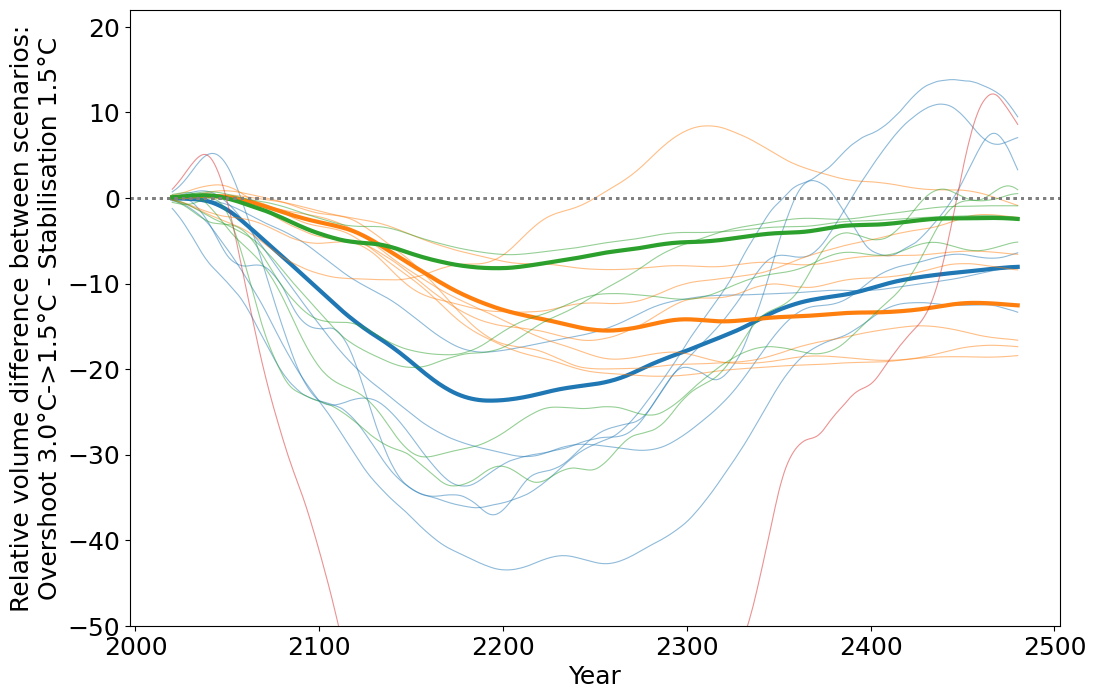

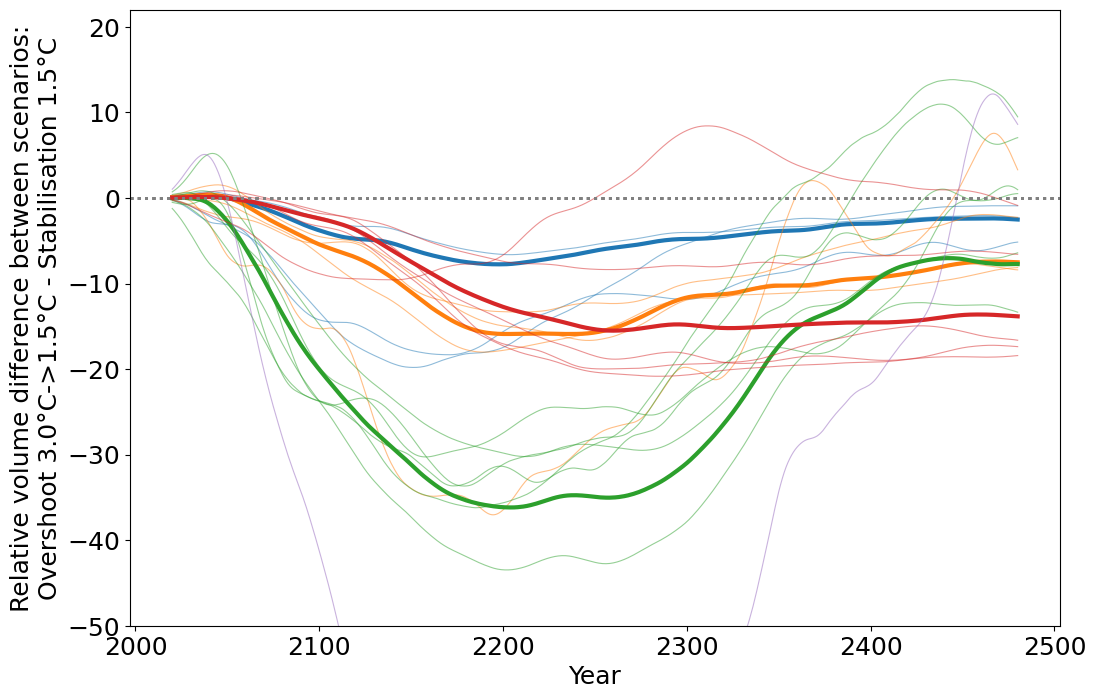

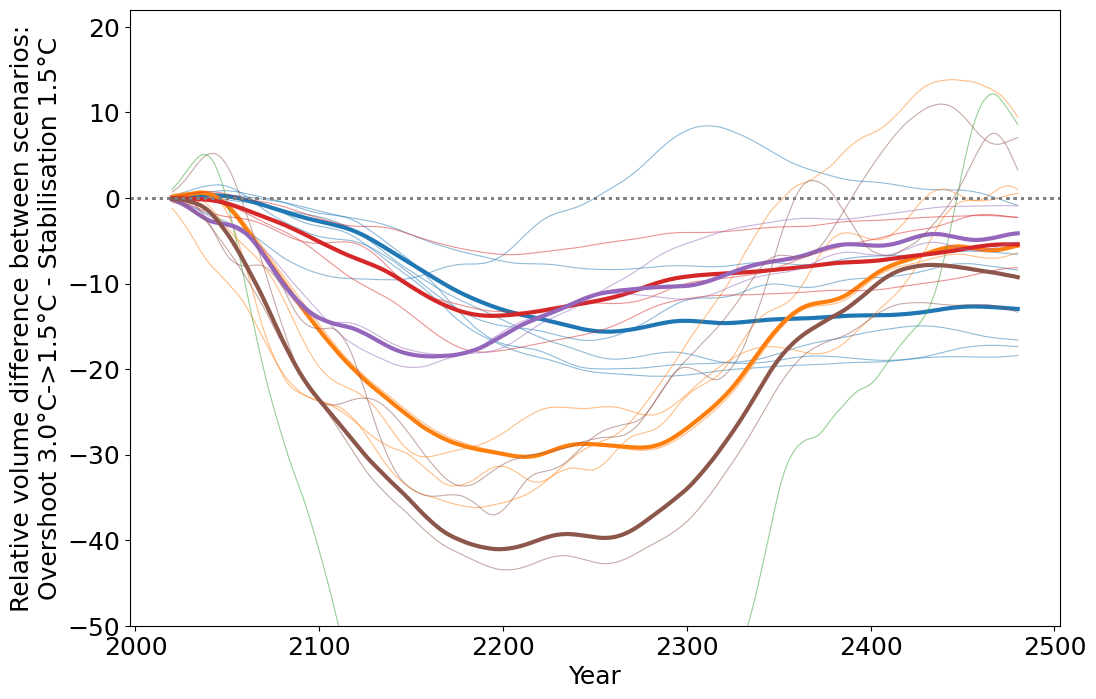

In [47]:
for k in [4,5,6]: 
    for s,p in zip(scenarios,palette):
        if s=='oversh_T30OS15':
            c_o = p
        elif s == 'stab_T15':
            c_s = p
    fig, axs = plt.subplots(1,1, figsize=(12,8), sharey=True)
    ax = axs
    for c in np.arange(0,6,1):
        #ax = axs[c]
        #plt.subplot(2,3,c+1)
        rgi_regs_sel = pd_clusters_all.loc[pd_clusters_all[f'kmeans_{k}clusters{normadd}']==c].index.values
        init_sel_sum = _df_scenario_common_rgi_reg.volume.sel(time=2020).sel(rgi_reg = rgi_regs_sel).sum(dim='rgi_reg')
        _sel = df_scenario_common_rgi_reg.volume.sel(rgi_reg=rgi_regs_sel)
        print(c, _sel.rgi_reg.values)
        
        #ax.set_title([c, _sel.rgi_reg.values], fontsize=12)
        df_scenario_common_cluster = _sel.sum(dim='rgi_reg')
        df_scenario_common_cluster_rel = 100*df_scenario_common_cluster/init_sel_sum
        #äfor s in color_scenario_poster.keys(): 
        sel_diff_rel = df_scenario_common_cluster_rel.sel(scenario='oversh_T30OS15').squeeze()-df_scenario_common_cluster_rel.sel(scenario='stab_T15').squeeze()
        if str(_sel.rgi_reg.values) != "['12']":
            ax.plot(df_scenario_common_cluster_rel.time,
                     sel_diff_rel.rolling(time=21,center=True).mean(),
                     color=f'C{c}', #color_scenario_poster[s],
                     lw=3)  
        sel_diff = df_scenario_common_vol_rel.sel(rgi_reg=rgi_regs_sel).sel(scenario='oversh_T30OS15')-df_scenario_common_vol_rel.sel(rgi_reg=rgi_regs_sel).sel(scenario='stab_T15')
        for r in _sel.rgi_reg:
            ax.plot(_sel.time,
                     sel_diff.sel(rgi_reg=r).squeeze().rolling(time=21, center=True).mean(), lw=0.8, color = f'C{c}', alpha = 0.5)
        ax.axhline(0, lw=2, color='grey',ls=':')
    ax.set_ylim([-50, 22])
    ax.set_ylabel('Relative volume difference between scenarios:\nOvershoot 3.0°C->1.5°C - Stabilisation 1.5°C')
    ax.set_xlabel('Year')

0 ['05' '13' '14' '15' '16' '18']
1 ['01' '03' '06' '07' '09' '17' '19']
2 ['02' '04' '08' '10' '11']
3 ['12']
4 []
5 []
0 ['02' '04' '08']
1 ['01' '05' '17' '18']
2 ['10' '11' '13' '14' '15' '16']
3 ['03' '06' '07' '09' '19']
4 ['12']
5 []
0 ['01' '03' '06' '07' '09' '19']
1 ['10' '11' '14' '16']
2 ['12']
3 ['04' '05' '17']
4 ['02' '08']
5 ['13' '15' '18']


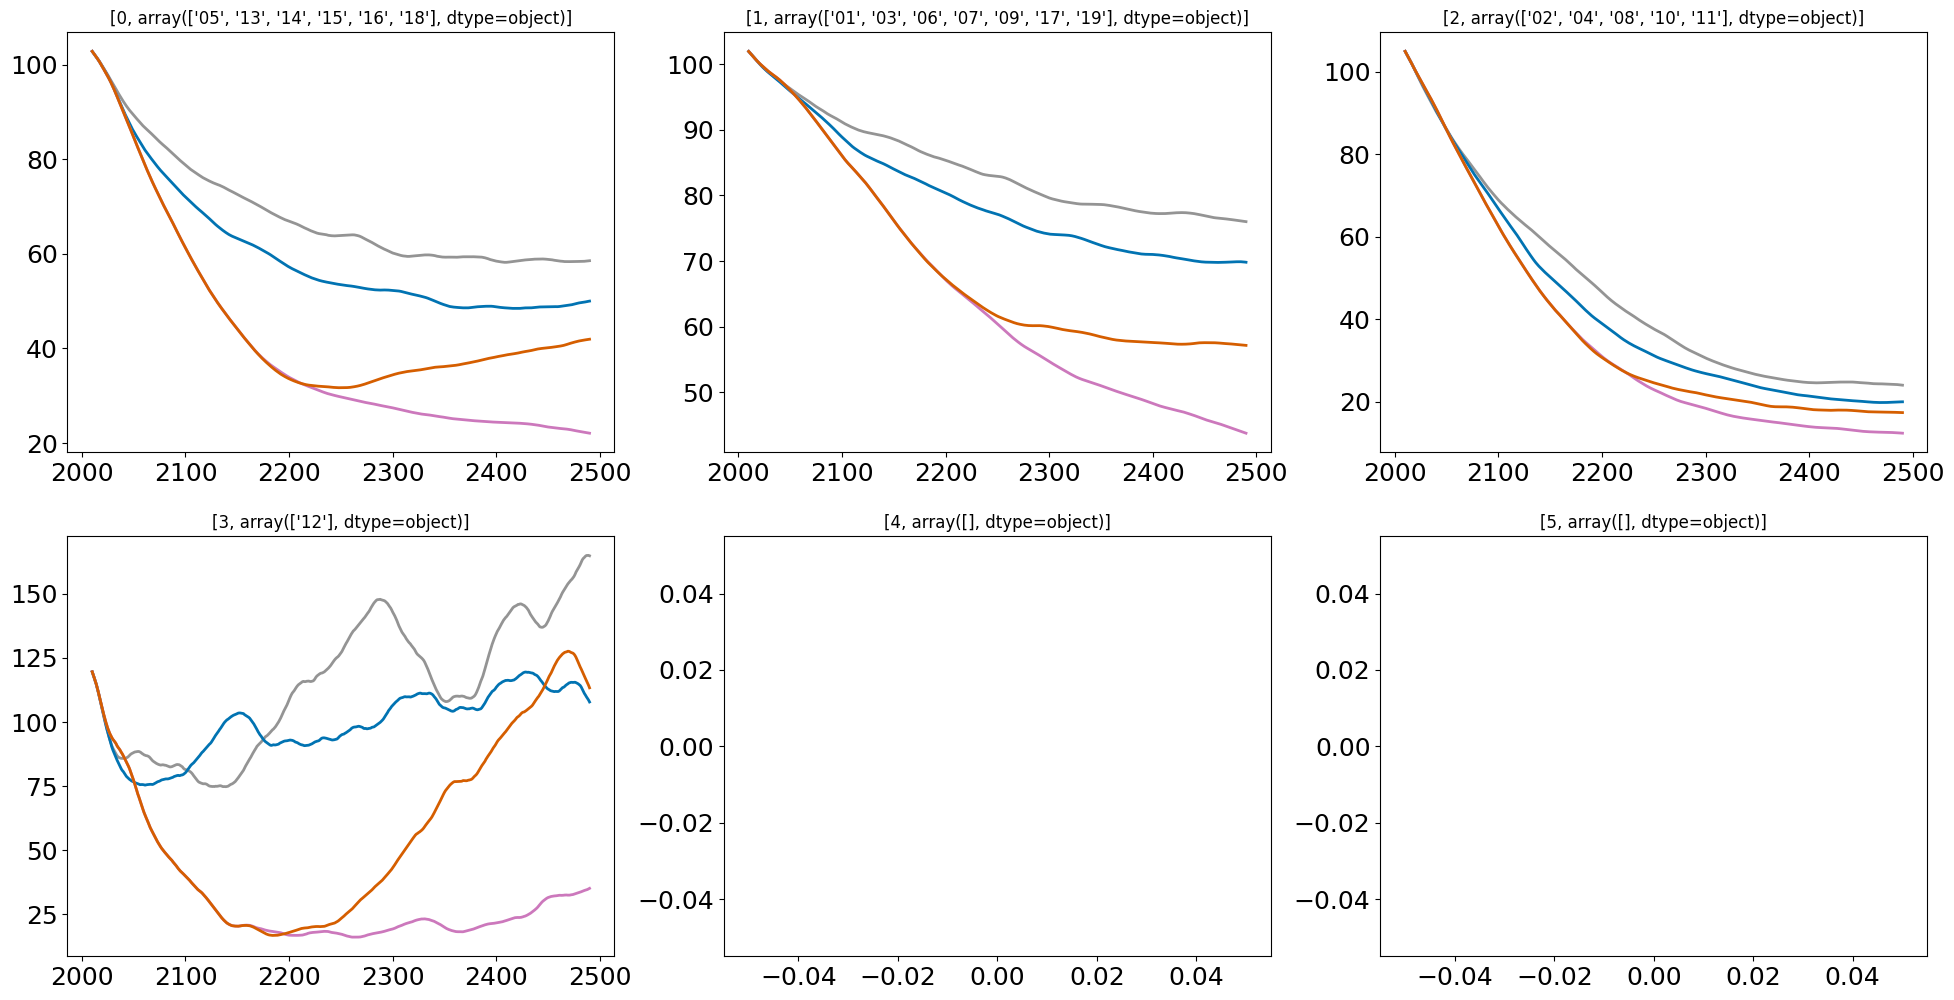

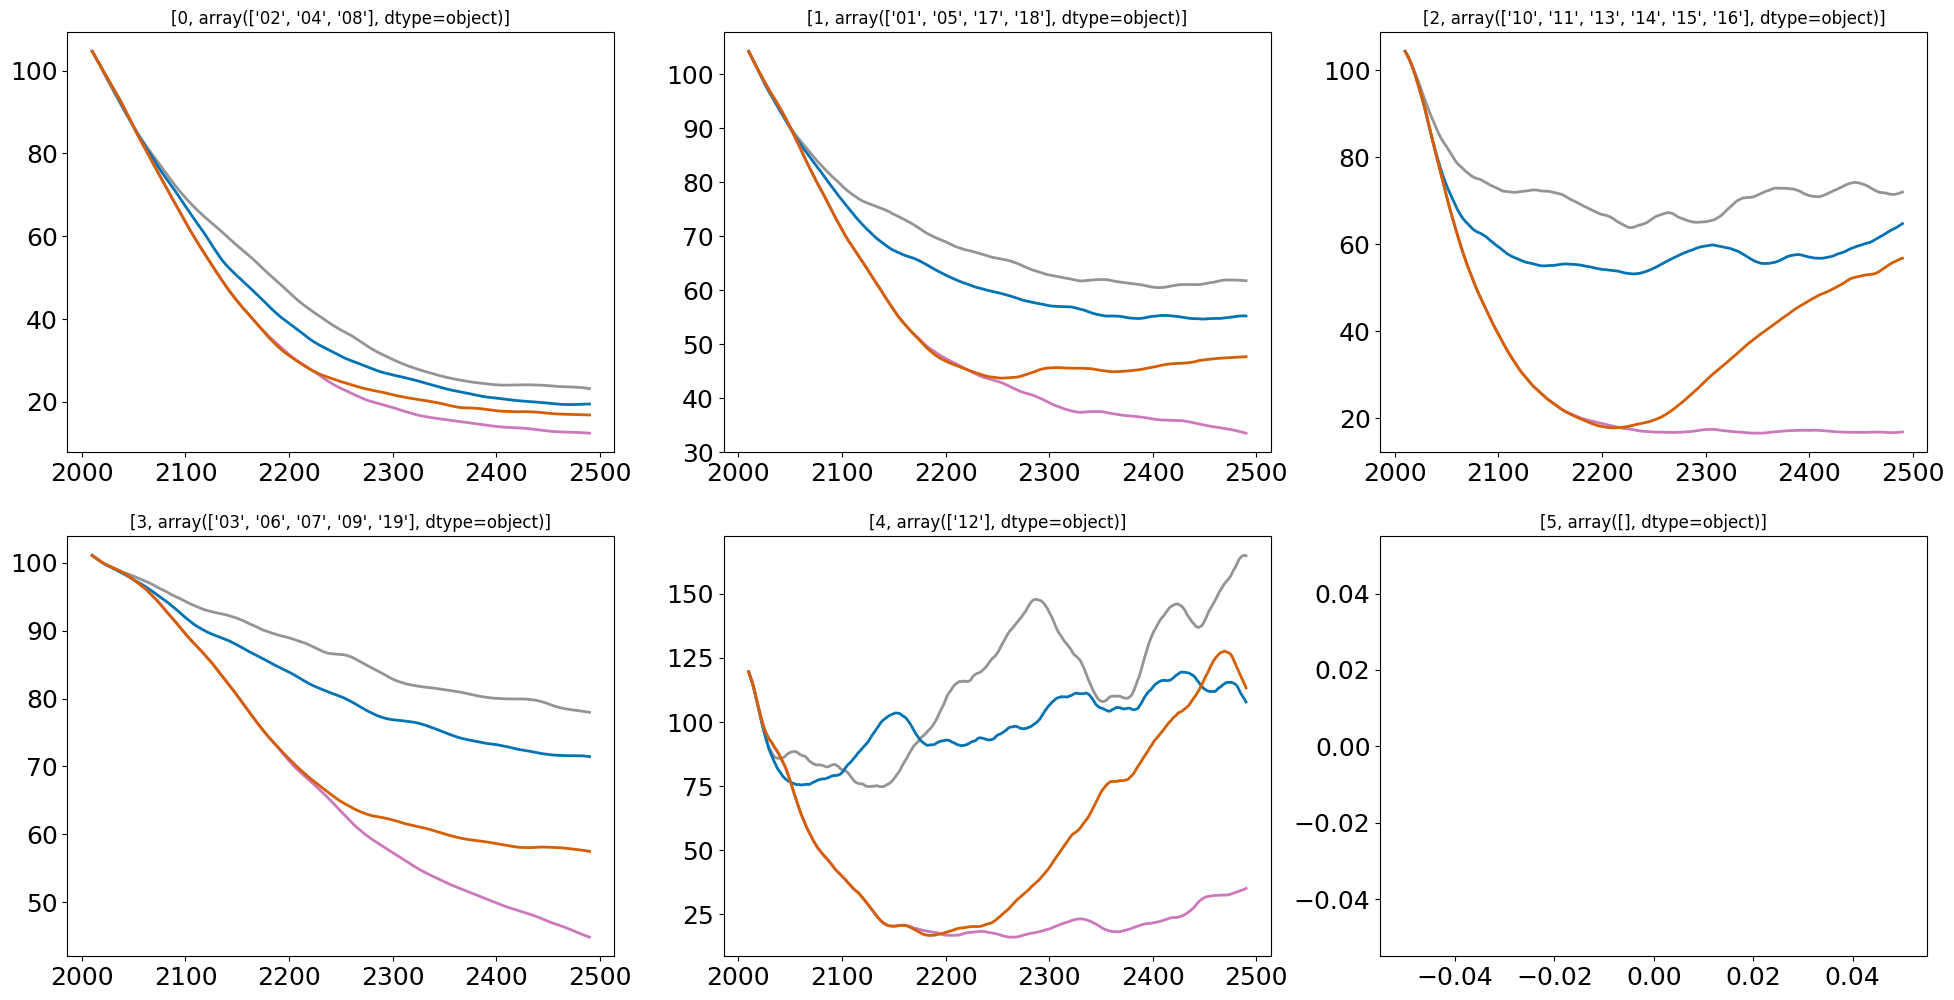

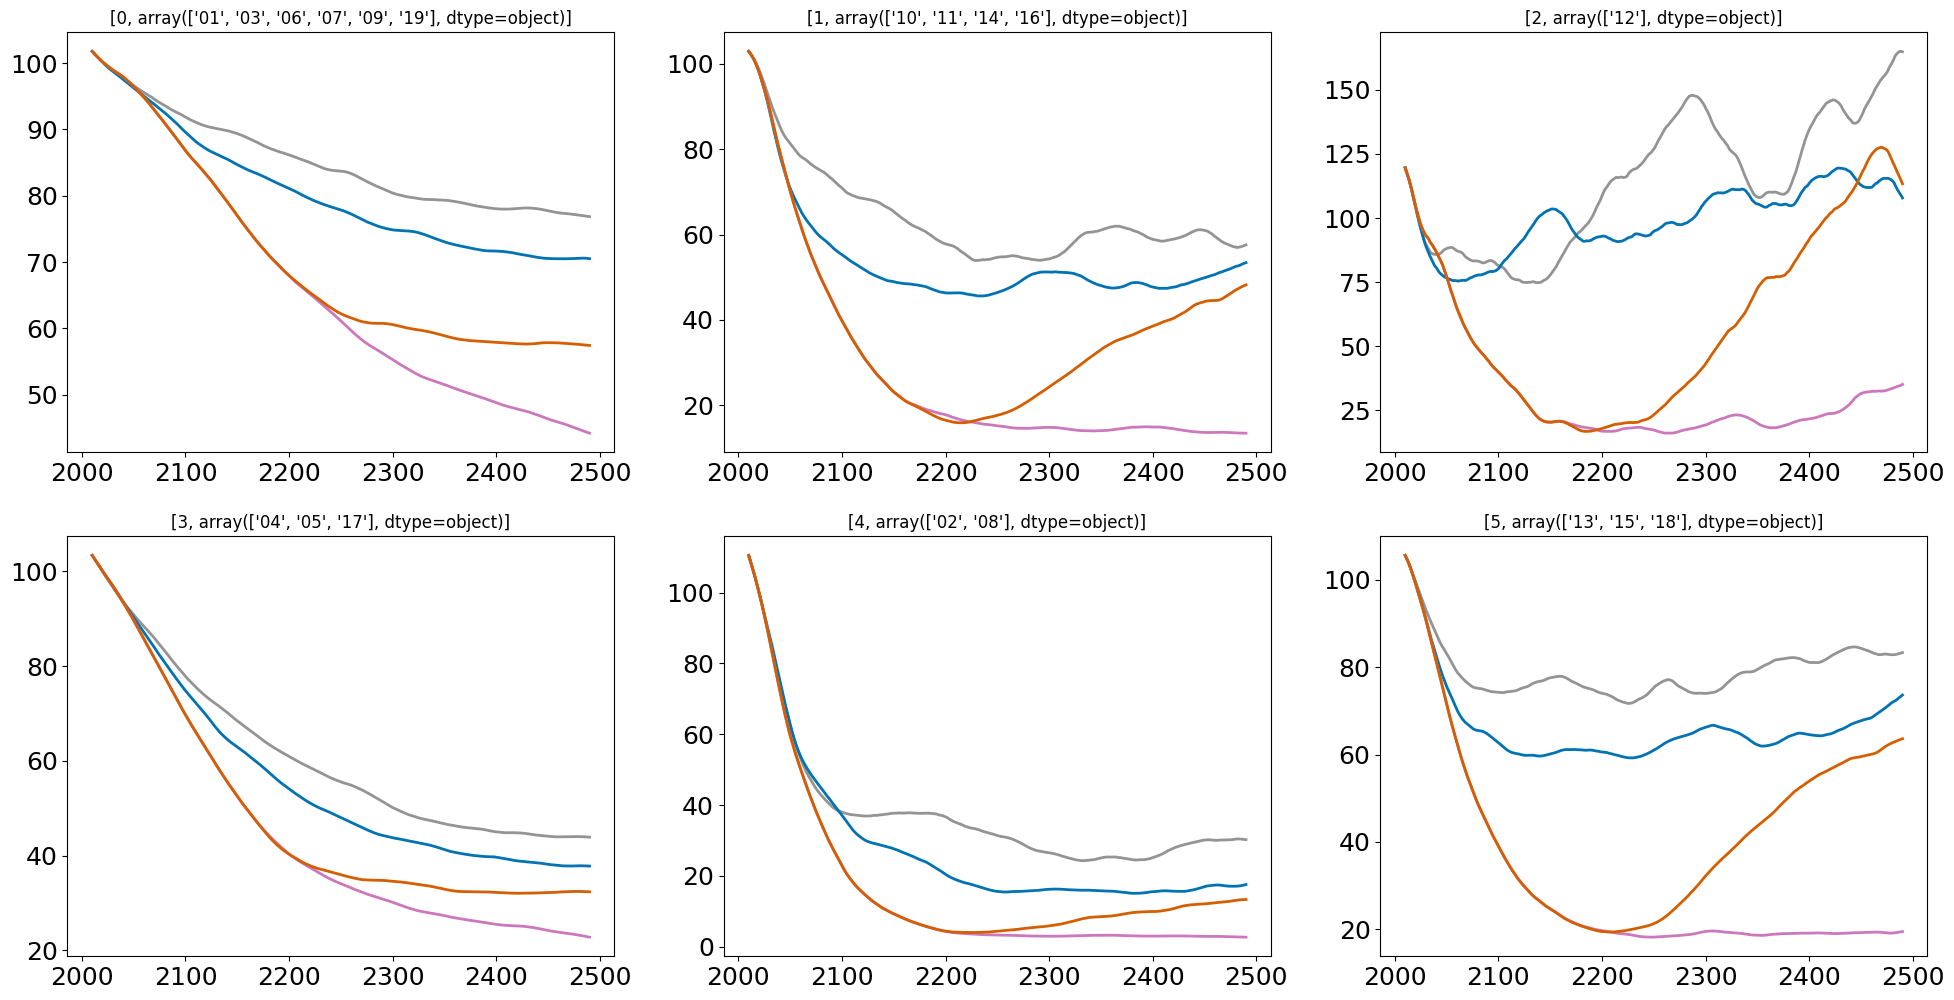

In [48]:
for k in [4,5,6]: 
    for s,p in zip(scenarios,palette):
        if s=='oversh_T30OS15':
            c_o = p
        elif s == 'stab_T15':
            c_s = p
    plt.figure(figsize=(24,12))
    for c in np.arange(0,6,1):
        plt.subplot(2,3,c+1)
        rgi_regs_sel = pd_clusters_all.loc[pd_clusters_all[f'kmeans_{k}clusters{normadd}']==c].index.values
        init_sel_sum = _df_scenario_common_rgi_reg.volume.sel(time=2020).sel(rgi_reg = rgi_regs_sel).sum(dim='rgi_reg')
        _sel = df_scenario_common_rgi_reg.volume.sel(rgi_reg=rgi_regs_sel)
        print(c, _sel.rgi_reg.values)
        plt.title([c, _sel.rgi_reg.values], fontsize=12)
        df_scenario_common_cluster = _sel.sum(dim='rgi_reg')
        df_scenario_common_cluster_rel = 100*df_scenario_common_cluster/init_sel_sum
        for s in color_scenario_poster.keys(): 
            plt.plot(df_scenario_common_cluster_rel.time, df_scenario_common_cluster_rel.sel(scenario=s).squeeze(), color=color_scenario_poster[s],
                    lw=2)    

**B: same approach as we actually chose for the final version (STAB_T15 - OVERSH_T30OS15), but here for four to six clusters!**

In [49]:
pd_vol_all_diff = (df_scenario_common_vol_rel_sel.sel(scenario='stab_T15') - df_scenario_common_vol_rel_sel.sel(scenario='oversh_T30OS15')).to_dataframe().reset_index()
pd_vol_all_diff = pd_vol_all_diff[['rgi_reg','time','volume']].pivot(index='time', columns='rgi_reg', values='volume')
pd_vol_all_diff = pd_vol_all_diff.T
data_all = pd_vol_all_diff.values
pregs = pd_vol_all_diff.index
for k in [4,5,6]:  #3
        
    #k = 6  # Number of clusters
    #kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans = KMeans(n_clusters=k,  n_init=100, max_iter=1000)
    labels = ['test']

    #while np.any(labels!=np.array([1, 0, 3, 4, 1, 1, 3, 4, 3, 0, 0, 5, 2, 2, 2, 0, 1, 2, 3])):

    kmeans.fit(data_all)

    # Get the resulting centroids and labels
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_

    # Print the resulting centroids and labels
    print("Centroids:")
    print(centroids)
    print("Labels:")
    print(labels)

    #pd_clusters_all = pd.DataFrame(index=pregs)
    pd_clusters_all[f'kmeans_{k}clusters_diff_oversh'] = labels
    wcss[f'kmeans_{k}clusters_diff_oversh'] = kmeans.inertia_

    pd_clusters_all
print(wcss)

Centroids:
[[ 6.2179589e-04  1.1393230e-03  2.1438599e-03 ...  3.1608944e+00
   3.1815383e+00  3.2116079e+00]
 [ 2.6800972e-03  4.5787268e-03  8.0773495e-03 ...  1.2040758e+00
   1.3801694e+00  1.5824199e+00]
 [ 0.0000000e+00 -4.8828120e-03 -1.3542174e-02 ... -6.0938110e+00
  -5.7642055e+00 -5.5216823e+00]
 [ 1.0423278e-02  9.5062256e-03  8.6196903e-03 ...  1.3885092e+01
   1.3881865e+01  1.3881430e+01]]
Labels:
[3 0 0 0 3 0 3 0 3 1 1 2 1 1 1 1 0 1 3]
Centroids:
[[ 1.0423278e-02  9.5062256e-03  8.6196903e-03 ...  1.3885092e+01
   1.3881865e+01  1.3881430e+01]
 [ 5.0989790e-03  5.4423017e-03  6.8766279e-03 ...  6.4991980e+00
   6.5457487e+00  6.6097565e+00]
 [ 0.0000000e+00 -4.8828120e-03 -1.3542174e-02 ... -6.0938110e+00
  -5.7642055e+00 -5.5216823e+00]
 [ 8.6593628e-04  3.9310455e-03  8.9778900e-03 ... -2.7672653e+00
  -2.4940143e+00 -2.1880822e+00]
 [ 6.2179589e-04  1.1393230e-03  2.1438599e-03 ...  3.1608944e+00
   3.1815383e+00  3.2116079e+00]]
Labels:
[0 4 4 4 0 4 0 4 0 1 3 2 1 1 

In [50]:
# we manually say that the Caucasus/middle east region should be in the same cluster as New Zealand  
# at least for the diff clustering
pd_clusters_all.loc['12', ['kmeans_4clusters_diff_oversh',
       'kmeans_5clusters_diff_oversh', 'kmeans_6clusters_diff_oversh']] = pd_clusters_all.loc['11',['kmeans_4clusters_diff_oversh',
       'kmeans_5clusters_diff_oversh', 'kmeans_6clusters_diff_oversh']]

0 ['02' '03' '04' '06' '08' '17']
1 ['10' '11' '12' '13' '14' '15' '16' '18']
2 []
3 ['01' '05' '07' '09' '19']
4 []
5 []
0 ['01' '05' '07' '09' '19']
1 ['10' '13' '14']
2 []
3 ['11' '12' '15' '16' '18']
4 ['02' '03' '04' '06' '08' '17']
5 []
0 ['07' '09' '19']
1 []
2 ['11' '12' '15' '16' '18']
3 ['03' '04' '06']
4 ['10' '13' '14']
5 ['01' '02' '05' '08' '17']


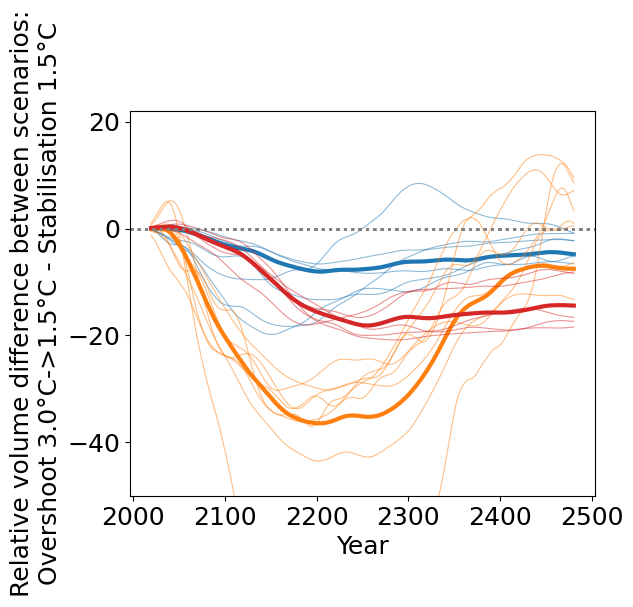

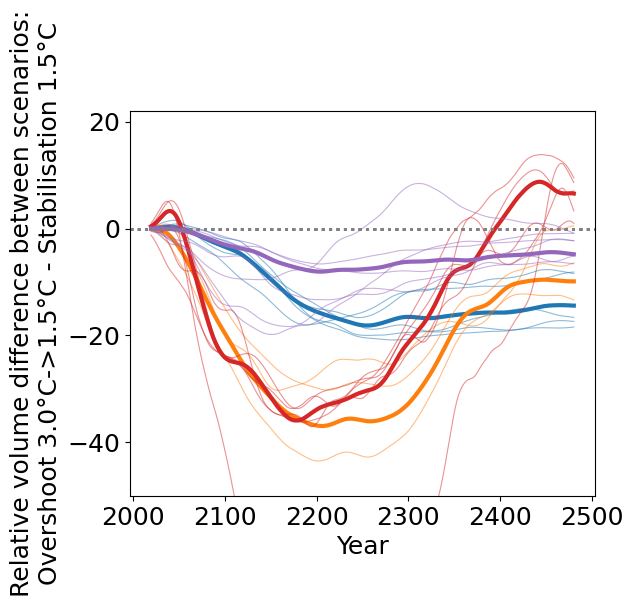

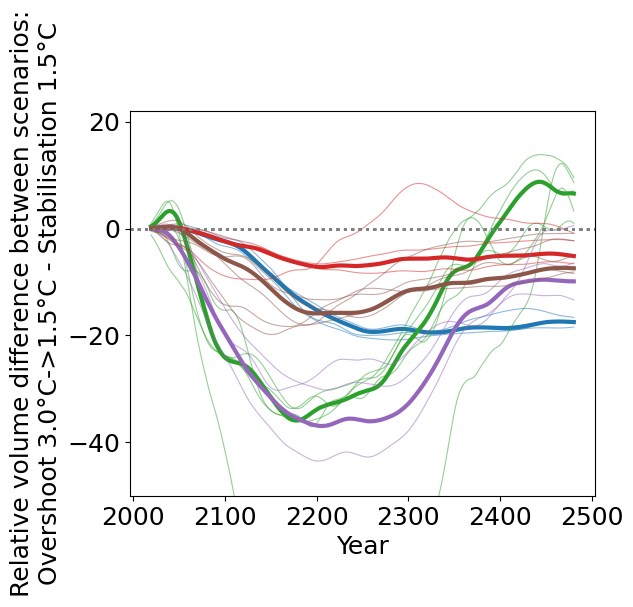

In [51]:
for k in [4,5,6]: 
    for s,p in zip(scenarios,palette):
        if s=='oversh_T30OS15':
            c_o = p
        elif s == 'stab_T15':
            c_s = p
    fig, axs = plt.subplots(1,1, figsize=(6,5), sharey=True)
    ax = axs
    for c in np.arange(0,6,1):
        #ax = axs[c]
        #plt.subplot(2,3,c+1)
        rgi_regs_sel = pd_clusters_all.loc[pd_clusters_all[f'kmeans_{k}clusters_diff_oversh']==c].index.values
        init_sel_sum = _df_scenario_common_rgi_reg.volume.sel(time=2020).sel(rgi_reg = rgi_regs_sel).sum(dim='rgi_reg')
        _sel = df_scenario_common_rgi_reg.volume.sel(rgi_reg=rgi_regs_sel)
        print(c, _sel.rgi_reg.values)
        
        #ax.set_title([c, _sel.rgi_reg.values], fontsize=12)
        df_scenario_common_cluster = _sel.sum(dim='rgi_reg')
        df_scenario_common_cluster_rel = 100*df_scenario_common_cluster/init_sel_sum
        #äfor s in color_scenario_poster.keys(): 
        sel_diff_rel = df_scenario_common_cluster_rel.sel(scenario='oversh_T30OS15').squeeze()-df_scenario_common_cluster_rel.sel(scenario='stab_T15').squeeze()
        if str(_sel.rgi_reg.values) != "['12']":
            ax.plot(df_scenario_common_cluster_rel.time,
                     sel_diff_rel.rolling(time=21,center=True).mean(),
                     color=f'C{c}', #color_scenario_poster[s],
                     lw=3)  
        sel_diff = df_scenario_common_vol_rel.sel(rgi_reg=rgi_regs_sel).sel(scenario='oversh_T30OS15')-df_scenario_common_vol_rel.sel(rgi_reg=rgi_regs_sel).sel(scenario='stab_T15')
        for r in _sel.rgi_reg:
            ax.plot(_sel.time,
                     sel_diff.sel(rgi_reg=r).squeeze().rolling(time=21, center=True).mean(), lw=0.8, color = f'C{c}', alpha = 0.5)
        ax.axhline(0, lw=2, color='grey',ls=':')
    ax.set_ylim([-50, 22])
    ax.set_ylabel('Relative volume difference between scenarios:\nOvershoot 3.0°C->1.5°C - Stabilisation 1.5°C')
    ax.set_xlabel('Year')

0 ['02' '03' '04' '06' '08' '17']
1 ['10' '11' '12' '13' '14' '15' '16' '18']
2 []
3 ['01' '05' '07' '09' '19']
4 []
5 []
0 ['01' '05' '07' '09' '19']
1 ['10' '13' '14']
2 []
3 ['11' '12' '15' '16' '18']
4 ['02' '03' '04' '06' '08' '17']
5 []
0 ['07' '09' '19']
1 []
2 ['11' '12' '15' '16' '18']
3 ['03' '04' '06']
4 ['10' '13' '14']
5 ['01' '02' '05' '08' '17']


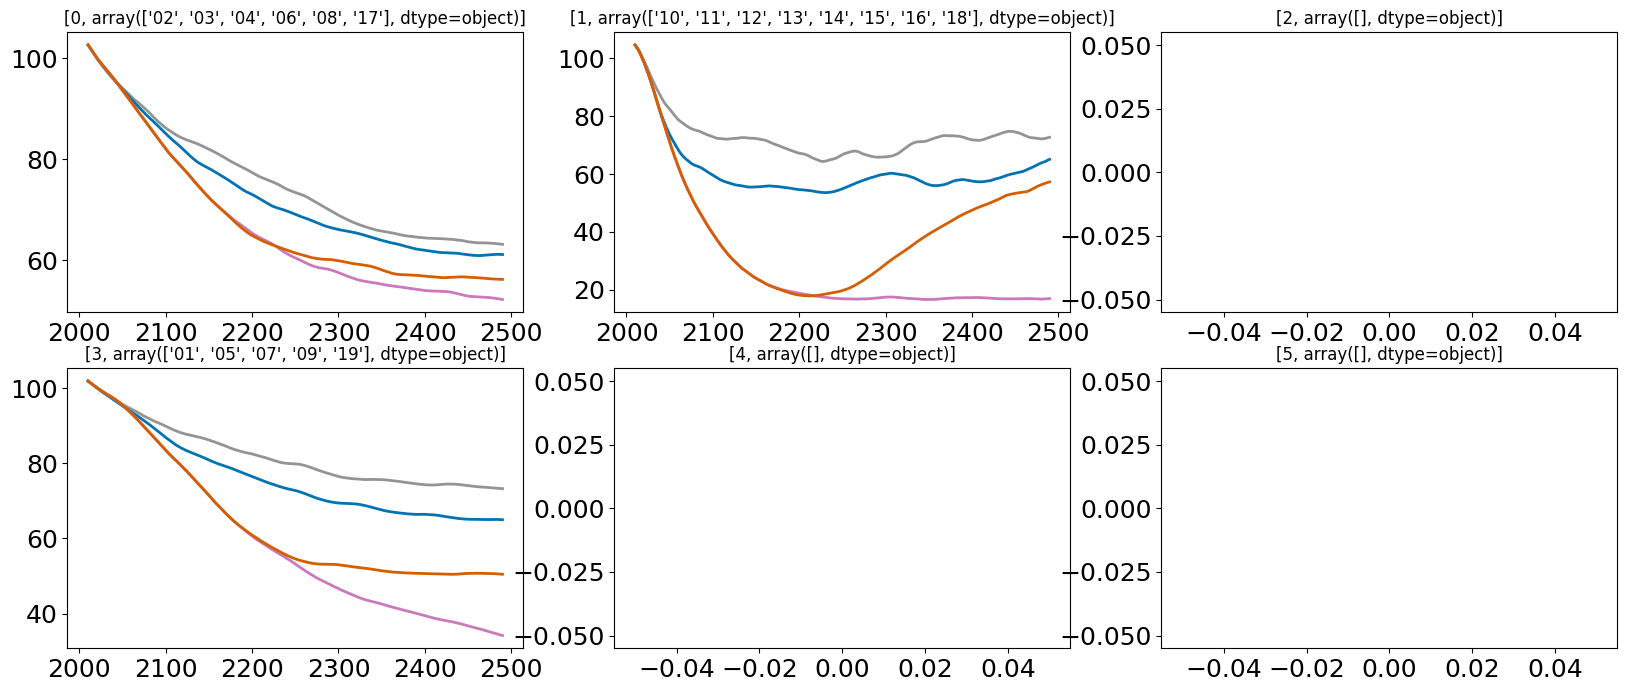

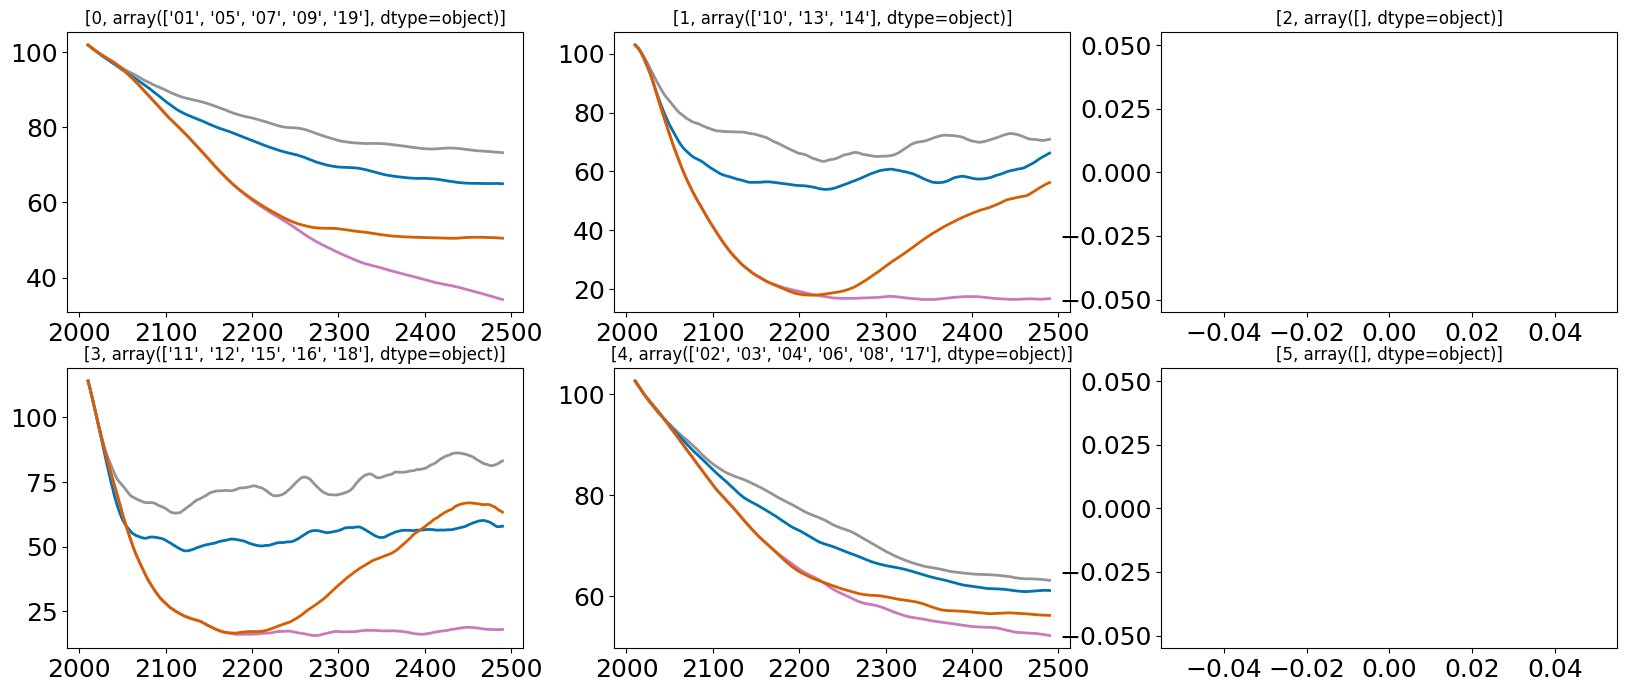

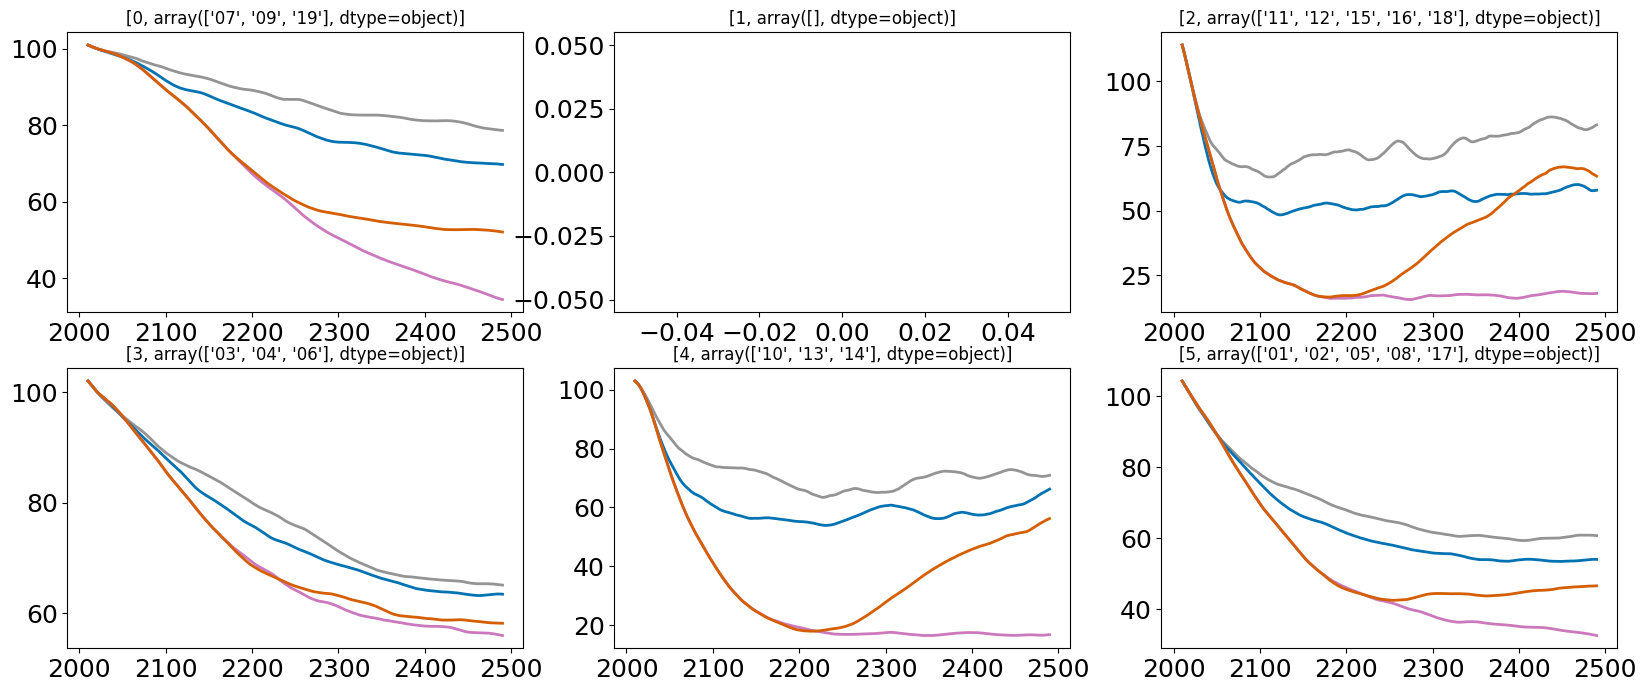

In [52]:
#k = 6
for k in [4,5,6]: 

    for s,p in zip(scenarios,palette):
        if s=='oversh_T30OS15':
            c_o = p
        elif s == 'stab_T15':
            c_s = p
    plt.figure(figsize=(20,8))
    for c in np.arange(0,6,1):
        plt.subplot(2,3,c+1)        
        rgi_regs_sel = pd_clusters_all.loc[pd_clusters_all[f'kmeans_{k}clusters_diff_oversh']==c].index.values
        init_sel_sum = _df_scenario_common_rgi_reg.volume.sel(time=2020).sel(rgi_reg = rgi_regs_sel).sum(dim='rgi_reg')
        _sel = df_scenario_common_rgi_reg.volume.sel(rgi_reg=rgi_regs_sel)
        print(c, _sel.rgi_reg.values)
        plt.title([c, _sel.rgi_reg.values], fontsize=12)
        df_scenario_common_cluster = _sel.sum(dim='rgi_reg')
        df_scenario_common_cluster_rel = 100*df_scenario_common_cluster/init_sel_sum
        for s in color_scenario_poster.keys(): 
            plt.plot(df_scenario_common_cluster_rel.time, df_scenario_common_cluster_rel.sel(scenario=s).squeeze(), color=color_scenario_poster[s],
                    lw=2)    

# OLD - todo probably to remove

#### Other older versions of fig. 3 ...partly with basins instead of RGI regions

In [53]:
#plt.rc('font', size=14)
df_scenario_common = df_scenario_common_rgi_reg
for k in [4,5,6]: 
    for b,c in zip(pd_clusters_all.index, pd_clusters_all[f'kmeans_{k}clusters{normadd}'].values):
        df_rgi6g.loc[df_rgi6g.O1Region==b,f'kmeans_{k}clusters'] = c
        
for k in [4,5,6]: 
    for b,c in zip(pd_clusters_all.index, pd_clusters_all[f'kmeans_{k}clusters_diff_oversh'].values):
        df_rgi6g.loc[df_rgi6g.O1Region==b,f'kmeans_{k}clusters_diff_oversh'] = c

In [19]:
### common runninf glaciers merged in 2_volume_timeseries
df_scenario_common_basins = xr.open_dataset(f'../data/common_running_sum_all_basins_oversh_stab_2000_2500_bc_1980_2019.nc')
df_scenario_common_basins_runoff_rel = 100*df_scenario_common_basins.runoff/df_scenario_common_basins.runoff.sel(time=slice(2000,2050)).mean(dim='time')
df_scenario_common_basins_runoff_rel = df_scenario_common_basins_runoff_rel.sel(basin = basin_glac)
df_scenario_common_basins_runoff_rel_roll = df_scenario_common_basins_runoff_rel.rolling(time=51,center=True).mean()
sel_diff_runoff_basins_rel = df_scenario_common_basins_runoff_rel_roll.sel(scenario='oversh_T30OS15').squeeze()-df_scenario_common_basins_runoff_rel_roll.sel(scenario='stab_T15').squeeze()


# Inverting the dictionary
clus_basin_glac_dict = {}
for key, value in basin_glac_clus_dict.items():
    if value not in clus_basin_glac_dict:
        clus_basin_glac_dict[value] = [key]
    else:
        clus_basin_glac_dict[value].append(key)
try:
    clus_basin_glac_dict[2.0] = clus_basin_glac_dict[3.0]
except:
    pass

0 ['01' '05' '07' '09' '19']
1 ['02' '03' '04' '06' '08' '17']
2 ['10' '11' '12' '13' '14' '15' '16' '18']
0 ['01' '05' '07' '09' '19']
67.0
1 ['02' '03' '04' '06' '08' '17']
30.4
2 ['10' '11' '12' '13' '14' '15' '16' '18']
4.9
0 ['01' '05' '07' '09' '19']
58.7
1 ['02' '03' '04' '06' '08' '17']
23.6
2 ['10' '11' '12' '13' '14' '15' '16' '18']
13.9


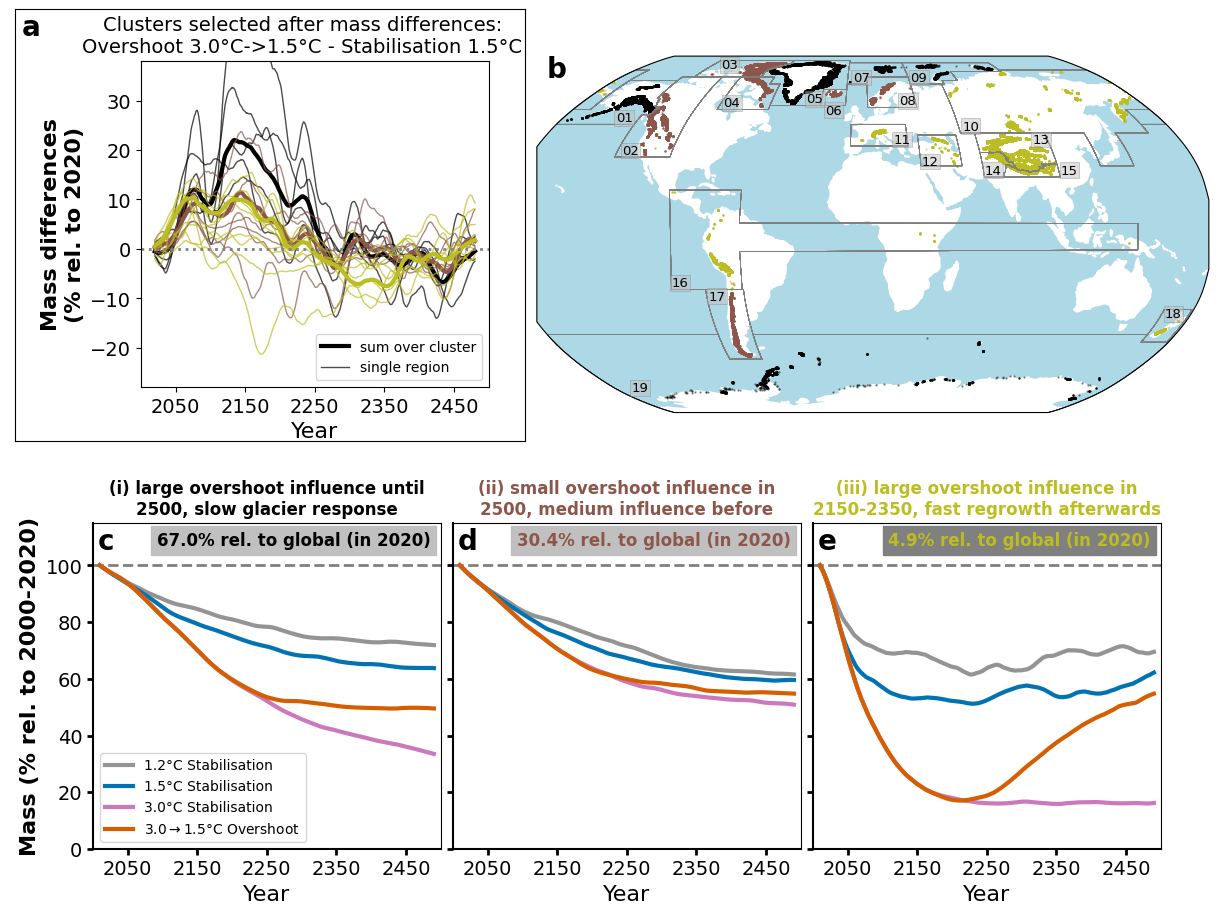

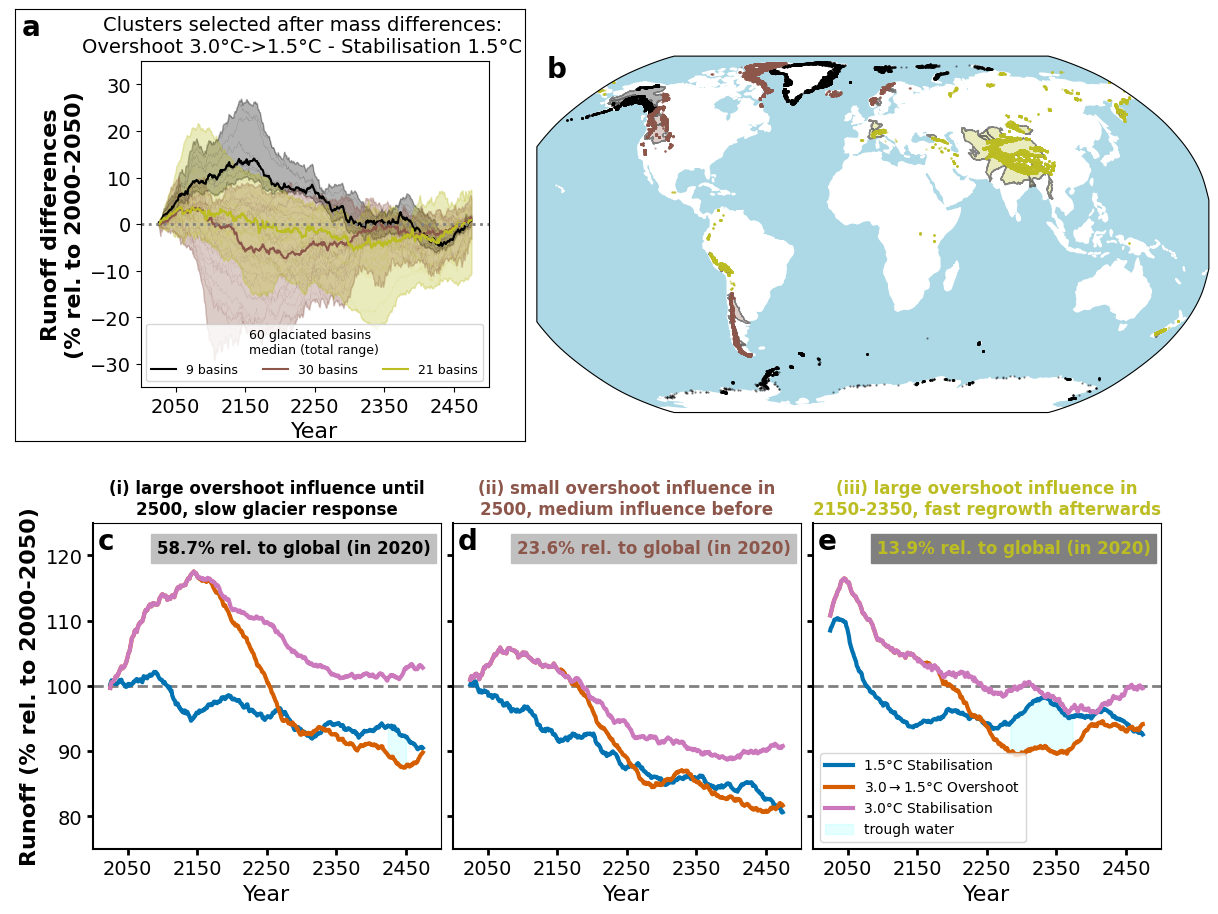

In [21]:
plt.rc('font', size=14)
for variable in ['runoff','runoff_basins']:  #  'volume <. 
    if variable == 'runoff':
        variable_c = 'Runoff'
        variable2 = 'runoff'
        roll_avg = 51
    if variable == 'runoff_basins':
        variable_c = 'Runoff'
        variable2 = 'runoff'
        roll_avg = 51
    else:
        variable_c  = 'Mass'
        variable2 = 'volume'
        roll_avg = 21

    show_temp = False
    for k in [k]: #,5,6]: 
        for clustering_opt in ['manual_chosen_3_clusters']: #[f'kmeans_{k}clusters_diff_oversh']: #,  f'kmeans_{k}clusters{normadd}', 
            if clustering_opt == 'manual_chosen_3_clusters': #f'kmeans_{k}clusters_diff_oversh':
                kk = k-1
            else:
                kk = k
            pie_scenarios = [2]
            for pie_scenario in pie_scenarios:

                fig = plt.figure() #figsize=(20,8))
                # Add background image
                ax_background = fig.add_axes([0.44,0.5,0.56,0.5], projection=ccrs.Robinson())
                ax_background.patch.set_facecolor('lightblue')
                ax_background.get_yaxis().set_visible(False)
                ax_background.get_xaxis().set_visible(False)
            #    ax_background.coastlines(color='white')
                ax_background.add_feature(cartopy.feature.LAND, color='white')

                # Add global boundary
                ax_global_patch = fig.add_axes([0.005,0.52,0.425,0.48], facecolor='white')
                ax_global_patch.get_yaxis().set_visible(False)
                ax_global_patch.get_xaxis().set_visible(False)

                # Add RGI glacier outlines

                if add_rgi_glaciers:
                    # if I do that here: 
                    # **somehow only the glaicers of one RGI region are visible**
                    #shape_feature = ShapelyFeature(Reader(rgi_shp_fn).geometries(), ccrs.Robinson(),alpha=1,facecolor='indigo',linewidth=0.35,edgecolor='indigo')
                    #ax_background.add_feature(shape_feature)
                    # instead aplly that here ... 
                    for c in np.arange(0,3,1): # before: 0,k,1
                        df_rgi6g_sel = df_rgi6g.loc[df_rgi6g[clustering_opt]==c]
                        ax_background.scatter(df_rgi6g_sel.CenLon.values, df_rgi6g_sel.CenLat.values,
                                              color=cols[c],
                                              #color='lightgrey',
                                              s=0.3, alpha =0.5,
                                              transform=ccrs.PlateCarree());
                if  variable != 'runoff_basins':
                    for en,rgi_reg in enumerate(df_scenario_common.rgi_reg):
                        coords = coordinates[en]
                        shape_feature = ShapelyFeature(Reader(rgi_regions_fn).geometries(), ccrs.Robinson(),facecolor="None", edgecolor='grey', alpha = 1, lw=0.4)
                                                       #alpha=1,facecolor='None',linewidth=0.35,edgecolor='k')
                        ax_background.add_feature(shape_feature)


                ### copied from fabis RGI6/7 code ....
                    did10 = False
                    for i, r in df_reg_shp_rgi7.iterrows():
                        tx = r.min_x + 4
                        ty = r.min_y 
                        fs = 16
                        t = r.o1region

                        if t == '01':
                            tx = r.min_x + 35
                        if t == '03':
                            tx = r.min_x + 15
                            ty = r.min_y + 3
                        if t == '05':
                            tx = r.min_x + 40
                        if t == '06':
                            ty = r.min_y - 5.5
                        if t == '08':
                            tx = r.min_x + 20
                        if t == '09':
                            tx = r.min_x 
                        if t == '11':
                            tx = r.min_x + 24
                        if t == '10':
                            tx = r.min_x + 1
                            ty = r.min_y + 15
                            if not did10:
                                did10 = True
                                continue
                        if t == '13':
                            ty = r.min_y + 12
                            tx = r.min_x + 30
                        if t in ['14', '12', '16', '17']:
                            tx = r.min_x 
                        if t == '15':
                            tx = r.min_x + 30
                        if t == '17':
                            ty = r.min_y + 26
                        if t == '18':
                            ty = r.min_y + 10
                        if t == '19':
                            ty = r.min_y + 10
                        if t == '20':
                            continue

                        ax_background.text(tx, ty, t, transform=ccrs.PlateCarree(), 
                                ha='left', va='bottom', fontsize=9.5,bbox=dict(facecolor='silver', edgecolor='grey',
                                                                               pad=1, lw=0.5, alpha=0.5)
                                      )
                #################

                reg_pie_sizes=[]
                for c in np.arange(0,kk,1):
                    pie_size = 0.29
                    reg_pie_sizes.append(pie_size)
                fac=1.25
                axgb = fig.add_axes([0.11,0.58,reg_pie_sizes[0],reg_pie_sizes[0]*fac], facecolor='white') # 0.01 


                ax = axgb

                if variable != 'runoff_basins':
                    # just for the legend
                    line1 = Line2D([0], [0], color='k',
                                     label='sum over cluster',
                                     lw=3, alpha = 1)  
                    line2 = Line2D([0], [0], color='k',
                                     label='single region',
                                     lw=1, alpha = 0.7)  
                    from matplotlib.lines import Line2D
                    ax.legend([line1,line2],['sum over cluster','single region'],
                               fontsize=10, ncol=1, loc='lower right')
                else:
                    line2 = Line2D([0], [0], color='k',
                                     label='glaciated basin (n=60)',
                                     lw=1, alpha = 0.7)  
                    ax.legend([line2],['glaciated basin (n=60)'],
                               fontsize=10, ncol=1, loc='upper right')
                ##############################
                if variable != 'runoff_basins':
                    for c in np.arange(0,3,1): 
                        #ax = axs[c]
                        #plt.subplot(2,3,c+1)
                            rgi_regs_sel = pd_clusters_all.loc[pd_clusters_all['manual_chosen_3_clusters']==c].index.values
                             # make sure to use the non-rolling average at year 2020 (i.e., use _df_scenario_common_rgi_reg instead of df_scenario_common_rgi_reg)
                            init_sel_sum = _df_scenario_common_rgi_reg[variable].sel(time=2020).sel(rgi_reg = rgi_regs_sel).sum(dim='rgi_reg')
                            _sel = df_scenario_common_rgi_reg[variable].sel(rgi_reg=rgi_regs_sel)
                            print(c, _sel.rgi_reg.values)
                            #ax.set_title([c, _sel.rgi_reg.values], fontsize=12)
                            df_scenario_common_cluster = _sel.sum(dim='rgi_reg')
                            df_scenario_common_cluster_rel = 100*df_scenario_common_cluster/init_sel_sum
                            #äfor s in color_scenario_poster.keys(): 
                            sel_diff_rel = df_scenario_common_cluster_rel.sel(scenario='oversh_T30OS15').squeeze()-df_scenario_common_cluster_rel.sel(scenario='stab_T15').squeeze()
                            if str(_sel.rgi_reg.values) != "['12']":
                                ax.plot(df_scenario_common_cluster_rel.time,
                                         sel_diff_rel.rolling(time=roll_avg,center=True).mean(),
                                         color=cols[c], #color_scenario_poster[s],
                                         lw=3)  

                            if variable =='volume':
                                sel_diff = df_scenario_common_vol_rel.sel(rgi_reg=rgi_regs_sel).sel(scenario='oversh_T30OS15')-df_scenario_common_vol_rel.sel(rgi_reg=rgi_regs_sel).sel(scenario='stab_T15')
                            else:
                                sel_diff = df_scenario_common_runoff_rel.sel(rgi_reg=rgi_regs_sel).sel(scenario='oversh_T30OS15')-df_scenario_common_runoff_rel.sel(rgi_reg=rgi_regs_sel).sel(scenario='stab_T15')

                            for r in _sel.rgi_reg:
                                ax.plot(_sel.time,
                                         sel_diff.sel(rgi_reg=r).squeeze().rolling(time=roll_avg, center=True).mean(), lw=1, color = cols[c], alpha = 0.7,
                                        )
                
                if variable == 'runoff_basins':
                    for _b in basin_glac:
                        c = basin_glac_clus_dict[_b].astype(int)
                        sel_diff_rel_b = sel_diff_runoff_basins_rel.sel(basin = _b)
                        ax.plot(sel_diff_rel_b.time,
                                sel_diff_rel_b, # we do the rolling already before that ... (not sure if it is ag ood ideal .rolling(time=roll_avg,center=True).mean(),
                                                       color=cols[c], #color_scenario_poster[s],
                                                       lw=0.2, alpha = 0.3)#, zorder=10)  
                        
                    #plt.figure(figsize=(10,7))
                    for c,j in enumerate([0,1,2]): #2,3]):
                        c = cols[j]
                        _pd_sel = sel_diff_runoff_basins_rel.sel(basin = clus_basin_glac_dict[j]).to_dataframe().reset_index()
                        n = len(_pd_sel.basin.unique())
                        sns.lineplot(ax=ax,data = _pd_sel, x='time', y= 'runoff', estimator='median',
                            errorbar=('pi', 100), color = c, label=f'{n} basins', err_kws={'alpha':0.3})
                    ax.legend(title = '60 glaciated basins\nmedian (total range)', ncol=3, fontsize=9, title_fontsize=9, loc='lower right')
                    #plt.ylabel(f'Runoff differences\n(% rel. to 2000-2050)', fontsize=16,fontweight='bold')
                    #plt.xlabel('Year')
                    #plt.axhline(0,color='grey')

                ax.axhline(0, lw=2, color='grey',ls=':')
                if variable == 'volume':
                    ax.set_ylim([-48, 18])
                    ax.set_yticks([-40,-30,-20,-10,0,10])
                elif variable =='runoff_basins':
                    ax.set_ylim([-35, 35])
                    ax.set_yticks([-30,-20,-10,0,10,20,30])
                else:
                    ax.set_ylim([-28, 38])
                    ax.set_yticks([-20,-10,0,10,20,30])
                if variable != 'runoff_basins':
                    ax.set_ylabel(f'{variable_c} differences\n(% rel. to 2020)', fontsize=16,fontweight='bold')
                else:
                    ax.set_ylabel(f'{variable_c} differences\n(% rel. to 2000-2050)', fontsize=16,fontweight='bold')
                    
                ax.set_title('Clusters selected after mass differences:    \nOvershoot 3.0°C->1.5°C - Stabilisation 1.5°C    ', fontsize=14)
                ax.set_xlabel('Year', fontsize=16) #,fontweight='bold')
                ax.set_xlim([2000,2500])
                ax.set_xticks([2050,2150,2250,2350,2450],[2050,2150,2250,2350,2450])

                ax0b = fig.add_axes([0.07,0.067,reg_pie_sizes[1],reg_pie_sizes[1]*fac], facecolor='white')
                ax1b = fig.add_axes([0.37,0.067,reg_pie_sizes[1],reg_pie_sizes[1]*fac], facecolor='white')
                ax2b = fig.add_axes([0.67, #0.665,
                                     0.067,reg_pie_sizes[1],reg_pie_sizes[1]*fac], facecolor='white')    
                #ax3b = fig.add_axes([0.05,0.04,reg_pie_sizes[1],reg_pie_sizes[1]*fac], facecolor='white')
                #ax4b = fig.add_axes([0.38,0.04,reg_pie_sizes[1],reg_pie_sizes[1]*fac], facecolor='white')
                #ax5b = fig.add_axes([0.71,0.04,reg_pie_sizes[1],reg_pie_sizes[1]*fac], facecolor='white')


                
                if variable == 'runoff_basins':
                    for _b in basin_glac:
                        c = basin_glac_clus_dict[_b].astype(int)
                        geo = pd_basin_num.loc[pd_basin_num.MRBID==int(_b),'geometry'].values
                        #feature = ShapelyFeature([geom], ccrs.Robinson(), facecolor=(1, 0, 0, 0.3), edgecolor=(0.5, 0.5, 0.5, 1), linewidth=0.2)
                        shape_feature = ShapelyFeature(geo, ccrs.PlateCarree(),facecolor=(cols[c][0], cols[c][1], cols[c][2],0.3), 
                                                       #edgecolor=(cols[c][0], cols[c][1], cols[c][2],0.8), 
                                                       edgecolor=(0.4, 0.4, 0.4,0.8), 
                                                       #grey 
                                                      lw=0.9, zorder=-1) # , alpha = 0.4)
                        ax_background.add_feature(shape_feature)

                    #for _c in np.arange(0,k,1):
                    #    df_rgi6g_sel = df_rgi6g.loc[df_rgi6g[clustering_opt]==_c]
                    #    ax_background.scatter(df_rgi6g_sel.CenLon.values, df_rgi6g_sel.CenLat.values,
                    #                          color=cols[_c],
                    #                          #color='lightgrey',
                    #                          s=0.1, alpha =0.5,
                    #                          transform=ccrs.PlateCarree());
                
                ################################## REGIONAL
                texts = ['(i) large overshoot influence until\n2500, slow glacier response',
                    '(ii) small overshoot influence in\n2500, medium influence before',
                    '(iii) large overshoot influence in\n2150-2350, fast regrowth afterwards']
                         #  , 'fast response, large loss',
                         # r'fast regrowth, highest $\Delta$T sensitivity',
                     #r'fastest regrowth, medium loss', #high $\Delta$T sensitivity', 'slow response, medium loss',
                     #    '..., large loss', r'fast regrowth, highest $\Delta$T sensitivity'
                     #'no regional temp. overshoot'
                nums = ['c','d','e'] #,'(d)','(e)','(g)']
                #            nums = ['(b)','(d)','(f)','(a)','(e)','(c)']
                for cc,ax in enumerate([ax0b,ax1b,ax2b,
                                        #ax3b,ax4b,ax5b
                                       ][:kk]):
                    ax.axhline(100, lw=2, color='grey',ls='--')

                    c = pd_clusters_all[clustering_opt].unique()[cc].astype(int)
                    # make sure to use the non-rolling average at year 2020 (i.e., use _df_scenario_common_rgi_reg instead of df_scenario_common_rgi_reg)
                    # for the runoff, we clearly want to divide trough the rolling average !!!
                    if variable == 'volume':
                        init_sel_sum = _df_scenario_common_rgi_reg[variable2].sel(time=2020).sel(rgi_reg = pd_clusters_all.loc[pd_clusters_all[clustering_opt]==c].index.values).sum(dim='rgi_reg')
                    else:
                        # this is the 21 yr averaged  stuff
                        init_sel_sum = df_scenario_common_rgi_reg[variable2].sel(time=2010).sel(rgi_reg = pd_clusters_all.loc[pd_clusters_all[clustering_opt]==c].index.values).sum(dim='rgi_reg')

                    ##### now the rolling average for the other stuff ... 
                    _sel = _df_scenario_common_rgi_reg[variable2].sel(rgi_reg=pd_clusters_all.loc[pd_clusters_all[clustering_opt]==c].index.values)
                    if 'runoff' in variable2:
                        _sel = _sel.isel(time=slice(0,-1))
                    _sel = _sel.rolling(time=roll_avg, center=True).mean().dropna(dim='time')
                    print(c, _sel.rgi_reg.values)
                    #ax.set_title(c, color=f'C{c}')
                    df_scenario_common_cluster = _sel.sum(dim='rgi_reg')
                    df_scenario_common_cluster_rel = (100*df_scenario_common_cluster/init_sel_sum)

                    if variable2 == 'volume':
                        scenarios = color_scenario_poster.keys()
                    else:
                        scenarios = ['stab_T15', 'oversh_T30OS15', 'stab_T30']

                    for s in scenarios: 
                        ax.plot(df_scenario_common_cluster_rel.time, df_scenario_common_cluster_rel.sel(scenario=s).squeeze(),
                                color=color_scenario_poster[s],
                                lw=3, label=label_scenario[s]) 
                    leg = ax.legend(loc='lower left', bbox_to_anchor=(0.9,1.15), fontsize=10, ncol=4)

                    if cc == 1:
                        ### add legends
                        handles, labels = ax.get_legend_handles_labels()
                        if show_temp: 
                            handles_2, labels_2 = ax2.get_legend_handles_labels()
                            leg2 = ax.legend([handles[0], handles_2[0]], [f'{variable_c} changes\n(left)',
                                                                          'Temperature changes\n(right, 21-yr avg.)'],
                                             loc='lower left', ncol=2, fontsize=10, bbox_to_anchor=(-0.28,1.15))
                            leg2.get_lines()[0].set_linewidth(2)
                            leg2.get_lines()[1].set_linewidth(1)
                            for l in leg2.get_lines():
                                l.set_color('black')
                            ax.add_artist(leg)    
                        else:
                            leg.remove()
                    else:
                        leg.remove()


                    ax.set_title(texts[cc], color=cols[c], fontsize=12,fontweight='bold') #+' '+ texts[c], fontsize=11)
                    delta=0
                    tt = ''
                    rgi_regs_temp=[]
                    if  variable != 'runoff_basins':
                        for p in _sel.rgi_reg.values:
                            t = d_reg_num_name[p]
                            if tt !='':
                                tt = tt + '\n' +t
                            else:
                                tt=t

                            #shape_feature = ShapelyFeature(geo, ccrs.PlateCarree(), facecolor="None", edgecolor=cols[c], lw=2)
                            #ax_background.add_feature(shape_feature)

                            shape_feature = ShapelyFeature(Reader(rgi_regions_fn).geometries(), ccrs.Robinson(),facecolor="None",
                                                           edgecolor='grey', alpha = 1, lw=0.2)
                                                           #alpha=1,facecolor='None',linewidth=0.35,edgecolor='k')
                            ax_background.add_feature(shape_feature)
                            label_rgi_reg = False
                            if label_rgi_reg:
                                # TODO
                                geo = gdf.loc[gdf.provide_id == p]['geometry'].values
                                max_x = gdf.loc[gdf.provide_id == p]['max_x'].values[0]
                                max_y = gdf.loc[gdf.provide_id == p]['max_y'].values[0]
                                print(max_x,max_x)
                                if p in ['P13','P02','P01','P03', 'P05']:
                                    ax_background.text(max_x-30,max_y-1, p, va='top', ha='right',
                                       transform=ccrs.PlateCarree(),
                                       fontsize=8, fontweight='bold') #, backgroundcolor=cols[c]) #, edgecolor=cols[c] )
                                elif p == 'P06':
                                    ax_background.text(179,max_y-1, p, va='top', ha='right',
                                       transform=ccrs.PlateCarree(),
                                       fontsize=8, fontweight='bold')
                                else:
                                    ax_background.text(max_x-3,max_y-1, p, va='top', ha='right',
                                                       transform=ccrs.PlateCarree(),
                                                       fontsize=8, fontweight='bold') #, backgroundcolor=cols[c]) #, edgecolor=cols[c] )

                            rgi_regs_temp.append(f'RGI{p}_glacier')
                 
                    init = init_sel_sum.mean() #df_scenario_common_cluster.sel(time=2020).mean() # all 8 scenarios are anyways equal (as we use here the non-rolling average!!!)
                    assert (init_sel_sum.std()/init).values <1e-2
                    init_all = _df_scenario_common_rgi_reg[variable2].sel(time=2020).sum(dim='rgi_reg').mean()  # make sure to use here the non-rolling average
                    #df_scenario_common.sel(time=2020).sum(dim='rgi_reg').volume.mean()
                    perc_init = np.round(100*init/init_all,1).values
                    print(perc_init)
                    #tt = tt + f'\n{perc_init}% initially rel. to global' 
                    tt = f'{perc_init}% rel. to global (in 2020)' 

                    if (cols[c] in [(0.5490196078431373, 0.33725490196078434, 0.29411764705882354), (0.0, 0.0, 0.0)]):
                        bc = 'silver'
                        #print(cols[c])
                    else:
                        bc='grey' #'silver'
                    #if c in [10]:
                    #    if c==4:
                    #        fs=7
                    #    else:
                    #        fs=7
                    #    ax.text(2015,5, tt , va='bottom', fontsize=fs, ha='left', color=cols[c], backgroundcolor=bc, fontweight='bold', zorder=0)
                    #else:
                    if variable2 =='volume':
                        ax.text(2485,112, tt , va='top', fontsize=12, ha='right', color=cols[c], backgroundcolor=bc, fontweight='bold')
                        ax.set_ylim([0,115])
                    else:
                        ax.text(2485,122.5, tt , va='top', fontsize=12, ha='right', color=cols[c], backgroundcolor=bc, fontweight='bold')
                        ax.set_ylim([75,125])
                    ax.set_xlim([2000,2500])
                    ax.set_xticks([2050,2150,2250,2350,2450],[2050,2150,2250,2350,2450])
                    for axis in 'left', 'bottom':
                        ax.spines[axis].set_linewidth(1.5)
                    ax.tick_params(axis='both', which='major', width=2, length=4)

                    ### regional glacier-area weighted temp. change 
                    if show_temp: 
                        if len(rgi_regs_temp) == 1:
                            pd_clim_all_r = pd_clim_all.loc[pd_clim_all.region == f'RGI{p}_glacier']
                        else :
                            condis = np.repeat(False, len(pd_clim_all.region))
                            # should be in one of the basins 
                            for r in rgi_regs_temp:
                                condis = condis | (pd_clim_all.region == r) 
                            assert len(rgi_regs_temp)*len(pd_clim_all.scenario.unique())*len(pd_clim_all.year.unique()) == len(pd_clim_all[condis])
                            pd_clim_all_r = pd_clim_all.loc[condis].groupby(['scenario', 'year'])[['temp_21yr_avg', 
                                                                                                   'area']].apply(lambda x: np.average(x['temp_21yr_avg'], weights=x['area'])).dropna().reset_index()
                            pd_clim_all_r['temp_21yr_avg'] = pd_clim_all_r[0].values

                        ax2 = ax.twinx()  
                        for scenario in color_scenario_poster.keys():
                            pd_clim_scenario_g = pd_clim_all_r.loc[pd_clim_all_r.scenario==scenario]
                            pd_clim_scenario_g.index = pd_clim_scenario_g.year
                            # this is approximately correct .. 
                            temp_ref_g = pd_clim_scenario_g.loc[2009][['temp_20yr_avg']].mean()
                            var_g_to_ref = pd_clim_scenario_g[var] - temp_ref_g

                            ax2.plot(pd_clim_scenario_g.year,
                                     var_g_to_ref,
                                     alpha = 0.6, 
                                     ls = '--',
                                     lw=1, color = color_scenario_poster[scenario], label=label_scenario[scenario])
                        ax2.set_ylabel('')
                        ax2.set_yticks(ticks=[0,1,2,3,4],
                                       labels=[0,1,2,3,4], alpha=0.6)
                        ax2.set_ylim([-0.99,4.2]);
                        ax2.set_xlim([2000,2500])
                        ax2.tick_params(axis='both', which='major', width=1, length=4, grid_alpha =0.6)
                        if nums[cc] in ['e','f']:
                            ax2.set_ylabel(r'$\Delta$T'+'(°C) rel. to 2000-2019\n(glacier-area weighted)',
                                          alpha = 0.6, fontsize=16)
                            plt.setp(ax.get_yticklabels(), visible=False, fontsize=1)
                        elif nums[cc] == 'c':
                            plt.setp(ax2.get_yticklabels(), visible=False, fontsize=1)

                        else:
                            plt.setp(ax2.get_yticklabels(), visible=False, fontsize=1)

                    if nums[cc] in ['e','f']:
                        plt.setp(ax.get_yticklabels(), visible=False, fontsize=1)
                    elif nums[cc] == 'c':
                        if variable == 'volume':
                            ax.set_ylabel(f'{variable_c} (% rel. to 2020)',fontweight='bold', fontsize=16)   
                        if variable == 'runoff_basins':
                            ax.set_ylabel(f'{variable_c} (% rel. to 2000-2050)',fontweight='bold', fontsize=16)   
                        else:
                            ax.set_ylabel(f'{variable_c} (% rel. to 2000-2020)',fontweight='bold', fontsize=16)   
                    else:
                        plt.setp(ax.get_yticklabels(), visible=False, fontsize=1)
                    ax.set_xlabel('Year', fontsize=16) #,fontweight='bold')

                    if 'runoff' in variable2:
                        condi = df_scenario_common_cluster_rel.sel(scenario='stab_T15').squeeze() >= df_scenario_common_cluster_rel.sel(scenario='oversh_T30OS15').squeeze()*1.05
                        if len(condi[condi]) >= 20:
                            trough_water_sel = df_scenario_common_cluster_rel.sel(time=condi[condi].time.values)
                            ax.fill_between(trough_water_sel.time, 
                                             trough_water_sel.sel(scenario='stab_T15').squeeze(),
                                             trough_water_sel.sel(scenario='oversh_T30OS15').squeeze(), alpha = 0.1, color='cyan', label = 'trough water')
                        if nums[cc] == 'e':
                            ax.legend(fontsize=10, loc = 'lower left')
                    else:
                        if nums[cc] == 'c':
                            ax.legend(fontsize=10, loc = 'lower left')

            ##################################
            num_text_x = 0.014
            for j,axi in enumerate([ax_global_patch, ax_background,ax0b,ax1b,ax2b]):
                num_text_y = 0.94
                shift = 0
                if j>=2:
                    shift = -0.02
                axi.text(num_text_x, num_text_y+shift,
                         num_dict[j], weight='bold', fontsize=20, transform=axi.transAxes)

            #plt.savefig('2x_worldmap_cluster_volume_v0.png')
            #plt.savefig('figures/2x_worldmap_cluster_volume_v0.png')
            fig.set_size_inches(12, 9)
            if 'diff_oversh' in clustering_opt:
                clustering_opt_add = f'{clustering_opt}_12_merged_to_11_cluster'
            else:
                clustering_opt_add = clustering_opt
            #if variable == 'runoff':
            #    fig.savefig(f'figures/2x_suppl_worldmap_cluster_{variable}_rgi_reg_{clustering_opt}_show_temp{show_temp}_v2.png', dpi=300)
            #elif variable == 'runoff_basins':
            #    fig.savefig(f'figures/2x_suppl_worldmap_cluster_{variable}_rgi_reg_{clustering_opt}_show_temp{show_temp}_v2.png', dpi=300)
            #else:
            #    fig.savefig(f'figures/2x_worldmap_cluster_{variable}_rgi_reg_{clustering_opt}_show_temp{show_temp}_v2.png', dpi=300)


### Older version but also with runoff 

IndexError: list index out of range

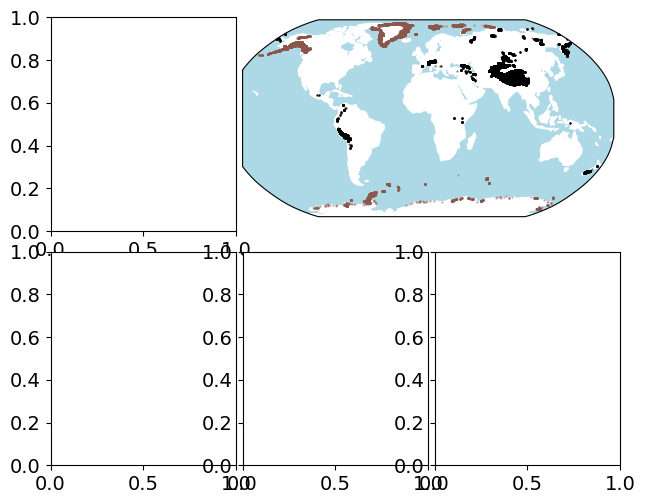

In [22]:
for _b in basin_glac:
    c = basin_glac_clus_dict[_b].astype(int)
    sel_diff_rel_b = sel_diff_runoff_basins_rel.sel(basin = _b)
    ax.plot(sel_diff_rel_b.time,
            sel_diff_rel_b, # we do the rolling already before that ... (not sure if it is ag ood ideal .rolling(time=roll_avg,center=True).mean(),
                                   color=cols[c], #color_scenario_poster[s],
                                   lw=0.9, alpha = 0.8)  

## new figure approach

plt.rc('font', size=14)
for variable in ['volume', 'runoff_basins']:  #  'runoff',
    clustering_opt = f'kmeans_{k}clusters_diff_oversh' #,  f'kmeans_{k}clusters{normadd}', 
    if clustering_opt == f'kmeans_{k}clusters_diff_oversh':
        kk = k-1
    else:
        kk = k
    
    fig = plt.figure() #figsize=(20,8))
    reg_pie_sizes=[]
    for c in np.arange(0,kk,1):
        pie_size = 0.29
        reg_pie_sizes.append(pie_size)
    fac=1.535#*0.65 # 
    #fac_2 = fac*1.02
    axgb = fig.add_axes([0.07, 0.555, #+ fac_2/2 * reg_pie_sizes[1],
                         reg_pie_sizes[0], reg_pie_sizes[0]*fac], facecolor='white') # 0.01 
    # Add background image
    ax_background = fig.add_axes([0.37,0.54, # + fac/2 * reg_pie_sizes[1],
                                  0.58,0.5], projection=ccrs.Robinson())
    ax0b = fig.add_axes([0.07,0.067,# - fac/2 * reg_pie_sizes[1],
                         reg_pie_sizes[1],reg_pie_sizes[1]*fac], facecolor='white')
    ax1b = fig.add_axes([0.37,0.067,# - fac/2 * reg_pie_sizes[1],
                         reg_pie_sizes[1],reg_pie_sizes[1]*fac], facecolor='white')
    ax2b = fig.add_axes([0.67, 0.067,#0.665,
                         reg_pie_sizes[1],reg_pie_sizes[1]*fac], facecolor='white')  

    #### 
    if variable == 'runoff':
        variable_c = 'Runoff'
        variable2 = 'runoff'
        roll_avg = 51
    if variable == 'runoff_basins':
        variable_c = 'Runoff'
        variable2 = 'runoff'
        roll_avg = 51
    else:
        variable_c  = 'Mass'
        variable2 = 'volume'
        roll_avg = 21

    show_temp = False    

    
    pie_scenario = 2

    # Add background image
    ax_background.patch.set_facecolor('lightblue')
    ax_background.get_yaxis().set_visible(False)
    ax_background.get_xaxis().set_visible(False)
#    ax_background.coastlines(color='white')
    ax_background.add_feature(cartopy.feature.LAND, color='white')

    # Add global boundary
    #ax_global_patch = fig.add_axes([0.005,0.52,0.425,0.48], facecolor='white')
    #ax_global_patch.get_yaxis().set_visible(False)
    #ax_global_patch.get_xaxis().set_visible(False)

    # Add RGI glacier outlines

    if add_rgi_glaciers:
        # if I do that here: 
        # **somehow only the glaicers of one RGI region are visible**
        #shape_feature = ShapelyFeature(Reader(rgi_shp_fn).geometries(), ccrs.Robinson(),alpha=1,facecolor='indigo',linewidth=0.35,edgecolor='indigo')
        #ax_background.add_feature(shape_feature)
        # instead aplly that here ... 
        for c in np.arange(0,k,1):
            df_rgi6g_sel = df_rgi6g.loc[df_rgi6g[clustering_opt]==c]
            ax_background.scatter(df_rgi6g_sel.CenLon.values, df_rgi6g_sel.CenLat.values,
                                  color=cols[c],
                                  #color='lightgrey',
                                  s=0.3, alpha =0.5,
                                  transform=ccrs.PlateCarree());
    if  variable != 'runoff_basins':
        for en,rgi_reg in enumerate(df_scenario_common.rgi_reg):
            coords = coordinates[en]
            shape_feature = ShapelyFeature(Reader(rgi_regions_fn).geometries(), ccrs.Robinson(),
                                           facecolor="None", edgecolor='grey', alpha = 1, lw=0.4)
                                           #alpha=1,facecolor='None',linewidth=0.35,edgecolor='k')
            ax_background.add_feature(shape_feature)


    ### copied from fabis RGI6/7 code ....
        did10 = False
        for i, r in df_reg_shp_rgi7.iterrows():
            tx = r.min_x + 4
            ty = r.min_y 
            fs = 16
            t = r.o1region

            if t == '01':
                tx = r.min_x + 35
            if t == '03':
                tx = r.min_x + 15
                ty = r.min_y + 3
            if t == '05':
                tx = r.min_x + 40
            if t == '06':
                ty = r.min_y - 5.5
            if t == '08':
                tx = r.min_x + 20
            if t == '09':
                tx = r.min_x 
            if t == '11':
                tx = r.min_x + 24
            if t == '10':
                tx = r.min_x + 1
                ty = r.min_y + 15
                if not did10:
                    did10 = True
                    continue
            if t == '13':
                ty = r.min_y + 12
                tx = r.min_x + 30
            if t in ['14', '12', '16', '17']:
                tx = r.min_x 
            if t == '15':
                tx = r.min_x + 30
            if t == '17':
                ty = r.min_y + 26
            if t == '18':
                ty = r.min_y + 10
            if t == '19':
                ty = r.min_y + 10
            if t == '20':
                continue

            ax_background.text(tx, ty, t, transform=ccrs.PlateCarree(), 
                    ha='left', va='bottom', fontsize=9.5,bbox=dict(facecolor='silver', edgecolor='grey',
                                                                   pad=1, lw=0.5, alpha=0.5)
                          )
        #ax_background.text(r.min_x, r.min_y -0.5, 'RGI glacier regions: ',
        #                  transform=ccrs.PlateCarree(), 
        #                ha='left', va='top',fontsize=9.5)

        # Add the RGI glacier name annotations  as columns
        x_pos = 0  # initial x position
        for jjj,key in enumerate(sorted(text_reg_leg_d.keys())):
            y_pos = -0.045  # start at the top of the y-axis
            for text in text_reg_leg_d[key]:
                ax_background.text(x_pos, y_pos, text, transform=ax_background.transAxes,
                                   fontsize=9.5, verticalalignment='bottom')

                y_pos -= 0.032  # move down for each entry
            if jjj ==0:
                x_pos += 0.25 #37  # move to the next column
            elif jjj==1:
                x_pos += 0.27
            else:
                x_pos += 0.28 #37  # move to the next column

    #################

    #reg_pie_sizes=[]
    #for c in np.arange(0,kk,1):
    #    pie_size = 0.29
    #    reg_pie_sizes.append(pie_size)
    #fac=1.535
    #axgb = fig.add_axes([0.07,
    #                     0.555,reg_pie_sizes[0],reg_pie_sizes[0]*fac], facecolor='white') # 0.01 


    ax = axgb

    if variable != 'runoff_basins':
        # just for the legend
        from matplotlib.lines import Line2D

        line1 = Line2D([0], [0], color='k',
                         label='sum over cluster',
                         lw=3, alpha = 1)  
        line2 = Line2D([0], [0], color='k',
                         label='single region',
                         lw=1, alpha = 0.7)  
        leg1 = ax.legend([line1,line2],['sum over cluster','single region'],
                   fontsize=10, ncol=1, loc='lower right')

        line_c1 = Line2D([0], [0], color=cols[-1],
                         label='',
                         lw=3, alpha = 1)  
        line_c2 = Line2D([0], [0], color=cols[0],
                         label='',
                         lw=3, alpha = 1)  
        line_c3 = Line2D([0], [0], color=cols[1],
                         label='',
                         lw=3, alpha = 1)  

        ax.legend([line_c1, line_c2, line_c3],
               texts,
                title_fontsize=11,
               title=r'3.0$\rightarrow$1.5 Overshoot - 1.5 Stabilisation',
               fontsize=9, loc='upper right')
        ax.add_artist(leg1)
    else:
        line2 = Line2D([0], [0], color='k',
                         label='glaciated basin (n=60)',
                         lw=1, alpha = 0.7)  
        ax.legend([line2],['glaciated basin (n=60)'],
                   fontsize=10, ncol=1, loc='upper right')


    ##############################
    if variable != 'runoff_basins':
        for c in np.arange(0,4,1): 
            #ax = axs[c]
            #plt.subplot(2,3,c+1)
                rgi_regs_sel = pd_clusters_all.loc[pd_clusters_all[f'kmeans_{k}clusters_diff_oversh']==c].index.values
                 # make sure to use the non-rolling average at year 2020 (i.e., use _df_scenario_common_rgi_reg instead of df_scenario_common_rgi_reg)
                init_sel_sum = _df_scenario_common_rgi_reg[variable].sel(time=2020).sel(rgi_reg = rgi_regs_sel).sum(dim='rgi_reg')
                _sel = df_scenario_common_rgi_reg[variable].sel(rgi_reg=rgi_regs_sel)
                print(c, _sel.rgi_reg.values)
                #ax.set_title([c, _sel.rgi_reg.values], fontsize=12)
                df_scenario_common_cluster = _sel.sum(dim='rgi_reg')
                df_scenario_common_cluster_rel = 100*df_scenario_common_cluster/init_sel_sum
                #äfor s in color_scenario_poster.keys(): 
                sel_diff_rel = df_scenario_common_cluster_rel.sel(scenario='oversh_T30OS15').squeeze()-df_scenario_common_cluster_rel.sel(scenario='stab_T15').squeeze()
                if str(_sel.rgi_reg.values) != "['12']":
                    ax.plot(df_scenario_common_cluster_rel.time,
                             sel_diff_rel.rolling(time=roll_avg,center=True).mean(),
                             color=cols[c], #color_scenario_poster[s],
                             lw=3)  

                if variable =='volume':
                    sel_diff = df_scenario_common_vol_rel.sel(rgi_reg=rgi_regs_sel).sel(scenario='oversh_T30OS15')-df_scenario_common_vol_rel.sel(rgi_reg=rgi_regs_sel).sel(scenario='stab_T15')
                else:
                    sel_diff = df_scenario_common_runoff_rel.sel(rgi_reg=rgi_regs_sel).sel(scenario='oversh_T30OS15')-df_scenario_common_runoff_rel.sel(rgi_reg=rgi_regs_sel).sel(scenario='stab_T15')

                for r in _sel.rgi_reg:
                    ax.plot(_sel.time,
                             sel_diff.sel(rgi_reg=r).squeeze().rolling(time=roll_avg, center=True).mean(), lw=1, color = cols[c], alpha = 0.7,
                            )

    if variable == 'runoff_basins':
        for _b in basin_glac:
            c = basin_glac_clus_dict[_b].astype(int)
            sel_diff_rel_b = sel_diff_runoff_basins_rel.sel(basin = _b)
            ax.plot(sel_diff_rel_b.time,
                    sel_diff_rel_b, # we do the rolling already before that ... (not sure if it is ag ood ideal .rolling(time=roll_avg,center=True).mean(),
                                           color=cols[c], #color_scenario_poster[s],
                                           lw=0.2, alpha = 0.3)#, zorder=10)  

        #plt.figure(figsize=(10,7))
        for c,j in enumerate([0,2,3]):
            c = cols[j]
            _pd_sel = sel_diff_runoff_basins_rel.sel(basin = clus_basin_glac_dict[j]).to_dataframe().reset_index()
            n = len(_pd_sel.basin.unique())
            sns.lineplot(ax=ax,data = _pd_sel, x='time', y= 'runoff', estimator='median',
                errorbar=('pi', 100), color = c, label=f'{n} basins', err_kws={'alpha':0.3})
        ax.legend(title = '60 glaciated basins\nmedian (total range)', ncol=3, fontsize=9, title_fontsize=9, loc='lower right')
        #plt.ylabel(f'Runoff differences\n(% rel. to 2000-2050)', fontsize=16,fontweight='bold')
        #plt.xlabel('Year')
        #plt.axhline(0,color='grey')

    ax.axhline(0, lw=2, color='grey',ls=':')
    if variable == 'volume':
        ax.set_ylim([-48, 29])
        ax.set_yticks([-40,-30,-20,-10,0,10,20])
    elif variable =='runoff_basins':
        ax.set_ylim([-35, 35])
        ax.set_yticks([-30,-20,-10,0,10,20,30])
    else:
        ax.set_ylim([-28, 38])
        ax.set_yticks([-20,-10,0,10,20,30])
    if variable != 'runoff_basins':
        ax.set_ylabel(f'{variable_c} differences (% rel. to 2020)',
                      #r'3.0$\rightarrow$1.5 Overshoot - 1.5 Stabilisation',
                      fontsize=15,fontweight='bold')
    else:
        ax.set_ylabel(f'{variable_c} differences\n(% rel. to 2000-2050)', fontsize=16,fontweight='bold')

    #ax.set_title('Clusters selected after mass differences:    \nOvershoot 3.0°C->1.5°C - Stabilisation 1.5°C    ', fontsize=14)
    #ax.set_xlabel('Year', fontsize=16) #,fontweight='bold')
    ax.set_xlim([2000,2500])
    ax.set_xticks([2050,2150,2250,2350,2450],[2050,2150,2250,2350,2450])

    ###### the three cluster plots in second row ... 
    if variable == 'runoff_basins':
        for _b in basin_glac:
            c = basin_glac_clus_dict[_b].astype(int)
            geo = pd_basin_num.loc[pd_basin_num.MRBID==int(_b),'geometry'].values
            #feature = ShapelyFeature([geom], ccrs.Robinson(), facecolor=(1, 0, 0, 0.3), edgecolor=(0.5, 0.5, 0.5, 1), linewidth=0.2)
            shape_feature = ShapelyFeature(geo, ccrs.PlateCarree(),facecolor=(cols[c][0], cols[c][1], cols[c][2],0.3), 
                                           #edgecolor=(cols[c][0], cols[c][1], cols[c][2],0.8), 
                                           edgecolor=(0.4, 0.4, 0.4,0.8), 
                                           #grey 
                                          lw=0.9, zorder=-1) # , alpha = 0.4)
            ax_background.add_feature(shape_feature)

        #for _c in np.arange(0,k,1):
        #    df_rgi6g_sel = df_rgi6g.loc[df_rgi6g[clustering_opt]==_c]
        #    ax_background.scatter(df_rgi6g_sel.CenLon.values, df_rgi6g_sel.CenLat.values,
        #                          color=cols[_c],
        #                          #color='lightgrey',
        #                          s=0.1, alpha =0.5,
        #                          transform=ccrs.PlateCarree());

    ################################## REGIONAL
             #  , 'fast response, large loss',
             # r'fast regrowth, highest $\Delta$T sensitivity',
         #r'fastest regrowth, medium loss', #high $\Delta$T sensitivity', 'slow response, medium loss',
         #    '..., large loss', r'fast regrowth, highest $\Delta$T sensitivity'
         #'no regional temp. overshoot'
    nums = ['c','d','e'] #,'(d)','(e)','(g)']
    #            nums = ['(b)','(d)','(f)','(a)','(e)','(c)']
    for cc,ax in enumerate([ax0b,ax1b,ax2b,
                            #ax3b,ax4b,ax5b
                           ][:kk]):
        ax.axhline(100, lw=2, color='grey',ls=':')

        c = pd_clusters_all[clustering_opt].unique()[cc]
        # make sure to use the non-rolling average at year 2020 (i.e., use _df_scenario_common_rgi_reg instead of df_scenario_common_rgi_reg)
        # for the runoff, we clearly want to divide trough the rolling average !!!
        if variable == 'volume':
            init_sel_sum = _df_scenario_common_rgi_reg[variable2].sel(time=2020).sel(rgi_reg = pd_clusters_all.loc[pd_clusters_all[clustering_opt]==c].index.values).sum(dim='rgi_reg')
        else:
            # this is the 21 yr averaged  stuff
            init_sel_sum = df_scenario_common_rgi_reg[variable2].sel(time=2010).sel(rgi_reg = pd_clusters_all.loc[pd_clusters_all[clustering_opt]==c].index.values).sum(dim='rgi_reg')

        ##### now the rolling average for the other stuff ... 
        _sel = _df_scenario_common_rgi_reg[variable2].sel(rgi_reg=pd_clusters_all.loc[pd_clusters_all[clustering_opt]==c].index.values)
        if 'runoff' in variable2:
            _sel = _sel.isel(time=slice(0,-1))
        _sel = _sel.rolling(time=roll_avg, center=True).mean().dropna(dim='time')
        print(c, _sel.rgi_reg.values)
        #ax.set_title(c, color=f'C{c}')
        df_scenario_common_cluster = _sel.sum(dim='rgi_reg')
        df_scenario_common_cluster_rel = (100*df_scenario_common_cluster/init_sel_sum)

        if variable2 == 'volume':
            scenarios = color_scenario_poster.keys()
        else:
            scenarios = ['stab_T15', 'oversh_T30OS15', 'stab_T30']

        for s in scenarios: 
            ax.plot(df_scenario_common_cluster_rel.time, df_scenario_common_cluster_rel.sel(scenario=s).squeeze(),
                    color=color_scenario_poster[s],
                    lw=3, label=label_scenario[s], ls= scenario_ls[s]) 
        leg = ax.legend(loc='lower left', bbox_to_anchor=(0.9,1.15), fontsize=12, ncol=4)

        if cc == 1:
            ### add legends
            handles, labels = ax.get_legend_handles_labels()
            if show_temp: 
                handles_2, labels_2 = ax2.get_legend_handles_labels()
                leg2 = ax.legend([handles[0], handles_2[0]], [f'{variable_c} changes\n(left)',
                                                              'Temperature changes\n(right, 21-yr avg.)'],
                                 loc='lower left', ncol=2, fontsize=10, bbox_to_anchor=(-0.28,1.15))
                leg2.get_lines()[0].set_linewidth(2)
                leg2.get_lines()[1].set_linewidth(1)
                for l in leg2.get_lines():
                    l.set_color('black')
                ax.add_artist(leg)    
            else:
                leg.remove()
        else:
            leg.remove()

        # DR wants to have a legend in (a), so removed the titles, as otherwise the same occurs twice ... 
        #ax.set_title(texts[cc], color=cols[c], fontsize=12,fontweight='bold') #+' '+ texts[c], fontsize=11)
        delta=0
        tt = ''
        rgi_regs_temp=[]
        if  variable != 'runoff_basins':
            for p in _sel.rgi_reg.values:
                t = d_reg_num_name[p]
                if tt !='':
                    tt = tt + '\n' +t
                else:
                    tt=t

                #shape_feature = ShapelyFeature(geo, ccrs.PlateCarree(), facecolor="None", edgecolor=cols[c], lw=2)
                #ax_background.add_feature(shape_feature)

                shape_feature = ShapelyFeature(Reader(rgi_regions_fn).geometries(), ccrs.Robinson(),facecolor="None",
                                               edgecolor='grey', alpha = 1, lw=0.2)
                                               #alpha=1,facecolor='None',linewidth=0.35,edgecolor='k')
                ax_background.add_feature(shape_feature)
                label_rgi_reg = False
                if label_rgi_reg:
                    # TODO
                    geo = gdf.loc[gdf.provide_id == p]['geometry'].values
                    max_x = gdf.loc[gdf.provide_id == p]['max_x'].values[0]
                    max_y = gdf.loc[gdf.provide_id == p]['max_y'].values[0]
                    print(max_x,max_x)
                    if p in ['P13','P02','P01','P03', 'P05']:
                        ax_background.text(max_x-30,max_y-1, p, va='top', ha='right',
                           transform=ccrs.PlateCarree(),
                           fontsize=8, fontweight='bold') #, backgroundcolor=cols[c]) #, edgecolor=cols[c] )
                    elif p == 'P06':
                        ax_background.text(179,max_y-1, p, va='top', ha='right',
                           transform=ccrs.PlateCarree(),
                           fontsize=8, fontweight='bold')
                    else:
                        ax_background.text(max_x-3,max_y-1, p, va='top', ha='right',
                                           transform=ccrs.PlateCarree(),
                                           fontsize=8, fontweight='bold') #, backgroundcolor=cols[c]) #, edgecolor=cols[c] )

                rgi_regs_temp.append(f'RGI{p}_glacier')

        init = init_sel_sum.mean() #df_scenario_common_cluster.sel(time=2020).mean() # all 8 scenarios are anyways equal (as we use here the non-rolling average!!!)
        assert (init_sel_sum.std()/init).values <1e-2
        init_all = _df_scenario_common_rgi_reg[variable2].sel(time=2020).sum(dim='rgi_reg').mean()  # make sure to use here the non-rolling average
        #df_scenario_common.sel(time=2020).sum(dim='rgi_reg').volume.mean()
        perc_init = np.round(100*init/init_all,1).values
        print(perc_init)
        #tt = tt + f'\n{perc_init}% initially rel. to global' 
        tt = f'{perc_init}% of global' # % rel. to global (2020)

        if (cols[c] in [(0.5490196078431373, 0.33725490196078434, 0.29411764705882354), (0.0, 0.0, 0.0)]):
            bc = 'silver'
            #print(cols[c])
        else:
            bc='grey' #'silver'
        #if c in [10]:
        #    if c==4:
        #        fs=7
        #    else:
        #        fs=7
        #    ax.text(2015,5, tt , va='bottom', fontsize=fs, ha='left', color=cols[c], backgroundcolor=bc, fontweight='bold', zorder=0)
        #else:
        if variable2 =='volume':
            ax.text(2485,112, tt , va='top', fontsize=12, ha='right', color=cols[c], backgroundcolor=bc, fontweight='bold')
            ax.set_ylim([0,115])
        else:
            ax.text(2485,122.5, tt , va='top', fontsize=12, ha='right', color=cols[c], backgroundcolor=bc, fontweight='bold')
            ax.set_ylim([75,125])
        ax.set_xlim([2000,2500])
        ax.set_xticks([2050,2150,2250,2350,2450],[2050,2150,2250,2350,2450])
        for axis in 'left', 'bottom':
            ax.spines[axis].set_linewidth(1.5)
        ax.tick_params(axis='both', which='major', width=2, length=4)

        ### regional glacier-area weighted temp. change 
        if show_temp: 
            if len(rgi_regs_temp) == 1:
                pd_clim_all_r = pd_clim_all.loc[pd_clim_all.region == f'RGI{p}_glacier']
            else :
                condis = np.repeat(False, len(pd_clim_all.region))
                # should be in one of the basins 
                for r in rgi_regs_temp:
                    condis = condis | (pd_clim_all.region == r) 
                assert len(rgi_regs_temp)*len(pd_clim_all.scenario.unique())*len(pd_clim_all.year.unique()) == len(pd_clim_all[condis])
                pd_clim_all_r = pd_clim_all.loc[condis].groupby(['scenario', 'year'])[['temp_21yr_avg', 
                                                                                       'area']].apply(lambda x: np.average(x['temp_21yr_avg'], weights=x['area'])).dropna().reset_index()
                pd_clim_all_r['temp_21yr_avg'] = pd_clim_all_r[0].values

            ax2 = ax.twinx()  
            for scenario in color_scenario_poster.keys():
                pd_clim_scenario_g = pd_clim_all_r.loc[pd_clim_all_r.scenario==scenario]
                pd_clim_scenario_g.index = pd_clim_scenario_g.year
                # this is approximately correct .. 
                temp_ref_g = pd_clim_scenario_g.loc[2009][['temp_20yr_avg']].mean()
                var_g_to_ref = pd_clim_scenario_g[var] - temp_ref_g

                ax2.plot(pd_clim_scenario_g.year,
                         var_g_to_ref,
                         alpha = 0.6, 
                         ls = '--',
                         lw=1, color = color_scenario_poster[scenario], label=label_scenario[scenario])
            ax2.set_ylabel('')
            ax2.set_yticks(ticks=[0,1,2,3,4],
                           labels=[0,1,2,3,4], alpha=0.6)
            ax2.set_ylim([-0.99,4.2]);
            ax2.set_xlim([2000,2500])
            ax2.tick_params(axis='both', which='major', width=1, length=4, grid_alpha =0.6)
            if nums[cc] in ['e','f']:
                ax2.set_ylabel(r'$\Delta$T'+'(°C) rel. to 2000-2019\n(glacier-area weighted)',
                              alpha = 0.6, fontsize=16)
                plt.setp(ax.get_yticklabels(), visible=False, fontsize=1)
            elif nums[cc] == 'c':
                plt.setp(ax2.get_yticklabels(), visible=False, fontsize=1)

            else:
                plt.setp(ax2.get_yticklabels(), visible=False, fontsize=1)

        if nums[cc] in ['e','f']:
            plt.setp(ax.get_yticklabels(), visible=False, fontsize=1)
        elif nums[cc] == 'c':
            print(variable, variable_c)
            if variable == 'volume':
                ax.set_ylabel(f'{variable_c} (% rel. to 2020)',fontweight='bold', fontsize=16)   
            elif variable == 'runoff_basins':
                ax.set_ylabel(f'{variable_c} (% rel. to 2000-2050)',fontweight='bold', fontsize=16)   
            else:
                ax.set_ylabel(f'{variable_c} (% rel. to 2000-2020)',fontweight='bold', fontsize=16)   
        else:
            plt.setp(ax.get_yticklabels(), visible=False, fontsize=1)
        ax.set_xlabel('Year', fontsize=16) #,fontweight='bold')

        if 'runoff' in variable2:
            condi = df_scenario_common_cluster_rel.sel(scenario='stab_T15').squeeze() >= df_scenario_common_cluster_rel.sel(scenario='oversh_T30OS15').squeeze()*1.05
            if len(condi[condi]) >= 20:
                trough_water_sel = df_scenario_common_cluster_rel.sel(time=condi[condi].time.values)
                ax.fill_between(trough_water_sel.time, 
                                 trough_water_sel.sel(scenario='stab_T15').squeeze(),
                                 trough_water_sel.sel(scenario='oversh_T30OS15').squeeze(), alpha = 0.1, color='cyan', label = 'trough water')
            if nums[cc] == 'e':
                ax.legend(fontsize=10, loc = 'lower left')
        else:
            if nums[cc] == 'c':
                ax.legend(fontsize=10, loc = 'lower left')

    ##################################
    num_text_x = 0.014
    for j,axi in enumerate([axgb, ax_background,ax0b,ax1b,ax2b]):
        num_text_y = 0.94
        shift = 0
        if j>=2 or j==0:
            shift = 0 #-0.04
        shift_x=0

        axi.text(num_text_x+shift_x, num_text_y+shift,
                 num_dict[j], weight='bold', fontsize=20, transform=axi.transAxes)

    #plt.savefig('2x_worldmap_cluster_volume_v0.png')
    #plt.savefig('figures/2x_worldmap_cluster_volume_v0.png')
    fig.set_size_inches(12, 9) #*3/2)
    if 'diff_oversh' in clustering_opt:
        clustering_opt_add = f'{clustering_opt}_12_merged_to_11_cluster'
    else:
        clustering_opt_add = clustering_opt
    if variable == 'runoff':
        fig.savefig(f'figures/2x_suppl_worldmap_cluster_{variable}_rgi_reg_{clustering_opt}_show_temp{show_temp}_vdr.png', dpi=300)
    elif variable == 'runoff_basins':
        fig.savefig(f'figures/2x_suppl_worldmap_cluster_{variable}_rgi_reg_{clustering_opt}_show_temp{show_temp}_vdr.png', dpi=300)
    else:
        fig.savefig(f'figures/2x_worldmap_cluster_{variable}_rgi_reg_{clustering_opt}_show_temp{show_temp}_vdr.png', dpi=300)


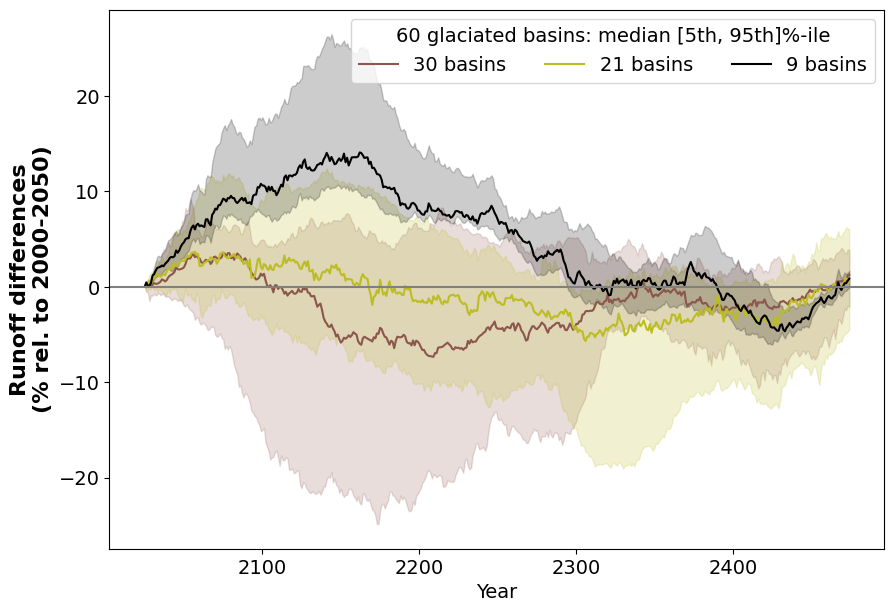

In [45]:
plt.figure(figsize=(10,7))
for c,j in enumerate([0,2,3]):
    c = cols[j]
    _pd_sel = sel_diff_runoff_basins_rel.sel(basin = clus_basin_glac_dict[j]).to_dataframe().reset_index()
    n = len(_pd_sel.basin.unique())
    sns.lineplot(data = _pd_sel, x='time', y= 'runoff', estimator='median',
        errorbar=('pi', 90), color = c, label=f'{n} basins')
plt.legend(title = '60 glaciated basins: median [5th, 95th]%-ile', ncol=3)
plt.ylabel(f'Runoff differences\n(% rel. to 2000-2050)', fontsize=16,fontweight='bold')
plt.xlabel('Year')
plt.axhline(0,color='grey')

KeyError: 'new_c'

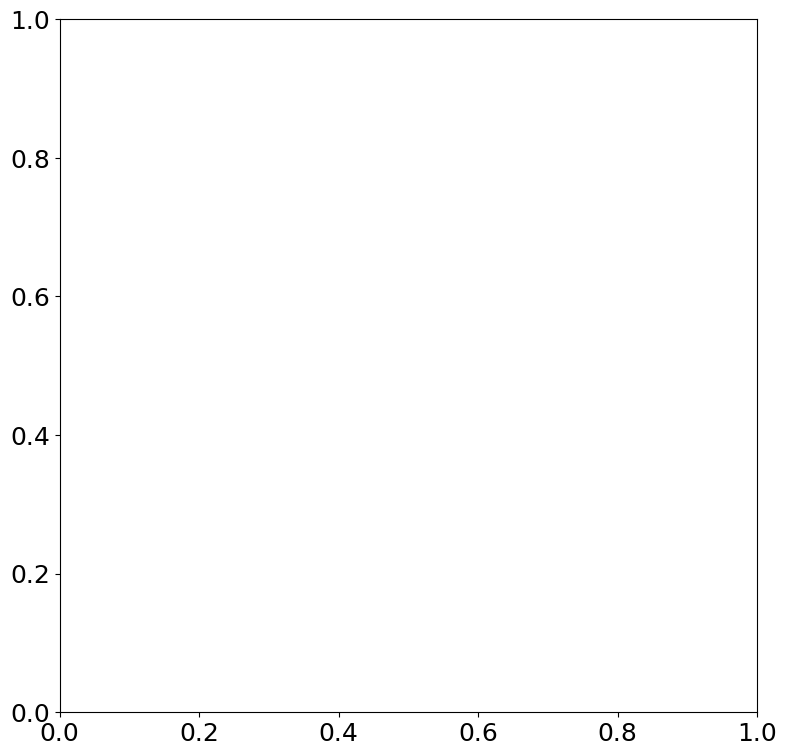

In [48]:
plt.figure(figsize=(9,9))
ax = plt.gca()
pd_t = pd.DataFrame([temp_ch_diff_oversh_stab_max,
                     #-max_vol_rel_diff_stab_oversh, Maximum volume difference (%, rel. to 2020)
                     end_vol_oversh-min_vol_oversh, # end_vol_rel_diff_stab_oversh, 
                     pd_clusters_all[f'kmeans_{k}clusters_diff_oversh']]).T
pd_t['region'] = df_scenario_common_vol_rel_sel.rgi_reg
def plotlabel(xvar, yvar, label, ax=None):
    ax.text(xvar-0.01, yvar+0.2, label, alpha=alpha_t, fontsize=20)
def plotlabel_b(xvar, yvar, label, ax=None):
    ax.text(xvar-0.05, yvar-1.2, label, alpha=alpha_t, fontsize=20)
#for j, temp_ch in enumerate(temp_ch_diff_oversh_stab_max): #p.arange(0,6,1):
    
for c in np.arange(0,k,1):
    rgi_regs_sel = pd_t.loc[pd_t[2]==c].index.values
    pd_t_sel = pd_t.loc[rgi_regs_sel]
    ax.plot(pd_t_sel[0], pd_t_sel[1],'o', alpha = alpha,ms=ms, color=cols[c])
    #ax.plot(temp_ch, pd_t[1][j],'o', ms =15,
    #        color=cmap(scaler.transform(temp_ch.reshape(-1,1))).flatten())
pd_t.index = pd_t.region  
drop_rgis = ['08','02','09',
             '10']
pd_t.drop(drop_rgis).apply(lambda x: plotlabel(x[0],x[1], x.region, ax=ax), axis=1)
pd_t.loc[drop_rgis].apply(lambda x: plotlabel_b(x[0],x[1], x.region, ax=ax), axis=1)

ax.set_xlabel('Maximum regional temperature difference (°C):   \nStabilisation 1.5°C - Overshoot 3.0°C->1.5°C   ', fontsize=18)
#ax.set_ylabel('Maximum volume difference (%, rel. to 2020):\nStabilisation 1.5°C - Overshoot 3.0°C->1.5°C', fontsize=18)
# ax.set_ylabel('Volume difference in 2500 (% rel. to 2020):\nStabilisation 1.5°C - Overshoot 3.0°C->1.5°C', fontsize=18)
ax.set_ylabel('Mass differences (year 2500-minimum)\nfor Overshoot 3.0°C->1.5°C (% rel. to 2020)', fontsize=18)

num_text_x = 0.01
for j,axi in enumerate(axs):
    num_text_y = 0.935
    j = j+5
    axi.text(num_text_x, num_text_y,
             num_dict[j], fontsize=28, weight='bold', 
             transform=axi.transAxes)
    
import scipy
# linear regression over all regions
print(scipy.stats.linregress(pd_t[0],pd_t[1]))
# **linear regression just on those with regrowth --> yellow cluster iii)**
pd_t_3 = pd_t.loc[pd_clusters_all[f'kmeans_{k}clusters_diff_oversh'] == 1]
print(scipy.stats.linregress(pd_t_3[0],pd_t_3[1]))